#StackGAN Text to Image Synthesis:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## So first Implementation of Stage 1 of StackGAN
#### 1- takes input as text,
#### 2- convert the text to embedding using our pre-trained character level embedding.
#### 3- Then, we give this embedding to Conditional Augmentation (CA) and
#### 4- then to Stage I Generator which gives us low-resolution 64*64 images.

In [5]:
"""StackGAN.
"""
# Importing required libraries

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pickle
import random
import time

import numpy as np
import pandas as pd
import tensorflow as tf

assert tf.__version__.startswith('2')

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, ReLU, Activation
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Dense, concatenate
from tensorflow.keras.layers import Flatten, Lambda, Reshape, ZeroPadding2D, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
%load_ext tensorboard
from keras.callbacks import TensorBoard
import os

## Conditioning Augmentation Network
#### Text Embedding

In [7]:
# defining conditioning augmentation:

def conditioning_augmentation(x):

	mean = x[:, :128]
	log_sigma = x[:, 128:]    # The mean_logsigma passed as argument is converted into the text conditioning variable

	stddev = tf.math.exp(log_sigma)
	epsilon = K.random_normal(shape=K.constant((mean.shape[1], ), dtype='int32'))
	c = mean + stddev * epsilon       # c: The text conditioning variable after computation.
	return c

def build_ca_network():
	"""Builds the conditioning augmentation network.
	"""
	input_layer1 = Input(shape=(1024,)) #size of the vocabulary in the text data
	mls = Dense(256)(input_layer1)
	mls = LeakyReLU(alpha=0.2)(mls)         #x: The output of the text embedding passed through a FC layer with LeakyReLU non-linearity.
	ca = Lambda(conditioning_augmentation)(mls)
	return Model(inputs=[input_layer1], outputs=[ca]) 

## Stage 1 Generator Network
#### 1.The generator is fed with the text captions in the form of Embedding vectors which will be used to condition its generation of features.
#### 2.A vector with random noise.

In [8]:
def UpSamplingBlock(x, num_kernels):
	"""An Upsample block with Upsampling2D, Conv2D, BatchNormalization and a ReLU activation.

	Args:
		x: The preceding layer as input.
		num_kernels: Number of kernels for the Conv2D layer.

	Returns:
		x: The final activation layer after the Upsampling block.
	"""
	x = UpSampling2D(size=(2,2))(x)
	x = Conv2D(num_kernels, kernel_size=(3,3), padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x) #prevent from mode collapse
	x = ReLU()(x)
	return x


def build_stage1_generator():

	input_layer1 = Input(shape=(1024,))
	ca = Dense(256)(input_layer1)
	ca = LeakyReLU(alpha=0.2)(ca)

	# Obtain the conditioned text
	c = Lambda(conditioning_augmentation)(ca)

	input_layer2 = Input(shape=(100,))
	concat = Concatenate(axis=1)([c, input_layer2]) 

	x = Dense(16384, use_bias=False)(concat) 
	x = ReLU()(x)
	x = Reshape((4, 4, 1024), input_shape=(16384,))(x)

	x = UpSamplingBlock(x, 512) 
	x = UpSamplingBlock(x, 256)
	x = UpSamplingBlock(x, 128)
	x = UpSamplingBlock(x, 64)   # upsampled our image to 64*64*3 

	x = Conv2D(3, kernel_size=3, padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = Activation('tanh')(x)

	stage1_gen = Model(inputs=[input_layer1, input_layer2], outputs=[x, ca]) 
	return stage1_gen

In [9]:
generator = build_stage1_generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          262400      ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256)          0           ['dense[0][0]']                  
                                                                                                  
 lambda (Lambda)                (None, 128)          0           ['leaky_re_lu[0][0]']            
                                                                                              

## Stage 1 Discriminator Network

In [10]:
def ConvBlock(x, num_kernels, kernel_size=(4,4), strides=2, activation=True):
	"""A ConvBlock with a Conv2D, BatchNormalization and LeakyReLU activation.

	Args:
		x: The preceding layer as input.
		num_kernels: Number of kernels for the Conv2D layer.

	Returns:
		x: The final activation layer after the ConvBlock block.
	"""
	x = Conv2D(num_kernels, kernel_size=kernel_size, padding='same', strides=strides, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	
	if activation:
		x = LeakyReLU(alpha=0.2)(x)
	return x


def build_embedding_compressor():
    """Build embedding compressor model
    """
    input_layer1 = Input(shape=(1024,)) 
    x = Dense(128)(input_layer1)
    x = ReLU()(x)

    model = Model(inputs=[input_layer1], outputs=[x])
    return model

# the discriminator is fed with two inputs, the feature from Generator and the text embedding
def build_stage1_discriminator():
	"""Builds the Stage 1 Discriminator that uses the 64x64 resolution images from the generator
	and the compressed and spatially replicated embedding.

	Returns:
		Stage 1 Discriminator Model for StackGAN.
	"""
	input_layer1 = Input(shape=(64, 64, 3))  

	x = Conv2D(64, kernel_size=(4,4), strides=2, padding='same', use_bias=False,
				kernel_initializer='he_uniform')(input_layer1)
	x = LeakyReLU(alpha=0.2)(x)

	x = ConvBlock(x, 128)
	x = ConvBlock(x, 256)
	x = ConvBlock(x, 512)

	# Obtain the compressed and spatially replicated text embedding
	input_layer2 = Input(shape=(4, 4, 128)) #2nd input to discriminator, text embedding
	concat = concatenate([x, input_layer2])

	x1 = Conv2D(512, kernel_size=(1,1), padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(concat)
	x1 = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x1 = LeakyReLU(alpha=0.2)(x)

	# Flatten and add a FC layer to predict.
	x1 = Flatten()(x1)
	x1 = Dense(1)(x1)
	x1 = Activation('sigmoid')(x1)

	stage1_dis = Model(inputs=[input_layer1, input_layer2], outputs=[x1])  
	return stage1_dis

In [11]:
discriminator = build_stage1_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 64)   3072        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)      (None, 32, 32, 64)   0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 16, 16, 128)  131072      ['leaky_re_lu_1[0][0]']          
                                                                                            

## Stage 1 Adversarial Model (Building a GAN)

In [12]:
# Building GAN with Generator and Discriminator

def build_adversarial(generator_model, discriminator_model):
	"""Stage 1 Adversarial model.

	Args:
		generator_model: Stage 1 Generator Model
		discriminator_model: Stage 1 Discriminator Model

	Returns:
		Adversarial Model.
	"""
	input_layer1 = Input(shape=(1024,))  
	input_layer2 = Input(shape=(100,)) 
	input_layer3 = Input(shape=(4, 4, 128)) 

	x, ca = generator_model([input_layer1, input_layer2]) #text,noise

	discriminator_model.trainable = False 

	probabilities = discriminator_model([x, input_layer3]) 
	adversarial_model = Model(inputs=[input_layer1, input_layer2, input_layer3], outputs=[probabilities, ca])
	return adversarial_model

In [13]:
ganstage1 = build_adversarial(generator, discriminator)
ganstage1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 model (Functional)             [(None, 64, 64, 3),  10270400    ['input_5[0][0]',                
                                 (None, 256)]                     'input_6[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, 4, 4, 128)]  0           []                         

## Traininng the Utilities

In [14]:
def checkpoint_prefix():
	checkpoint_dir = './training_checkpoints'
	checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

	return checkpoint_prefix

def adversarial_loss(y_true, y_pred):
	mean = y_pred[:, :128]
	ls = y_pred[:, 128:]
	loss = -ls + 0.5 * (-1 + tf.math.exp(2.0 * ls) + tf.math.square(mean))
	loss = K.mean(loss)
	return loss

def normalize(input_image, real_image):
	input_image = (input_image / 127.5) - 1
	real_image = (real_image / 127.5) - 1

	return input_image, real_image

def load_class_ids_filenames(class_id_path, filename_path):
	with open(class_id_path, 'rb') as file:
		class_id = pickle.load(file, encoding='latin1')

	with open(filename_path, 'rb') as file:
		filename = pickle.load(file, encoding='latin1')

	return class_id, filename

def load_text_embeddings(text_embeddings):
	with open(text_embeddings, 'rb') as file:
		embeds = pickle.load(file, encoding='latin1')
		embeds = np.array(embeds)

	return embeds

def load_bbox(data_path):
	bbox_path = data_path + '/bounding_boxes.txt'
	image_path = data_path + '/images.txt'
	bbox_df = pd.read_csv(bbox_path, delim_whitespace=True, header=None).astype(int)
	filename_df = pd.read_csv(image_path, delim_whitespace=True, header=None)

	filenames = filename_df[1].tolist()
	bbox_dict = {i[:-4]:[] for i in filenames[:2]}

	for i in range(0, len(filenames)):
		bbox = bbox_df.iloc[i][1:].tolist()
		dict_key = filenames[i][:-4]
		bbox_dict[dict_key] = bbox

	return bbox_dict

def load_images(image_path, bounding_box, size):
	"""Crops the image to the bounding box and then resizes it.
	"""
	image = Image.open(image_path).convert('RGB')
	w, h = image.size
	if bounding_box is not None:
		r = int(np.maximum(bounding_box[2], bounding_box[3]) * 0.75)
		c_x = int((bounding_box[0] + bounding_box[2]) / 2)
		c_y = int((bounding_box[1] + bounding_box[3]) / 2)
		y1 = np.maximum(0, c_y - r)
		y2 = np.minimum(h, c_y + r)
		x1 = np.maximum(0, c_x - r)
		x2 = np.minimum(w, c_x + r)
		image = image.crop([x1, y1, x2, y2])

	image = image.resize(size, PIL.Image.BILINEAR)
	return image

def load_data(filename_path, class_id_path, dataset_path, embeddings_path, size):
	"""Loads the Dataset.
	"""
	data_dir = "/content/drive/MyDrive/Text2Img_DC_GAN/birds"
	train_dir = data_dir + "/train"
	test_dir = data_dir + "/test"
	embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
	embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
	filename_path_train = train_dir + "/filenames.pickle"
	filename_path_test = test_dir + "/filenames.pickle"
	class_id_path_train = train_dir + "/class_info.pickle"
	class_id_path_test = test_dir + "/class_info.pickle"
	dataset_path = "/content/drive/MyDrive/Text2Img_DC_GAN/CUB_200_2011/CUB_200_2011"
	class_id, filenames = load_class_ids_filenames(class_id_path, filename_path)
	embeddings = load_text_embeddings(embeddings_path)
	bbox_dict = load_bbox(dataset_path)

	x, y, embeds = [], [], []

	for i, filename in enumerate(filenames):
		bbox = bbox_dict[filename]

		try:	
			image_path = f'{dataset_path}/images/{filename}.jpg'
			image = load_images(image_path, bbox, size)
			e = embeddings[i, :, :]
			embed_index = np.random.randint(0, e.shape[0] - 1)
			embed = e[embed_index, :]

			x.append(np.array(image))
			y.append(class_id[i])
			embeds.append(embed)

		except Exception as e:
			print(f'{e}')
	
	x = np.array(x)
	y = np.array(y)
	embeds = np.array(embeds)
	
	return x, y, embeds

def save_image(file, save_path):
	"""Saves the image at the specified file path.
	"""
	image = plt.figure()
	ax = image.add_subplot(1,1,1)
	ax.imshow(file)
	ax.axis("off")
	plt.savefig(save_path)

In [15]:
############################################################
# StackGAN class
############################################################

class StackGanStage1(object):
  """StackGAN Stage 1 class."""
  data_dir = "/content/drive/MyDrive/Text2Img_DC_GAN/birds"
  train_dir = data_dir + "/train"
  test_dir = data_dir + "/test"
  embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
  embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
  filename_path_train = train_dir + "/filenames.pickle"
  filename_path_test = test_dir + "/filenames.pickle"
  class_id_path_train = train_dir + "/class_info.pickle"
  class_id_path_test = test_dir + "/class_info.pickle"
  dataset_path = "/content/drive/MyDrive/Text2Img_DC_GAN/CUB_200_2011/CUB_200_2011"
  
  #Here I am interrupting after 10 epochs only due to my device storage limitation, but we have to take atleast 200 epochs for better results
  def __init__(self, epochs=100, z_dim=100, batch_size=64, enable_function=True, stage1_generator_lr=0.0002, stage1_discriminator_lr=0.0002):
          self.epochs = epochs
          self.z_dim = z_dim
          self.enable_function = enable_function
          self.stage1_generator_lr = stage1_generator_lr
          self.stage1_discriminator_lr = stage1_discriminator_lr
          self.image_size = 64
          self.conditioning_dim = 128
          self.batch_size = batch_size
              
          self.stage1_generator_optimizer = Adam(learning_rate=stage1_generator_lr, beta_1=0.5, beta_2=0.999)
          self.stage1_discriminator_optimizer = Adam(learning_rate=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
              
          self.stage1_generator = build_stage1_generator()
          self.stage1_generator.compile(loss='mse', optimizer=self.stage1_generator_optimizer)

          self.stage1_discriminator = build_stage1_discriminator()
          self.stage1_discriminator.compile(loss='binary_crossentropy', optimizer=self.stage1_discriminator_optimizer)

          self.ca_network = build_ca_network()
          self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')

          self.embedding_compressor = build_embedding_compressor()
          self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')

          self.stage1_adversarial = build_adversarial(self.stage1_generator, self.stage1_discriminator)
          self.stage1_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], loss_weights=[1, 2.0], optimizer=self.stage1_generator_optimizer)

          self.checkpoint1 = tf.train.Checkpoint(
                generator_optimizer=self.stage1_generator_optimizer,
                discriminator_optimizer=self.stage1_discriminator_optimizer,
                generator=self.stage1_generator,
                discriminator=self.stage1_discriminator)

  def visualize_stage1(self):
          """Running Tensorboard visualizations.
          """
          tb = TensorBoard(log_dir="logs/".format(time.time()))
          tb.set_model(self.stage1_generator)
          tb.set_model(self.stage1_discriminator)
          tb.set_model(self.ca_network)
          tb.set_model(self.embedding_compressor)

  def train_stage1(self):
          
          """Trains the stage1 StackGAN.
          """
          x_train, y_train, train_embeds = load_data(filename_path = self.filename_path_train, class_id_path = self.class_id_path_train,
          dataset_path = self.dataset_path, embeddings_path = self.embeddings_path_train, size=(64, 64))

          x_test, y_test, test_embeds = load_data(filename_path=self.filename_path_test, class_id_path = self.class_id_path_test, 
          dataset_path = self.dataset_path, embeddings_path = self.embeddings_path_test, size=(64, 64))

          real = np.ones((self.batch_size, 1), dtype='float') * 0.9
          fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

          for epoch in range(self.epochs):
            print(f'Epoch: {epoch}')

            gen_loss = []
            dis_loss = []

            num_batches = int(x_train.shape[0] / self.batch_size)

            for i in range(num_batches):

              latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
              embedding_text = train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
              compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
              compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, 128))
              compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

              image_batch = x_train[i * self.batch_size:(i+1) * self.batch_size]
              image_batch = (image_batch - 127.5) / 127.5

              gen_images, _ = self.stage1_generator.predict([embedding_text, latent_space])

              discriminator_loss = self.stage1_discriminator.train_on_batch([image_batch, compressed_embedding], 
                np.reshape(real, (self.batch_size, 1)))

              discriminator_loss_gen = self.stage1_discriminator.train_on_batch([gen_images, compressed_embedding],
                np.reshape(fake, (self.batch_size, 1)))

              discriminator_loss_wrong = self.stage1_discriminator.train_on_batch([gen_images[: self.batch_size-1], compressed_embedding[1:]], 
                np.reshape(fake[1:], (self.batch_size-1, 1)))

              # Discriminator loss
              d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_wrong))
              dis_loss.append(d_loss)

              print(f'Discriminator Loss: {d_loss}')

              # Generator loss
              g_loss = self.stage1_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
                [K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])

              print(f'Generator Loss: {g_loss}')
              gen_loss.append(g_loss)

              if epoch % 5 == 0:
                  latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
                  embedding_batch = test_embeds[0 : self.batch_size]
                  gen_images, _ = self.stage1_generator.predict_on_batch([embedding_batch, latent_space])

                  for i, image in enumerate(gen_images[:10]):
                      save_image(image, f'/content/drive/MyDrive/Text2Img_DC_GAN/test/gen_1_{epoch}_{i}')

              if epoch % 25 == 0:
                self.stage1_generator.save_weights('/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage1_gen.h5')
                self.stage1_discriminator.save_weights("/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage1_disc.h5")
                self.ca_network.save_weights('/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage1_ca.h5')
                self.embedding_compressor.save_weights('/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage1_embco.h5')
                self.stage1_adversarial.save_weights('/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage1_adv.h5')      

          self.stage1_generator.save_weights('/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage1_gen.h5')
          self.stage1_discriminator.save_weights("/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage1_disc.h5")

Epoch: 0
2/2 [==============================] - 5s 13ms/step
Discriminator Loss: 0.9424111116677523


Generator Loss: [0.7251853942871094, 0.6891665458679199, 0.01800941862165928]


2/2 [==============================] - 0s 20ms/step


Discriminator Loss: 0.5623849686235189
Generator Loss: [1.2720215320587158, 1.2319756746292114, 0.020022956654429436]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.6517499117180705


<ipython-input-11-f9f44655f657>:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  image = plt.figure()


Generator Loss: [1.1984807252883911, 1.1567684412002563, 0.020856142044067383]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.3808146622031927


Generator Loss: [0.7161849737167358, 0.6713603138923645, 0.022412315011024475]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.2256893264129758
Generator Loss: [0.9422469139099121, 0.9075574278831482, 0.017344754189252853]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.32520756556186825


Generator Loss: [0.6503812074661255, 0.6059263944625854, 0.02222740463912487]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.40579100416289293


Generator Loss: [2.8669345378875732, 2.8319497108459473, 0.017492391169071198]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.7353574876324274


Generator Loss: [0.401407927274704, 0.33754414319992065, 0.03193189203739166]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.32470336789265275


Generator Loss: [0.41999536752700806, 0.339984655380249, 0.040005359798669815]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.24097002984490246


Generator Loss: [0.5996250510215759, 0.5532934069633484, 0.023165825754404068]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.22153866436565295
Generator Loss: [0.5814839005470276, 0.5433422923088074, 0.019070802256464958]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.21627963264472783
Generator Loss: [0.5156725645065308, 0.4817635416984558, 0.016954515129327774]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.2383973249234259
Generator Loss: [0.5938593745231628, 0.5588406920433044, 0.017509330064058304]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.2721816694829613
Generator Loss: [0.39799657464027405, 0.3698788285255432, 0.014058869332075119]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.21937242319108918
Generator Loss: [0.589838445186615, 0.5486844778060913, 0.020576976239681244]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.19294185360195115


Generator Loss: [0.6292157769203186, 0.5916786193847656, 0.018768589943647385]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.19903247064212337


Generator Loss: [0.3786053955554962, 0.34696778655052185, 0.015818800777196884]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.20411139039788395


Generator Loss: [0.4058811366558075, 0.38084322214126587, 0.012518959119915962]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.19501910754479468
Generator Loss: [0.40308669209480286, 0.3802880048751831, 0.011399339884519577]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.19074529083445668
Generator Loss: [0.3615076541900635, 0.3361840844154358, 0.01266179233789444]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.21103644277900457


Generator Loss: [0.3774873614311218, 0.34951984882354736, 0.01398376002907753]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.20516630832571536


Generator Loss: [0.3724544942378998, 0.3471527397632599, 0.012650871649384499]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.18872380896937102
Generator Loss: [0.4471147358417511, 0.4194328188896179, 0.013840963132679462]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.20433904242236167
Generator Loss: [0.41420164704322815, 0.37862834334373474, 0.017786649987101555]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1959269418148324


Generator Loss: [0.4394572377204895, 0.4026925563812256, 0.018382348120212555]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.23081218110746704


Generator Loss: [0.9988213777542114, 0.9740096926689148, 0.01240585744380951]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.3045011330395937
Generator Loss: [0.6286349892616272, 0.601086437702179, 0.013774268329143524]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.32030538891558535
Generator Loss: [0.39726606011390686, 0.3503401279449463, 0.023462966084480286]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.22609872606881254
Generator Loss: [0.755899965763092, 0.7204774022102356, 0.017711274325847626]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.24766083713257103


Generator Loss: [0.37721508741378784, 0.3468613922595978, 0.015176842920482159]


2/2 [==============================] - 0s 10ms/step
Discriminator Loss: 0.20560333405592246


Generator Loss: [0.38984739780426025, 0.35951533913612366, 0.015166025608778]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1889917241387593


Generator Loss: [0.3899770975112915, 0.35036545991897583, 0.019805820658802986]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.18697713759320322


Generator Loss: [0.3997957110404968, 0.3670901954174042, 0.016352759674191475]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1972000329697039
Generator Loss: [0.3722761869430542, 0.3421689569950104, 0.01505360845476389]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1872819869313389


Generator Loss: [0.3772974908351898, 0.35155585408210754, 0.01287081278860569]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.18683358177077025
Generator Loss: [1.0180795192718506, 0.9894944429397583, 0.014292559586465359]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.19181002584809903
Generator Loss: [0.43818268179893494, 0.4086897671222687, 0.014746451750397682]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1887214490743645
Generator Loss: [0.3785279095172882, 0.35093212127685547, 0.013797897845506668]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.18125003280874807
Generator Loss: [0.3735397160053253, 0.3452737629413605, 0.014132972806692123]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.18471777065860806
Generator Loss: [0.38584086298942566, 0.36203908920288086, 0.011900882236659527]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17262941145600053


Generator Loss: [0.38369691371917725, 0.35959434509277344, 0.012051288038492203]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17691303938045166
Generator Loss: [0.4216177463531494, 0.398209810256958, 0.011703968048095703]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1882607299121446


Generator Loss: [0.3667735457420349, 0.33843323588371277, 0.014170151203870773]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.18644994308124296


Generator Loss: [0.372304230928421, 0.3527907729148865, 0.009756732732057571]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.18162623987882398
Generator Loss: [0.40342333912849426, 0.3768257796764374, 0.013298776932060719]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17621823126683012
Generator Loss: [0.4068938195705414, 0.3812209367752075, 0.012836446985602379]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17467997544736136


Generator Loss: [0.4031176269054413, 0.3772582411766052, 0.012929691933095455]


2/2 [==============================] - 0s 21ms/step
Discriminator Loss: 0.17328729043219937
Generator Loss: [0.3696032762527466, 0.3389787971973419, 0.01531223300844431]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.17864040996937547
Generator Loss: [0.4378155767917633, 0.41194629669189453, 0.012934636324644089]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.17937008302396862
Generator Loss: [0.3691166639328003, 0.3489658832550049, 0.010075388476252556]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1686474710368202
Generator Loss: [0.42215391993522644, 0.40107154846191406, 0.010541191324591637]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1738059228300699


Generator Loss: [0.3600420355796814, 0.34527117013931274, 0.007385428994894028]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17080184818041744


Generator Loss: [0.3880675733089447, 0.3676614761352539, 0.010203050449490547]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17382186734175775


Generator Loss: [0.398661345243454, 0.3824560046195984, 0.008102674037218094]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.16849519636161858
Generator Loss: [0.40705621242523193, 0.3902195692062378, 0.00841832160949707]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1739848975885252
Generator Loss: [0.36600133776664734, 0.3415747582912445, 0.012213287875056267]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17901387698657345
Generator Loss: [0.3670732378959656, 0.34196019172668457, 0.012556517496705055]


2/2 [==============================] - 0s 21ms/step
Discriminator Loss: 0.17646598178544082
Generator Loss: [0.3620522916316986, 0.34054064750671387, 0.010755819268524647]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.17700586684804875


Generator Loss: [0.4781663119792938, 0.4581872820854187, 0.009989514946937561]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.18736735651327763


Generator Loss: [0.36396464705467224, 0.3435114920139313, 0.010226577520370483]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17996943577600177


Generator Loss: [0.6110119223594666, 0.5951367020606995, 0.007937618531286716]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.18699480839131866


Generator Loss: [0.37947553396224976, 0.365563303232193, 0.006956120021641254]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.20135410508373752


Generator Loss: [0.4979898929595947, 0.48090898990631104, 0.008540455251932144]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17279817463713698
Generator Loss: [0.5121811628341675, 0.49391525983810425, 0.009132965467870235]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.17230532989196945
Generator Loss: [0.4389526844024658, 0.4180370569229126, 0.010457806289196014]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16887117382430006


Generator Loss: [0.4053499400615692, 0.3888051211833954, 0.008272411301732063]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.20169456282746978


Generator Loss: [0.3590168356895447, 0.3436540961265564, 0.007681376300752163]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.21298244903664454


Generator Loss: [0.3937302827835083, 0.3770363926887512, 0.008346942253410816]


2/2 [==============================] - 0s 10ms/step
Discriminator Loss: 0.19718372830357112


Generator Loss: [0.3665260672569275, 0.35465356707572937, 0.005936251487582922]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1847042329609394
Generator Loss: [0.3685374855995178, 0.3540950119495392, 0.0072212363593280315]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1797494168567937


Generator Loss: [0.3709392547607422, 0.35067257285118103, 0.010133344680070877]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16963959579879884


Generator Loss: [0.8183109760284424, 0.8054932355880737, 0.00640885578468442]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17042013241007226


Generator Loss: [0.4173474609851837, 0.4033268690109253, 0.0070103006437420845]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1831988770281896


Generator Loss: [0.42450132966041565, 0.4089442491531372, 0.007778540253639221]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.18515342150931247


Generator Loss: [0.4256319999694824, 0.40807604789733887, 0.008777976967394352]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1757315566210309
Generator Loss: [0.3897343873977661, 0.3745782971382141, 0.007578047923743725]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.17402689751179423


Generator Loss: [0.3742861747741699, 0.36153852939605713, 0.00637382548302412]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17766363748523872


Generator Loss: [0.38679254055023193, 0.37300562858581543, 0.006893461104482412]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17191053559145075
Generator Loss: [0.35852110385894775, 0.3432137966156006, 0.007653656415641308]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.17792083723907126


Generator Loss: [0.5885565876960754, 0.5741826295852661, 0.0071869841776788235]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17361122883448843


Generator Loss: [0.4444902539253235, 0.4287733733654022, 0.007858441211283207]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17458848849491915
Generator Loss: [0.47697150707244873, 0.46372097730636597, 0.006625267677009106]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1732859211260802
Generator Loss: [0.3846875727176666, 0.3730359673500061, 0.005825798958539963]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.1756484399738838
Generator Loss: [0.4644746780395508, 0.450714111328125, 0.0068802847526967525]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.17750995340611553
Generator Loss: [0.37565121054649353, 0.36508703231811523, 0.005282086320221424]


2/2 [==============================] - 0s 19ms/step
Discriminator Loss: 0.17103031008446123


Generator Loss: [0.36094212532043457, 0.35016244649887085, 0.005389843136072159]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17265342990140198


Generator Loss: [0.41236555576324463, 0.3969150185585022, 0.007725274655967951]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17215315780777019


Generator Loss: [0.41129401326179504, 0.39366865158081055, 0.008812681771814823]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1684545029711444
Generator Loss: [0.4163624346256256, 0.4006994664669037, 0.007831481285393238]


2/2 [==============================] - 0s 18ms/step
Discriminator Loss: 0.1718844413953775


Generator Loss: [0.41639530658721924, 0.40224310755729675, 0.007076095324009657]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16979496605927125


Generator Loss: [0.35921579599380493, 0.3464386463165283, 0.006388576701283455]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.173057422558486


Generator Loss: [0.4357822835445404, 0.4146209955215454, 0.010580649599432945]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17241162894060835


Generator Loss: [0.3753335773944855, 0.3569120466709137, 0.00921076349914074]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17043771413591458


Generator Loss: [0.3708423972129822, 0.3487723171710968, 0.011035033501684666]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1689656860071409
Generator Loss: [0.40723639726638794, 0.3876088857650757, 0.009813753888010979]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17161223352013621


Generator Loss: [0.589741587638855, 0.5689868927001953, 0.010377362370491028]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17246397494454868


Generator Loss: [1.3416284322738647, 1.3177704811096191, 0.011928953230381012]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17502161908487324


Generator Loss: [1.8816426992416382, 1.857648253440857, 0.011997237801551819]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17955814763263334


Generator Loss: [0.42789915204048157, 0.4066106677055359, 0.010644238442182541]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.17464687328902073


Generator Loss: [1.0080634355545044, 0.9946624040603638, 0.006700517609715462]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1788802838709671
Generator Loss: [0.35933196544647217, 0.3478719890117645, 0.005729985423386097]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.18458617420401424
Generator Loss: [0.5828934907913208, 0.5674752593040466, 0.007709110155701637]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.186489351966884
Generator Loss: [0.39815983176231384, 0.38368961215019226, 0.007235107012093067]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17920016282005236


Generator Loss: [0.4098903238773346, 0.3960888981819153, 0.006900709122419357]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17790452621466102


Generator Loss: [0.9300218820571899, 0.9198620915412903, 0.005079902708530426]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.17270504088082816
Generator Loss: [0.36390572786331177, 0.3515881896018982, 0.006158767268061638]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.18992289499146864


Generator Loss: [0.5175089836120605, 0.5043277144432068, 0.006590625736862421]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.20524614976602606


Generator Loss: [0.4021199643611908, 0.3888810873031616, 0.006619434803724289]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.19089520768466173


Generator Loss: [0.36025601625442505, 0.3456491231918335, 0.007303445599973202]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.17152029251883505


Generator Loss: [0.5333107709884644, 0.51839280128479, 0.007458985783159733]


2/2 [==============================] - 0s 18ms/step
Discriminator Loss: 0.17948035142035224
Generator Loss: [0.40310975909233093, 0.38620996475219727, 0.008449902758002281]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17128499795217067


Generator Loss: [0.3634800314903259, 0.3463594913482666, 0.008560264483094215]


2/2 [==============================] - 0s 19ms/step
Discriminator Loss: 0.16931831491820049


Generator Loss: [0.36518263816833496, 0.3458455204963684, 0.009668562561273575]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17961868128622882


Generator Loss: [0.4410574734210968, 0.42481374740600586, 0.00812186487019062]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.18488911988970358
Generator Loss: [0.35666078329086304, 0.3413814306259155, 0.007639678195118904]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1770596697315341
Generator Loss: [0.3699347972869873, 0.3535170555114746, 0.0082088652998209]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.1992648445047962
Generator Loss: [0.3778876066207886, 0.3656458258628845, 0.006120894104242325]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.17815325110859703


Generator Loss: [0.40897467732429504, 0.3968609571456909, 0.006056853570044041]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.1755518274512724


Generator Loss: [0.4714506268501282, 0.4598734974861145, 0.005788560025393963]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.18114071048694314
Generator Loss: [0.4669830799102783, 0.45293012261390686, 0.00702647352591157]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17285793556948192


Generator Loss: [0.36261436343193054, 0.35001885890960693, 0.00629775132983923]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1694067421994987
Generator Loss: [0.44287192821502686, 0.4293716549873352, 0.006750136613845825]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.17694825660146307


Generator Loss: [0.38526418805122375, 0.37355008721351624, 0.005857050884515047]


2/2 [==============================] - 0s 19ms/step
Discriminator Loss: 0.17794645232061157


Generator Loss: [0.4315541982650757, 0.42093148827552795, 0.005311352200806141]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.16941841851803474


Generator Loss: [0.3578341007232666, 0.3421572744846344, 0.007838414050638676]


2/2 [==============================] - 0s 19ms/step
Discriminator Loss: 0.16941220335866092


Generator Loss: [0.6975469589233398, 0.6813997030258179, 0.008073636330664158]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17351424536900595


Generator Loss: [0.5907577276229858, 0.5779165029525757, 0.006420614663511515]


2/2 [==============================] - 0s 18ms/step
Discriminator Loss: 0.174557527541765


Generator Loss: [0.5065915584564209, 0.48629915714263916, 0.010146193206310272]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.17462131348293042
Generator Loss: [0.46876561641693115, 0.44952237606048584, 0.009621627628803253]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1852403398952447
Generator Loss: [0.42321255803108215, 0.4097225069999695, 0.006745021790266037]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.16894611149655248
Generator Loss: [0.3514710068702698, 0.33251067996025085, 0.009480170905590057]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.169200012802321


Generator Loss: [0.3515445291996002, 0.33793362975120544, 0.006805445998907089]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16871248567986186


Generator Loss: [0.36958980560302734, 0.3594667911529541, 0.005061511881649494]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16789146144583356
Generator Loss: [0.34478017687797546, 0.33395010232925415, 0.005415040068328381]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16833001988197793


Generator Loss: [0.36492305994033813, 0.35600435733795166, 0.00445934385061264]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.17022287665167823
Generator Loss: [0.3763817250728607, 0.3673260807991028, 0.004527820274233818]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1666390625105123


Generator Loss: [0.3937613368034363, 0.3837282955646515, 0.005016523413360119]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.16788322871434502
Generator Loss: [0.3567003011703491, 0.3435591161251068, 0.006570585072040558]


Epoch: 1
2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1700187621245277
Generator Loss: [0.39110973477363586, 0.37620872259140015, 0.007450506556779146]
2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.1657531517012103
Generator Loss: [0.3572428822517395, 0.34224802255630493, 0.007497432641685009]
2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1683414129729499
Generator Loss: [0.3798486888408661, 0.35946786403656006, 0.010190406814217567]
2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.17342807761815493
Generator Loss: [0.46811649203300476, 0.45107194781303406, 0.008522278629243374]
2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17150889390904922
Generator Loss: [0.37268513441085815, 0.36084067821502686, 0.005922222509980202]
2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.18056779152539093
Generator Loss: [0.39728277921676636, 0

2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17693378093281353
Generator Loss: [0.32930973172187805, 0.32725727558135986, 0.0010262252762913704]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16756712981714372


Generator Loss: [0.336402952671051, 0.33401134610176086, 0.0011958082905039191]


2/2 [==============================] - 0s 11ms/step
Discriminator Loss: 0.1723595538560403


Generator Loss: [0.3314211070537567, 0.329080194234848, 0.001170458970591426]


2/2 [==============================] - 0s 19ms/step
Discriminator Loss: 0.16752543629218053


Generator Loss: [0.358060359954834, 0.3562540113925934, 0.0009031676454469562]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.17074987305761624


Generator Loss: [0.35324591398239136, 0.35099756717681885, 0.0011241743341088295]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16801386969382293


Generator Loss: [0.33572202920913696, 0.3340452015399933, 0.0008384075481444597]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16832319298282528


Generator Loss: [0.33174046874046326, 0.32873231172561646, 0.0015040839789435267]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.16507226065846226


Generator Loss: [0.33187222480773926, 0.3282124400138855, 0.0018298934446647763]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16782888713601096
Generator Loss: [0.3290357291698456, 0.326354444026947, 0.0013406405923888087]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16392903715768625


Generator Loss: [0.3280360698699951, 0.32605230808258057, 0.0009918843861669302]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.1637534906080873


Generator Loss: [0.32920700311660767, 0.32733461260795593, 0.0009361905977129936]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16379137249077758


Generator Loss: [0.33492404222488403, 0.3328813910484314, 0.0010213293135166168]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1635741777563453
Generator Loss: [0.3291749358177185, 0.3275783658027649, 0.0007982880342751741]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1640013940063909
Generator Loss: [0.33854061365127563, 0.3361583948135376, 0.0011911103501915932]


2/2 [==============================] - 0s 18ms/step
Discriminator Loss: 0.16469704163409915
Generator Loss: [0.33466899394989014, 0.3324500322341919, 0.0011094852816313505]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16910128389508827


Generator Loss: [0.37510696053504944, 0.37310391664505005, 0.0010015146108344197]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.17028416256152923


Generator Loss: [0.348543256521225, 0.34702268242836, 0.000760286464355886]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.1713165119444966


Generator Loss: [0.3446143865585327, 0.34311041235923767, 0.0007519818609580398]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16469361085637502


Generator Loss: [0.3388196527957916, 0.3371771574020386, 0.0008212420507334173]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16611862011700396


Generator Loss: [0.3460046648979187, 0.3442234992980957, 0.0008905831491574645]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17032573341793977


Generator Loss: [0.34947195649147034, 0.3479548394680023, 0.0007585547282360494]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.18465607831467423
Generator Loss: [0.33954256772994995, 0.3375592827796936, 0.0009916492272168398]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16680857310257124


Generator Loss: [0.3482092022895813, 0.34582045674324036, 0.001194372191093862]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1735990111137653


Generator Loss: [0.37015798687934875, 0.3675503432750702, 0.001303819241002202]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.18973302634913125


Generator Loss: [0.36335161328315735, 0.36165112257003784, 0.0008502397686243057]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1775040694155905


Generator Loss: [0.394191712141037, 0.3922097682952881, 0.0009909748332574964]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16893231343510706


Generator Loss: [0.33556219935417175, 0.33283278346061707, 0.0013647142332047224]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16725222145623775


Generator Loss: [0.3376621901988983, 0.33560895919799805, 0.001026610378175974]


2/2 [==============================] - 0s 19ms/step
Discriminator Loss: 0.16432620537534603
Generator Loss: [0.3277990520000458, 0.32575148344039917, 0.0010237887036055326]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.16921838462349115
Generator Loss: [0.3319285213947296, 0.3298952579498291, 0.0010166279971599579]


2/2 [==============================] - 0s 18ms/step
Discriminator Loss: 0.1661458681592194


Generator Loss: [0.3289673626422882, 0.326224148273468, 0.0013716139364987612]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16903874477293357


Generator Loss: [0.33083614706993103, 0.3286736011505127, 0.0010812801774591208]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16494243494889815


Generator Loss: [0.3279007375240326, 0.3255656957626343, 0.0011675279820337892]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16383107882211334


Generator Loss: [0.3280450105667114, 0.32610952854156494, 0.0009677427588030696]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16361796685760055


Generator Loss: [0.3286759853363037, 0.3263240456581116, 0.00117596797645092]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16359282537325726


Generator Loss: [0.34521669149398804, 0.34281593561172485, 0.0012003753799945116]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16516774999263362


Generator Loss: [0.35680830478668213, 0.35452210903167725, 0.0011430955491960049]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16984639332804363


Generator Loss: [0.3281950056552887, 0.32573166489601135, 0.0012316677020862699]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17133301883131935
Generator Loss: [0.37730252742767334, 0.374928742647171, 0.00118689751252532]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.19334275585242722


Generator Loss: [0.3562231957912445, 0.35401248931884766, 0.0011053576599806547]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16793952641728538


Generator Loss: [0.38035908341407776, 0.37826454639434814, 0.0010472642024978995]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16965681331112137
Generator Loss: [0.34966254234313965, 0.34725114703178406, 0.0012056913692504168]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16617825701541733
Generator Loss: [0.3495332896709442, 0.34757375717163086, 0.0009797649690881371]


2/2 [==============================] - 0s 19ms/step
Discriminator Loss: 0.168370617506298


Generator Loss: [0.3297346532344818, 0.32710933685302734, 0.0013126591220498085]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.16337373402166122


Generator Loss: [0.32968297600746155, 0.3271801471710205, 0.001251412439160049]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16355983109588124


Generator Loss: [0.33205410838127136, 0.3298775255680084, 0.0010882857022807002]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16403728870591294


Generator Loss: [0.33078351616859436, 0.32828640937805176, 0.0012485466431826353]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16341985884218957


Generator Loss: [0.3295407295227051, 0.3271065950393677, 0.0012170716654509306]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.16310520230717884


Generator Loss: [0.33040615916252136, 0.328584760427475, 0.0009106984362006187]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16307376322947675
Generator Loss: [0.3323298394680023, 0.33040380477905273, 0.0009630160639062524]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.16310339966184983


Generator Loss: [0.32688695192337036, 0.32542288303375244, 0.0007320310105569661]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16306285616428795


Generator Loss: [0.3280196785926819, 0.32584595680236816, 0.0010868547251448035]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16437438481125355


Generator Loss: [0.3293762505054474, 0.32764995098114014, 0.0008631437085568905]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.1705513951908415
Generator Loss: [0.3311580717563629, 0.3291047513484955, 0.0010266660246998072]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16696987904560956
Generator Loss: [0.3569674491882324, 0.3548640012741089, 0.0010517202317714691]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.1734482924891836


Generator Loss: [0.36039313673973083, 0.3579372763633728, 0.0012279339134693146]


2/2 [==============================] - 0s 18ms/step
Discriminator Loss: 0.16837903455370906
Generator Loss: [0.32950150966644287, 0.3273850083351135, 0.0010582436807453632]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17193888439578586


Generator Loss: [0.3283127248287201, 0.326437771320343, 0.0009374824585393071]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.1657918853125011


Generator Loss: [0.33750173449516296, 0.3355518579483032, 0.0009749412420205772]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.17121751730473989


Generator Loss: [0.3289608955383301, 0.3273540139198303, 0.0008034335914999247]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.16788999106347546


Generator Loss: [0.33372050523757935, 0.33221369981765747, 0.0007534094038419425]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.17244749524616054


Generator Loss: [0.33034101128578186, 0.3284301161766052, 0.0009554520947858691]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16513735184071265
Generator Loss: [0.3282657861709595, 0.3264831602573395, 0.0008913071360439062]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16572470381015592


Generator Loss: [0.33895742893218994, 0.33648404479026794, 0.0012366896262392402]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16612969346124373
Generator Loss: [0.34196311235427856, 0.3401992619037628, 0.0008819315116852522]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16700024500596555
Generator Loss: [0.32850292325019836, 0.32700467109680176, 0.000749132945202291]

2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16379550672718324
Generator Loss: [0.33755233883857727, 0.3357042372226715, 0.0009240549989044666]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1638746509649991


Generator Loss: [0.3314501941204071, 0.3300739526748657, 0.0006881277076900005]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1635625390667883
Generator Loss: [0.3296700417995453, 0.32815784215927124, 0.0007561031961813569]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16318428375871008
Generator Loss: [0.3276023864746094, 0.32544827461242676, 0.0010770494118332863]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.163723154074205


Generator Loss: [0.33806854486465454, 0.3365117311477661, 0.0007784060435369611]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1651795399425282


Generator Loss: [0.33733266592025757, 0.3358006477355957, 0.0007660058909095824]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.16660724848748032


Generator Loss: [0.35163524746894836, 0.3500550091266632, 0.0007901206845417619]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.1676805093547955


Generator Loss: [0.35931605100631714, 0.35745567083358765, 0.0009301925310865045]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1704630026160885


Generator Loss: [0.34306639432907104, 0.3415136933326721, 0.0007763570174574852]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16419434315866965


Generator Loss: [0.32789888978004456, 0.3264232873916626, 0.0007378022419288754]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16494316364151018
Generator Loss: [0.33660855889320374, 0.33507874608039856, 0.0007649127510376275]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16858714630780014


Generator Loss: [0.3298560380935669, 0.32818403840065, 0.0008359968196600676]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.18280988677952337


Generator Loss: [0.3287735879421234, 0.3272457718849182, 0.0007639124523848295]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.16433799659716897


Generator Loss: [0.3277682363986969, 0.32603493332862854, 0.0008666543290019035]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.16453738143695773


Generator Loss: [0.32715898752212524, 0.32559671998023987, 0.0007811347022652626]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.1671320844714046


Generator Loss: [0.329534649848938, 0.3281354308128357, 0.00069960649125278]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.16461969235911056


Generator Loss: [0.328647255897522, 0.32705771923065186, 0.000794766703620553]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.16385290903667737
Generator Loss: [0.3292326033115387, 0.32786864042282104, 0.0006819880800321698]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.1646889602934607


Generator Loss: [0.3269104063510895, 0.32558274269104004, 0.000663834041915834]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.16662546568193193
Generator Loss: [0.32874128222465515, 0.32683590054512024, 0.0009526911890134215]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16617308508443784


Generator Loss: [0.3281937539577484, 0.32607734203338623, 0.0010582124814391136]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1764135255994006


Generator Loss: [0.3293398320674896, 0.3271030783653259, 0.0011183724272996187]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16450041590701403
Generator Loss: [0.32776206731796265, 0.3258435130119324, 0.0009592834394425154]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16441025458289005


Generator Loss: [0.33906832337379456, 0.3374581038951874, 0.0008051109034568071]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16442444944391355


Generator Loss: [0.3325514793395996, 0.3303643465042114, 0.0010935666505247355]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.1658590700884588


Generator Loss: [0.3276718556880951, 0.32538461685180664, 0.001143625588156283]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.16618768304147125


Generator Loss: [0.3284274935722351, 0.32537850737571716, 0.0015244926325976849]


2/2 [==============================] - 0s 22ms/step
Discriminator Loss: 0.1735328596873842


Generator Loss: [0.3289373815059662, 0.3263554275035858, 0.0012909790966659784]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.16568567216791052
Generator Loss: [0.3283771574497223, 0.32540658116340637, 0.001485284767113626]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16513182206881538


Generator Loss: [0.3287179470062256, 0.3253716230392456, 0.0016731545329093933]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16406130331097302
Generator Loss: [0.34859126806259155, 0.345542848110199, 0.0015242074150592089]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.16995590952478778
Generator Loss: [0.37684348225593567, 0.37441200017929077, 0.0012157438322901726]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1699465362949013


Generator Loss: [0.332218199968338, 0.33042484521865845, 0.0008966786554083228]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.17941958414212422
Generator Loss: [0.3309987485408783, 0.32947567105293274, 0.0007615392096340656]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16389365906911735
Generator Loss: [0.32705292105674744, 0.32536089420318604, 0.0008460186654701829]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.16364557153451642


Generator Loss: [0.3276451528072357, 0.3259177803993225, 0.0008636907441541553]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.1634731029530485


Generator Loss: [0.32910189032554626, 0.3274557888507843, 0.0008230473613366485]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16394127809144265
Generator Loss: [0.3353639543056488, 0.33406347036361694, 0.0006502438336610794]


2/2 [==============================] - 0s 19ms/step
Discriminator Loss: 0.1634920337071435


Generator Loss: [0.3286188244819641, 0.32708102464675903, 0.0007688944460824132]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16495758711516828


Generator Loss: [0.32717016339302063, 0.32545897364616394, 0.0008555908570997417]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16565670299723934


Generator Loss: [0.33629336953163147, 0.33471304178237915, 0.0007901611970737576]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.16543960685771708


Generator Loss: [0.3311435282230377, 0.3295401930809021, 0.0008016719948500395]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.16365476764258347


Generator Loss: [0.32718589901924133, 0.325374960899353, 0.0009054733673110604]


2/2 [==============================] - 0s 18ms/step
Discriminator Loss: 0.16518788294467868
Generator Loss: [0.32871317863464355, 0.32660311460494995, 0.0010550266597419977]


2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.1662527616672378
Generator Loss: [0.33338916301727295, 0.33138853311538696, 0.001000311691313982]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.17231013425202946
Generator Loss: [0.33029741048812866, 0.3281360864639282, 0.0010806549107655883]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.1665028807683484


Generator Loss: [0.3358080983161926, 0.33381253480911255, 0.0009977798908948898]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.1689471961851723


Generator Loss: [0.34205448627471924, 0.34015601873397827, 0.0009492335957475007]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16629774332704983


Generator Loss: [0.3465104401111603, 0.3443061411380768, 0.001102152280509472]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1692012422163316


Generator Loss: [0.3337615430355072, 0.3321882486343384, 0.000786652322858572]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.1639581513777557
Generator Loss: [0.3290054500102997, 0.32723766565322876, 0.0008838970679789782]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.16302060077032365


Generator Loss: [0.3292481601238251, 0.32751768827438354, 0.0008652341202832758]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16326651032295558


Generator Loss: [0.32721376419067383, 0.32532447576522827, 0.0009446488111279905]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16328479620278813


Generator Loss: [0.34303155541419983, 0.341267466545105, 0.0008820393122732639]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16579132592460155


Generator Loss: [0.34249958395957947, 0.3406785726547241, 0.0009105050121434033]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16968998245920375


Generator Loss: [0.3612748384475708, 0.3596731126308441, 0.0008008572622202337]


2/2 [==============================] - 0s 15ms/step
Discriminator Loss: 0.16858750740721007


Generator Loss: [0.3346724510192871, 0.33318355679512024, 0.0007444462971761823]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.17196051703285775
Generator Loss: [0.3434896171092987, 0.3415879011154175, 0.0009508630610071123]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.1650584021317627
Generator Loss: [0.3284450173377991, 0.3264291286468506, 0.0010079497005790472]


2/2 [==============================] - 0s 19ms/step
Discriminator Loss: 0.16566753451263594
Generator Loss: [0.3417325019836426, 0.34005293250083923, 0.0008397874189540744]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16703030786197814
Generator Loss: [0.3301672041416168, 0.32801032066345215, 0.0010784455807879567]


2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17337805572424259
Generator Loss: [0.33266156911849976, 0.33048391342163086, 0.0010888262186199427]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16495208539595296


Generator Loss: [0.32789263129234314, 0.32629597187042236, 0.0007983337854966521]


2/2 [==============================] - 0s 16ms/step
Discriminator Loss: 0.16568376288523723


Generator Loss: [0.3664240539073944, 0.3642468750476837, 0.001088594552129507]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16427932451051674


Generator Loss: [0.3275053799152374, 0.32587116956710815, 0.000817101972643286]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.1641279765017316


Generator Loss: [0.3363899886608124, 0.33487385511398315, 0.0007580728852190077]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16469447388772096


Generator Loss: [0.33017995953559875, 0.32846367359161377, 0.0008581356960348785]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16483718664767366


Generator Loss: [0.32697975635528564, 0.3256605267524719, 0.0006596195744350553]


2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.16802280180991147


Generator Loss: [0.3282521963119507, 0.32691580057144165, 0.0006681943777948618]


2/2 [==============================] - 0s 13ms/step
Discriminator Loss: 0.16344884704358265


Generator Loss: [0.3281534016132355, 0.3267163932323456, 0.0007185094873420894]


2/2 [==============================] - 0s 19ms/step
Discriminator Loss: 0.16383153549804774


Generator Loss: [0.32800596952438354, 0.32635605335235596, 0.0008249633829109371]


Epoch: 6
2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16557004329251868
Generator Loss: [0.3372553884983063, 0.3355559706687927, 0.0008497158996760845]
2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.17046969630064268
Generator Loss: [0.3323821723461151, 0.3307443857192993, 0.0008188955252990127]
2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16512439741654816
Generator Loss: [0.3272164463996887, 0.3253549635410309, 0.0009307358413934708]
2/2 [==============================] - 0s 17ms/step
Discriminator Loss: 0.16571842717212348
Generator Loss: [0.33241739869117737, 0.3305222988128662, 0.0009475562255829573]
2/2 [==============================] - 0s 14ms/step
Discriminator Loss: 0.1645263122977667
Generator Loss: [0.32874342799186707, 0.32725203037261963, 0.0007456975872628391]
2/2 [==============================] - 0s 12ms/step
Discriminator Loss: 0.16576794030970632
Generator Loss: [0.33821672201156616,

KeyboardInterrupt: ignored

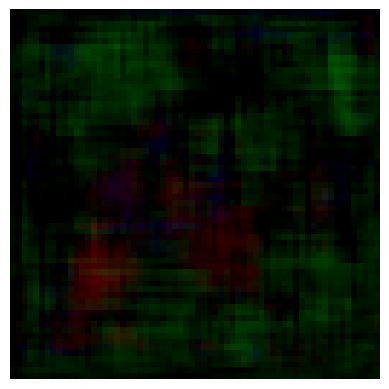

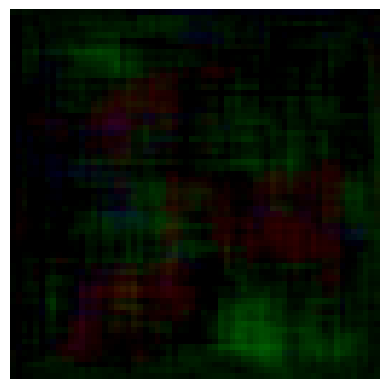

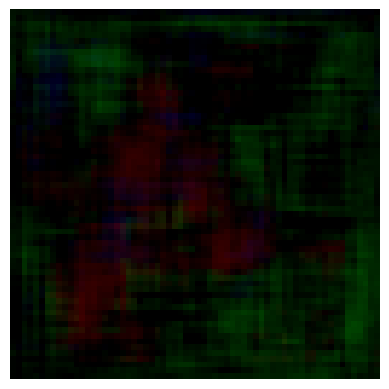

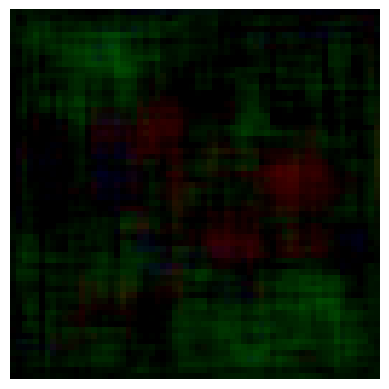

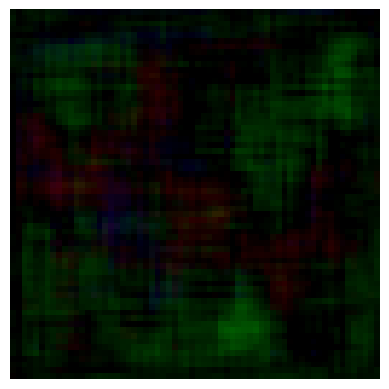

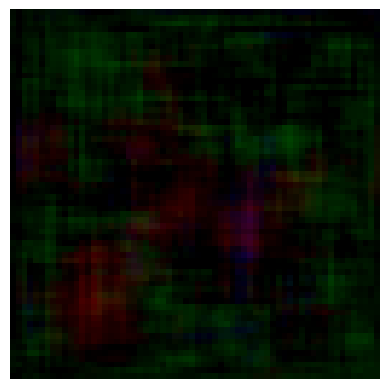

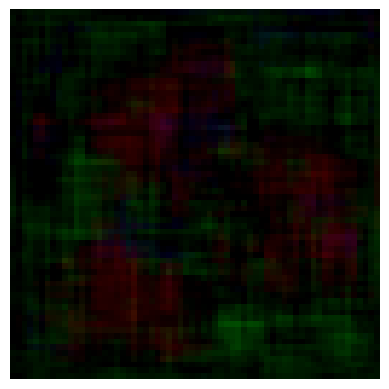

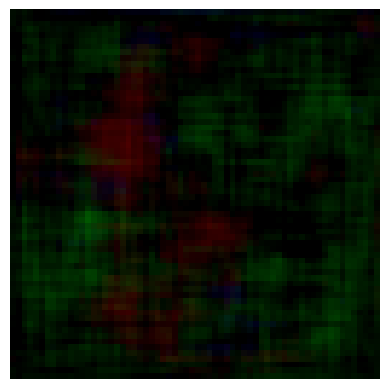

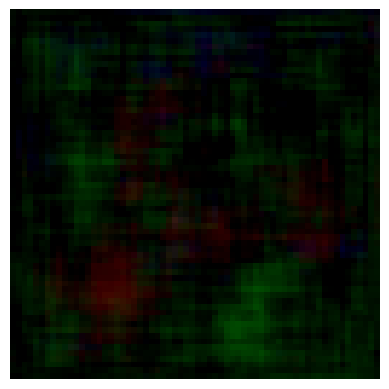

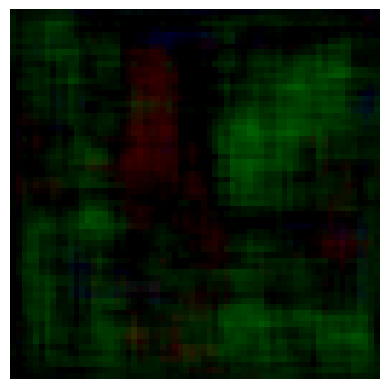

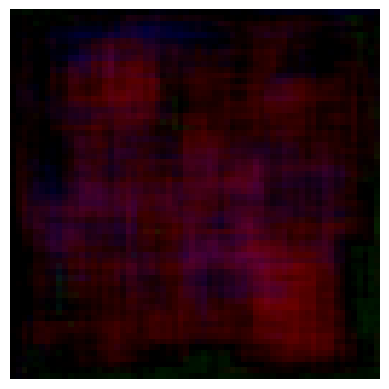

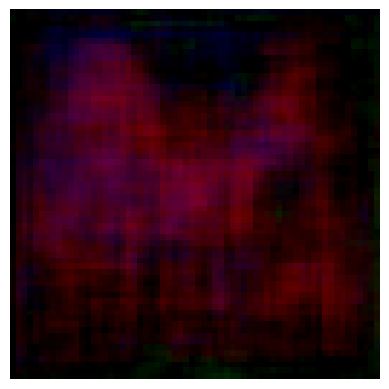

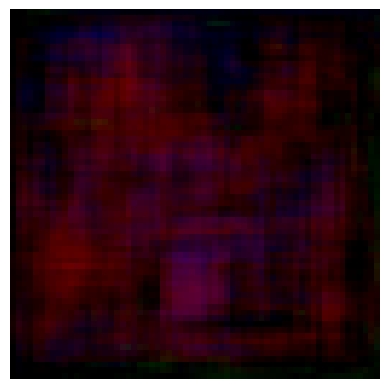

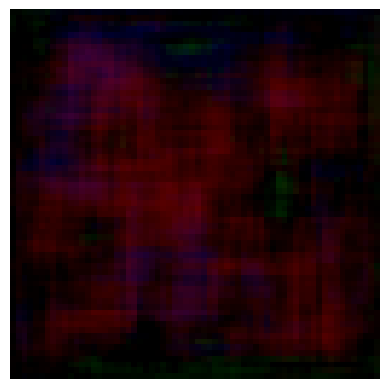

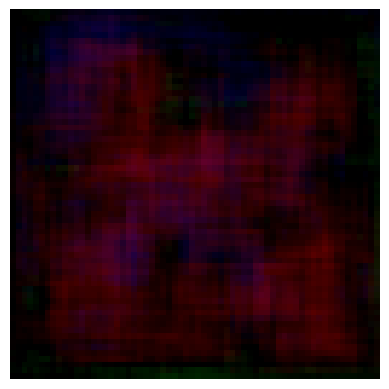

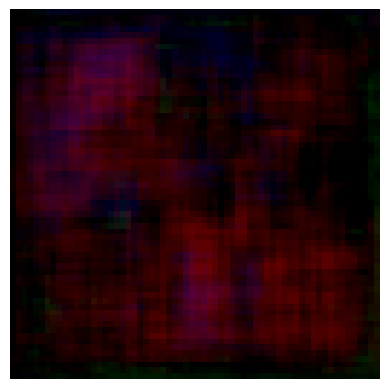

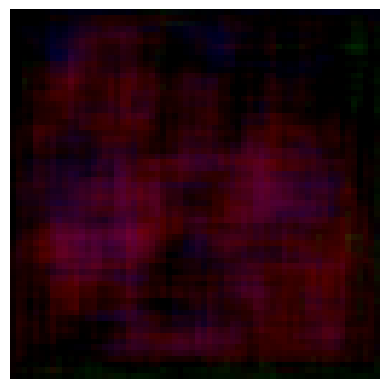

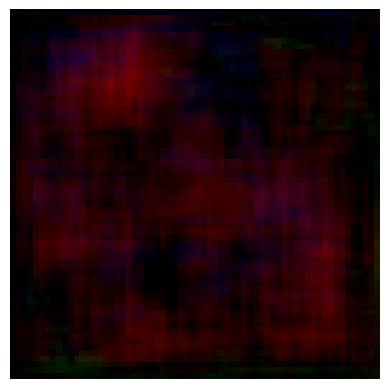

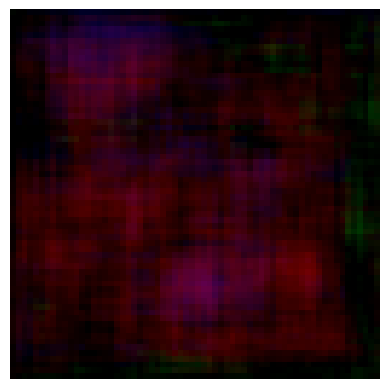

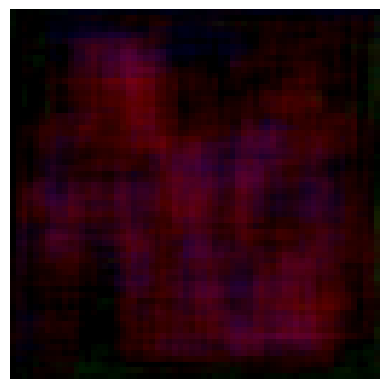

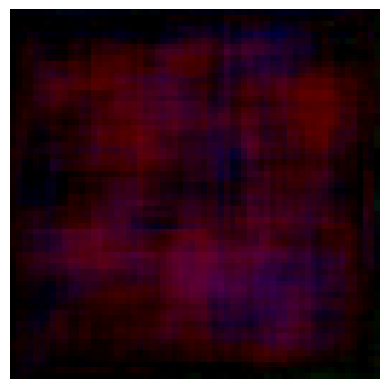

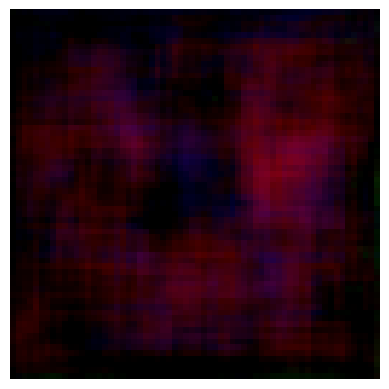

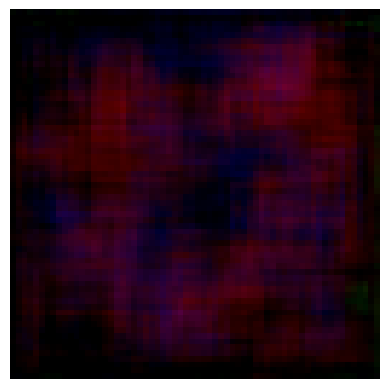

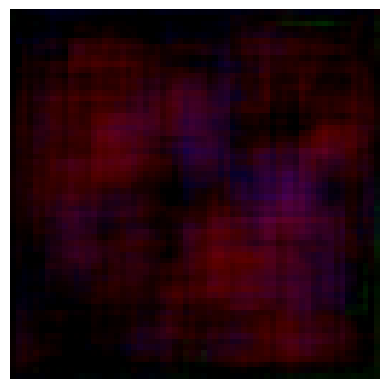

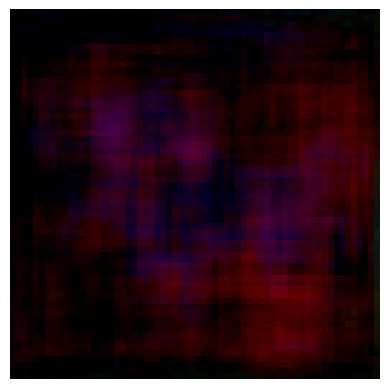

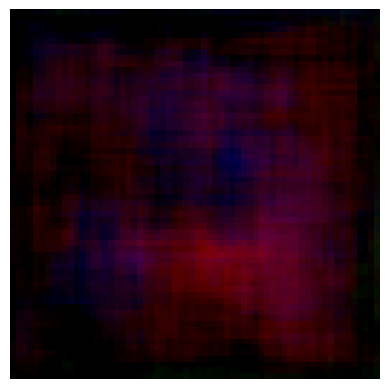

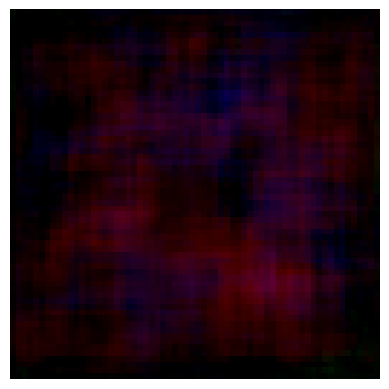

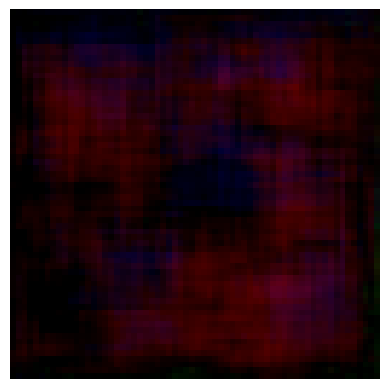

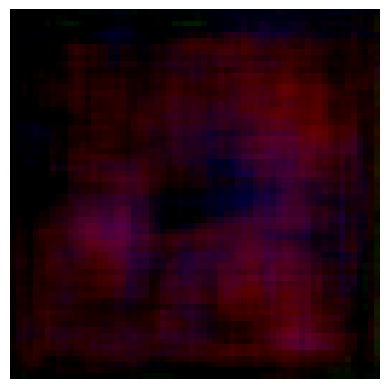

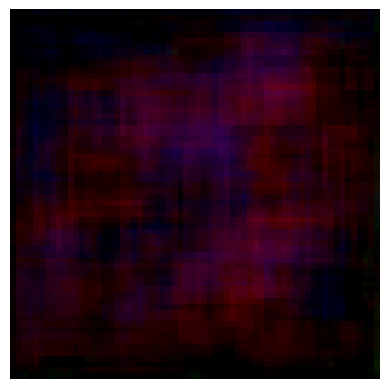

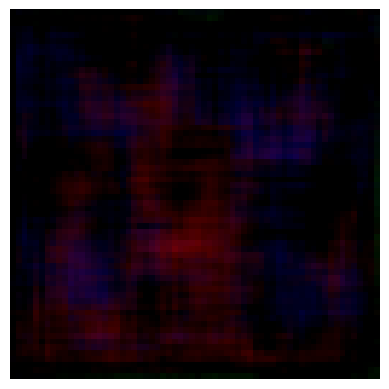

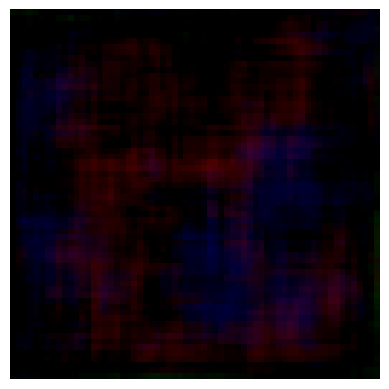

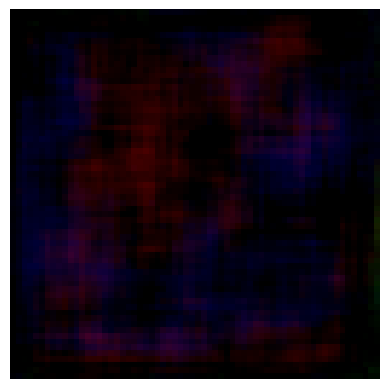

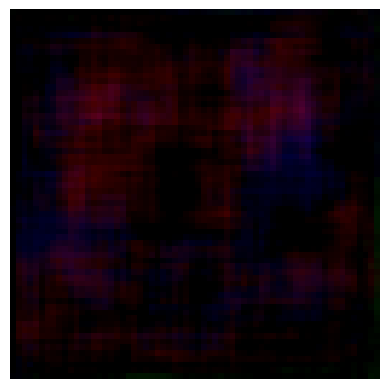

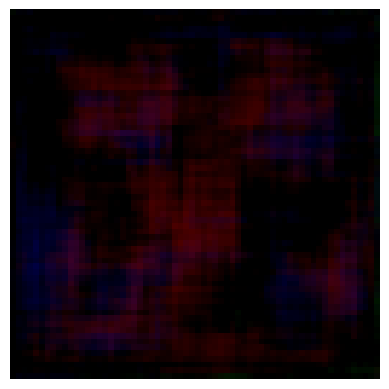

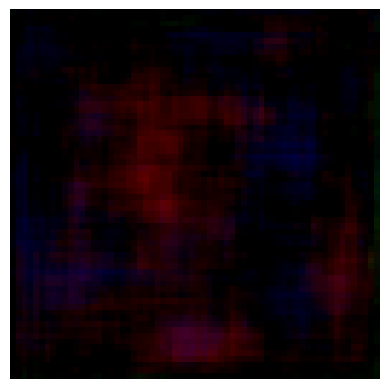

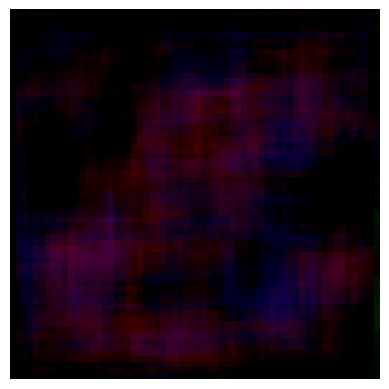

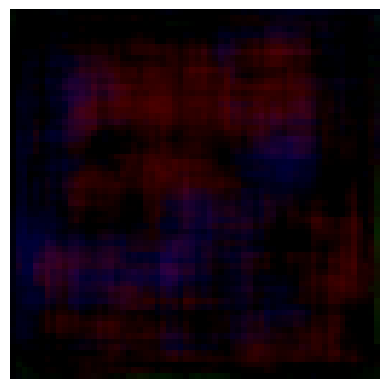

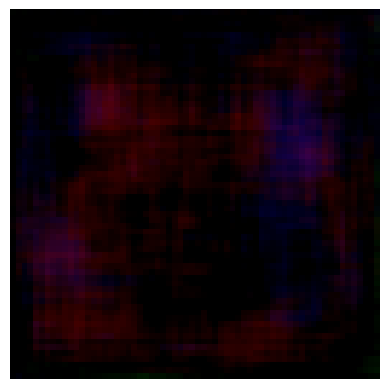

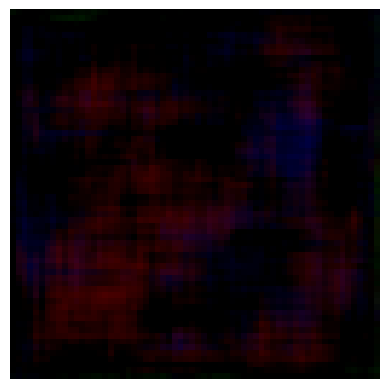

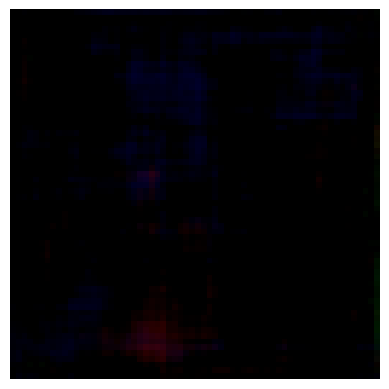

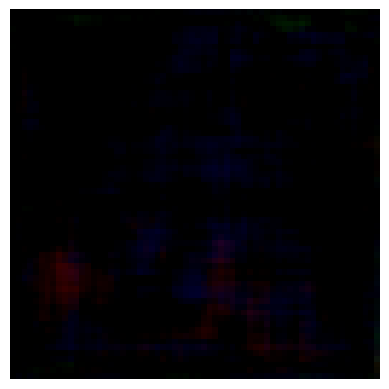

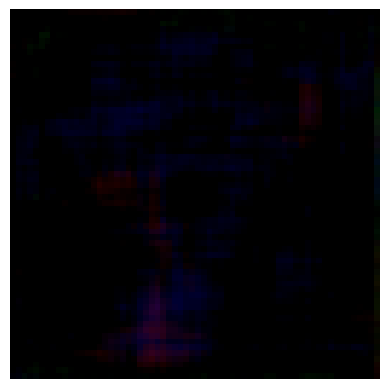

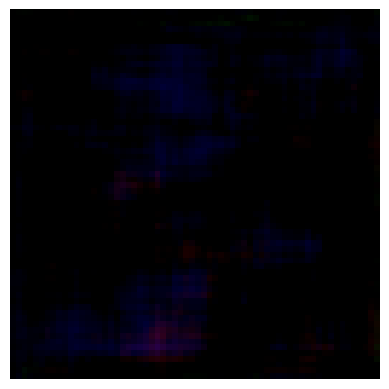

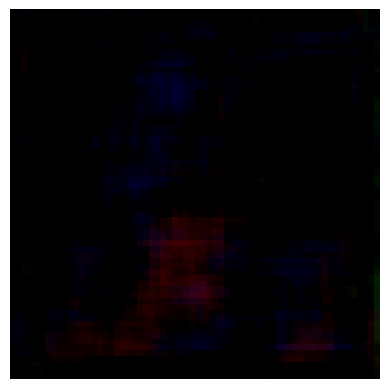

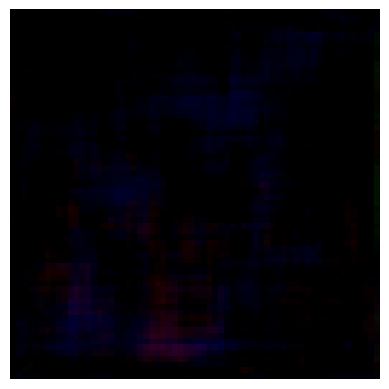

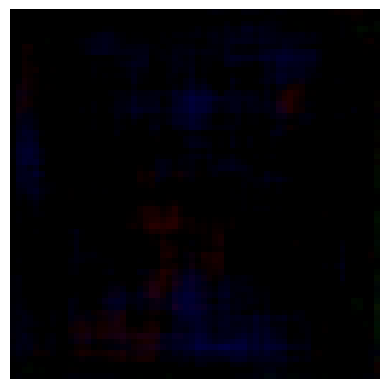

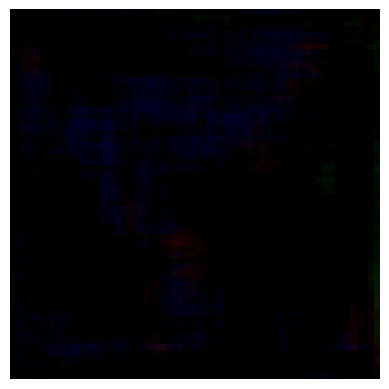

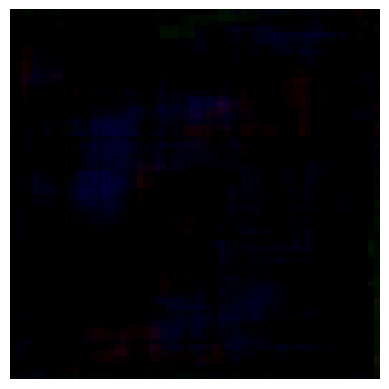

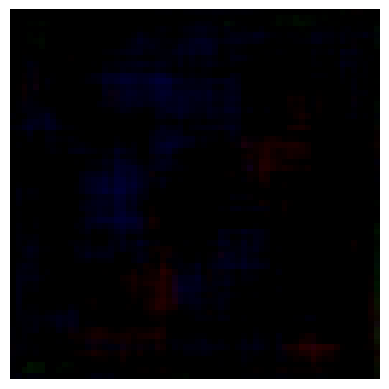

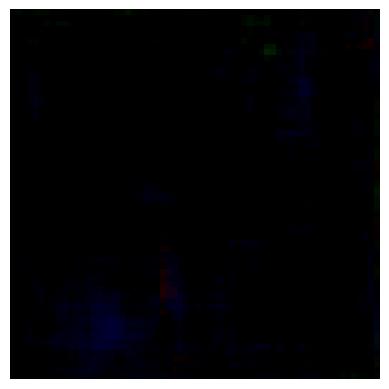

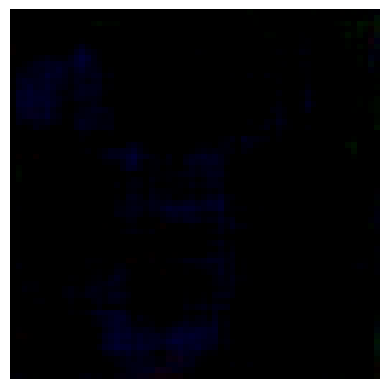

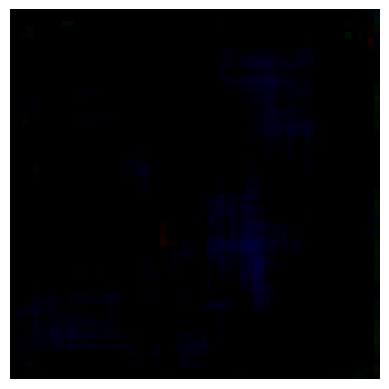

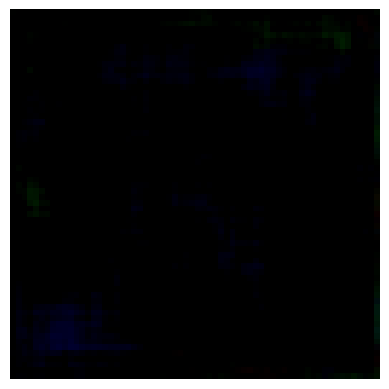

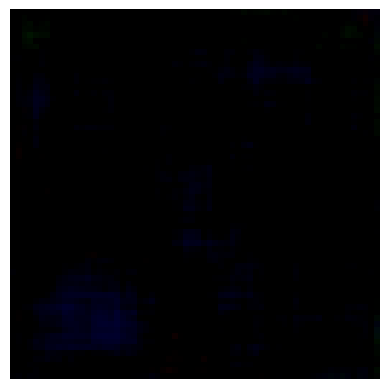

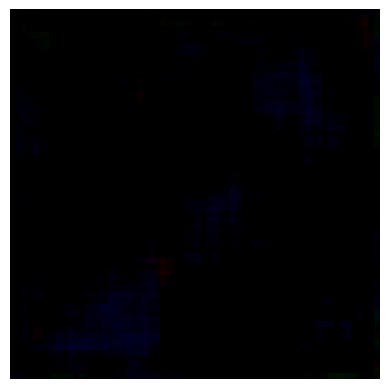

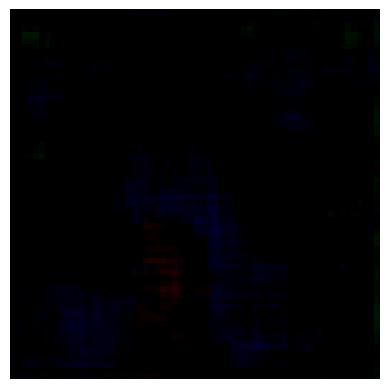

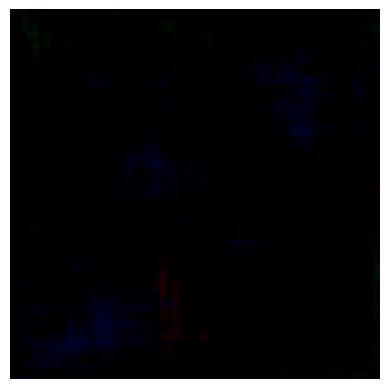

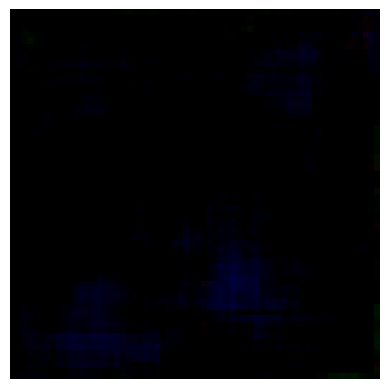

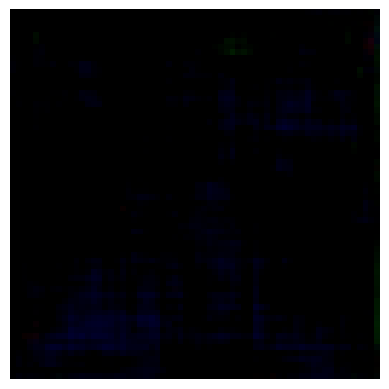

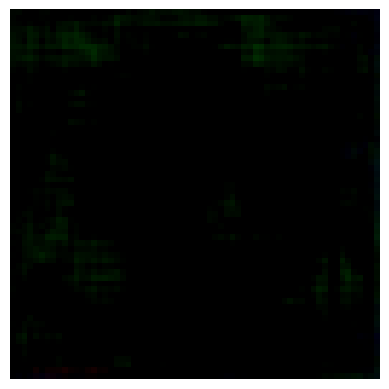

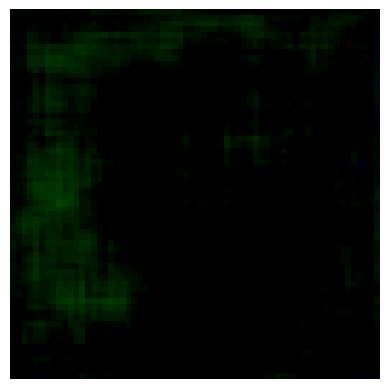

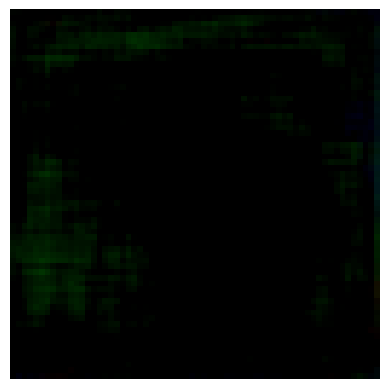

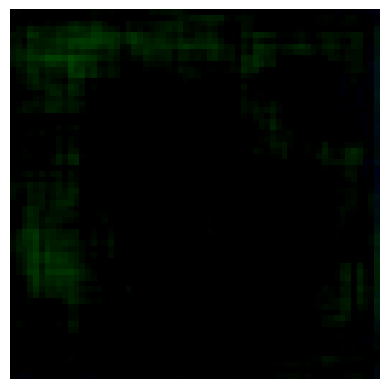

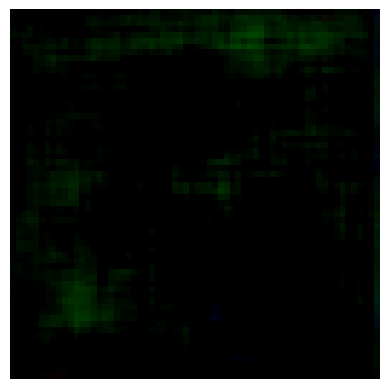

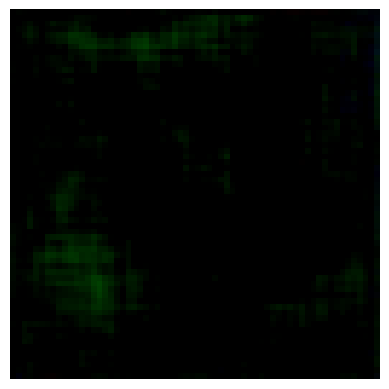

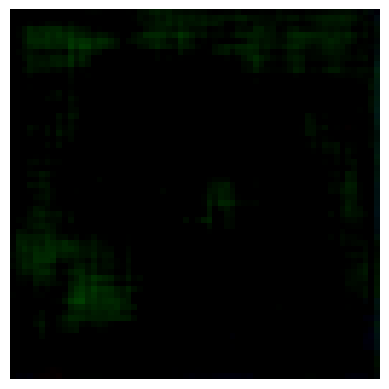

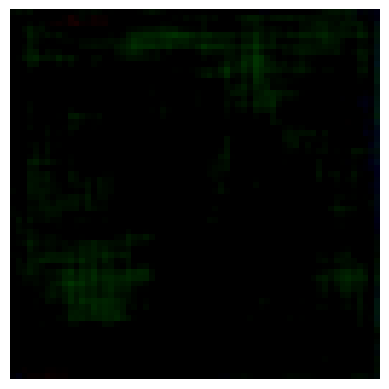

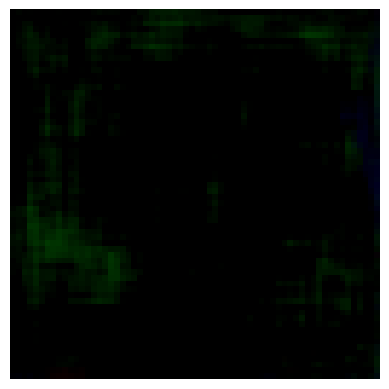

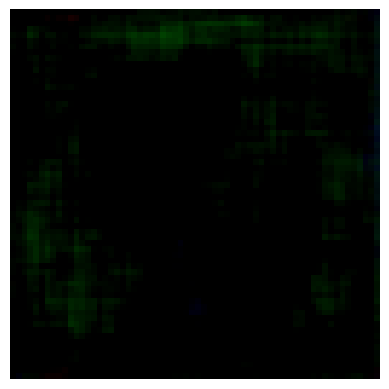

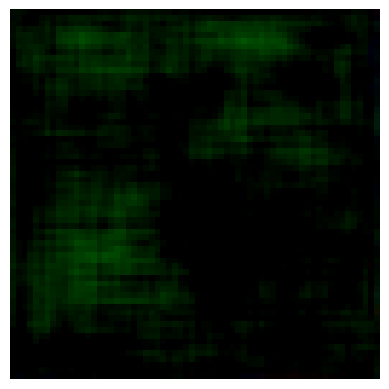

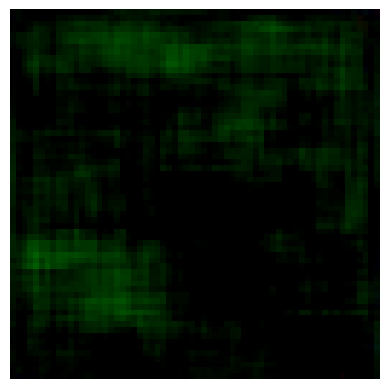

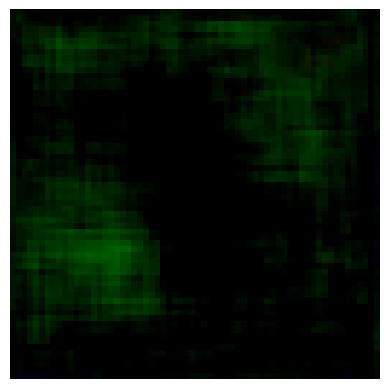

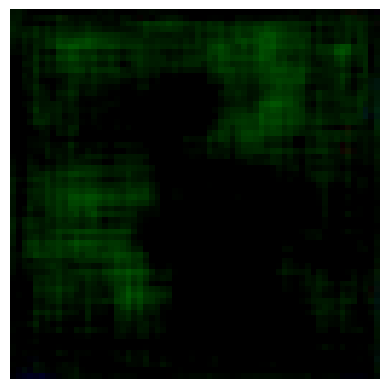

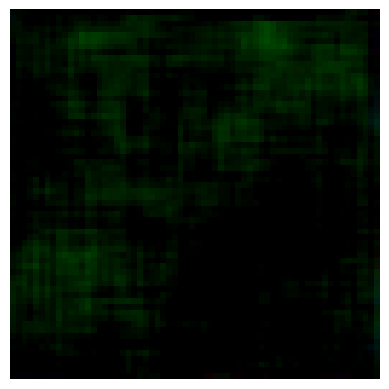

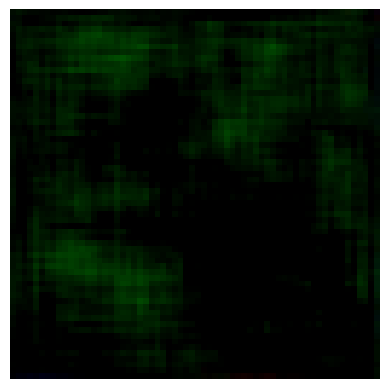

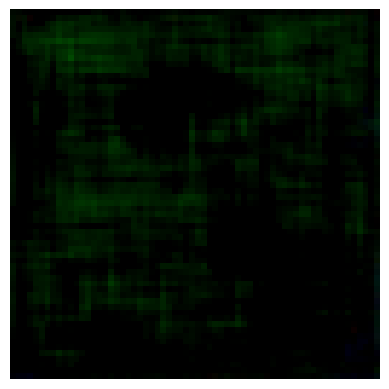

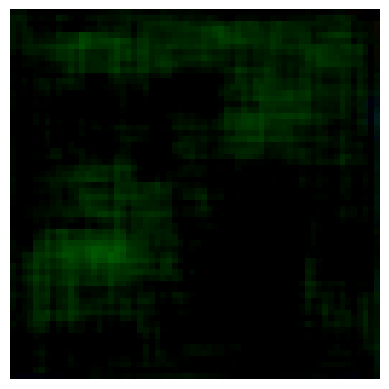

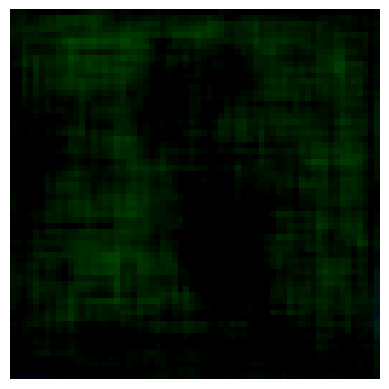

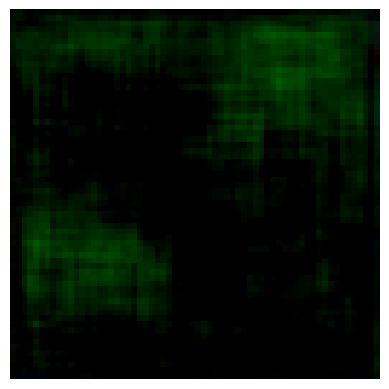

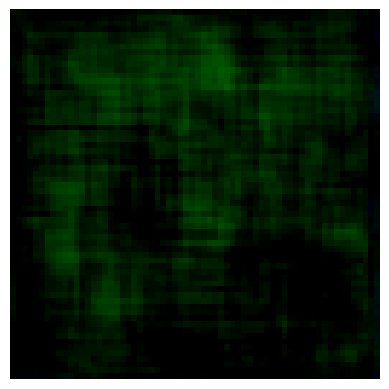

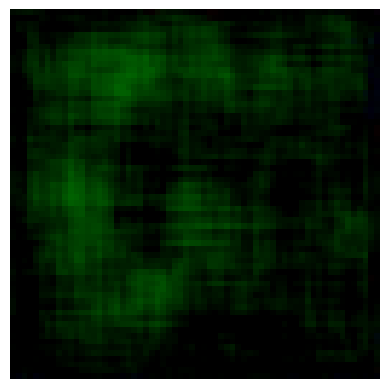

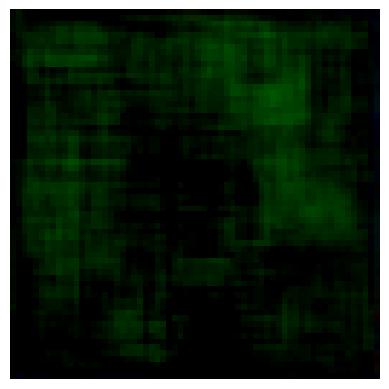

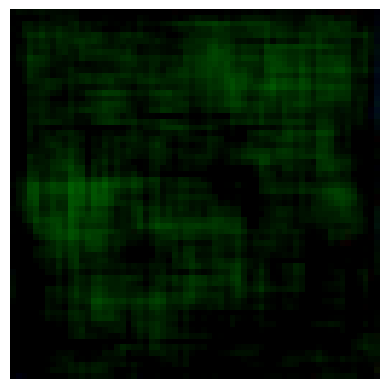

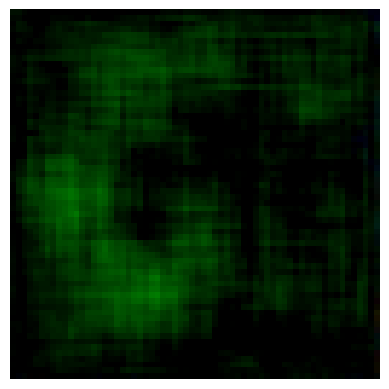

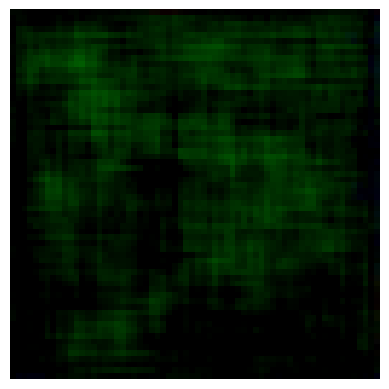

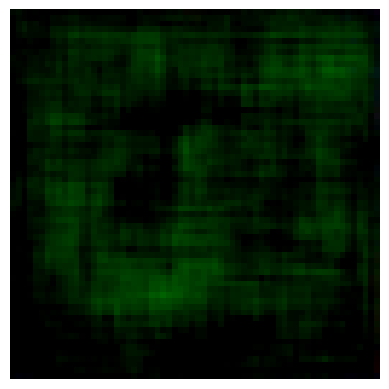

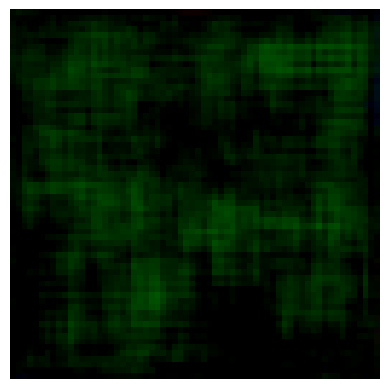

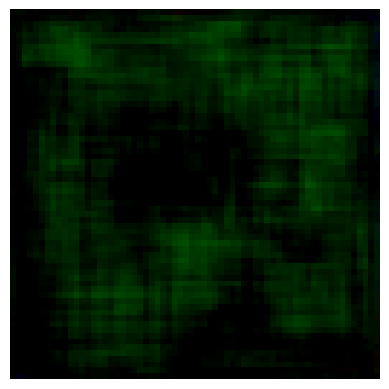

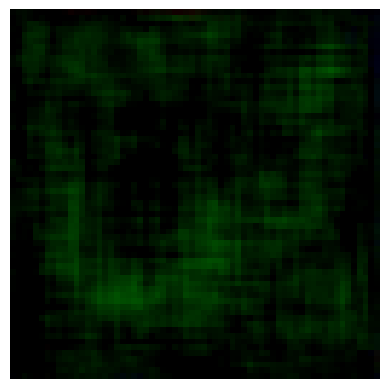

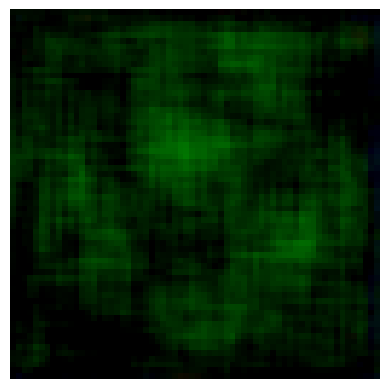

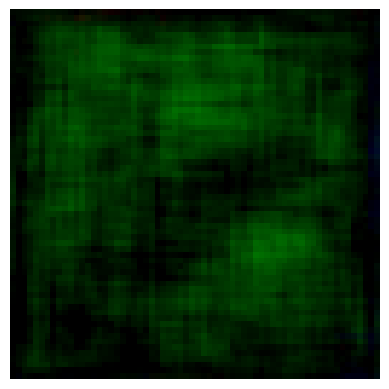

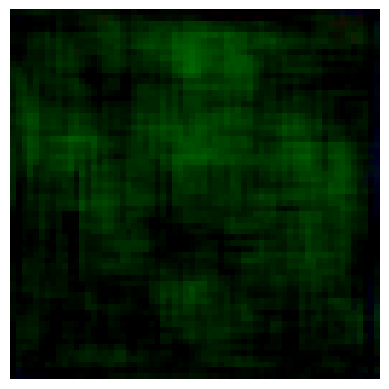

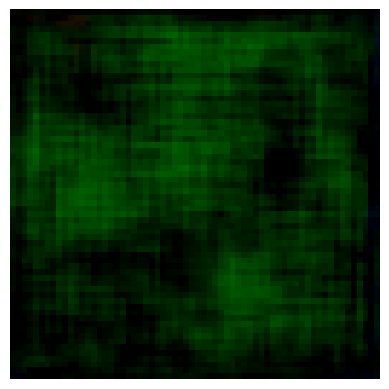

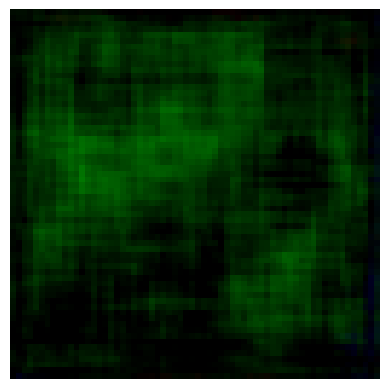

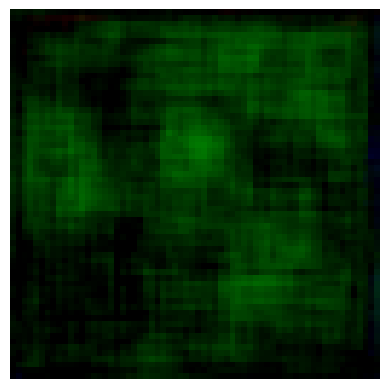

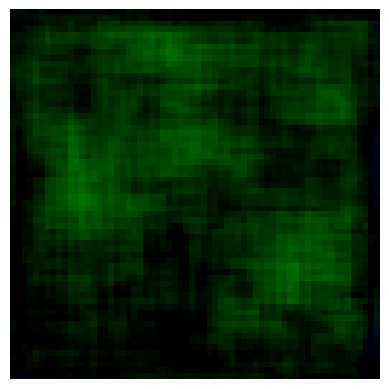

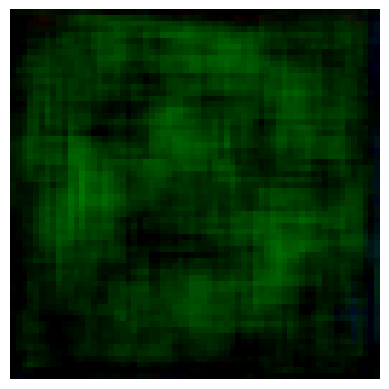

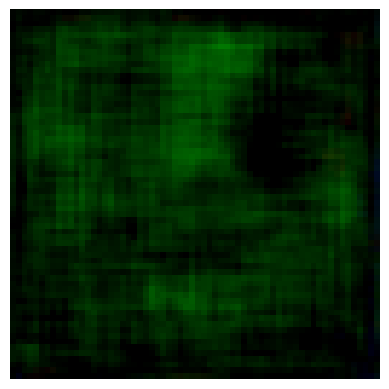

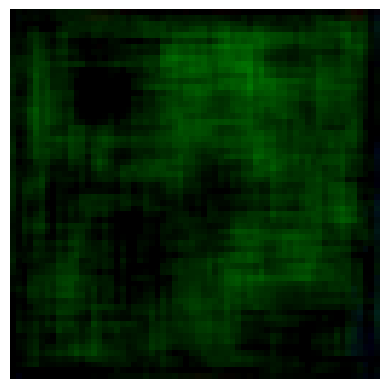

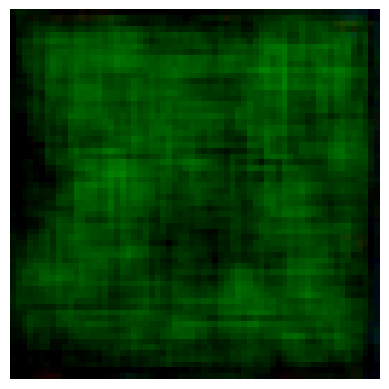

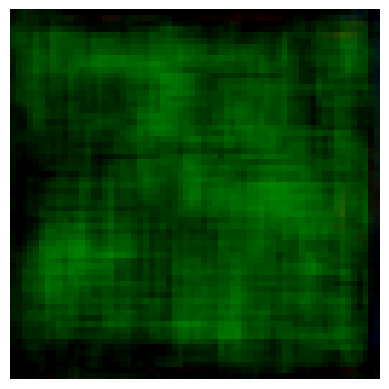

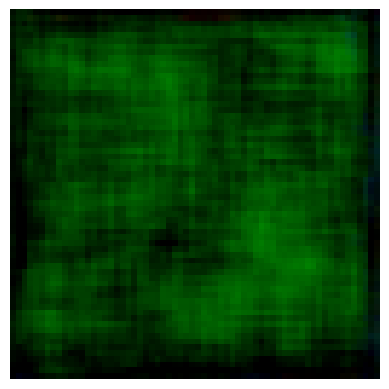

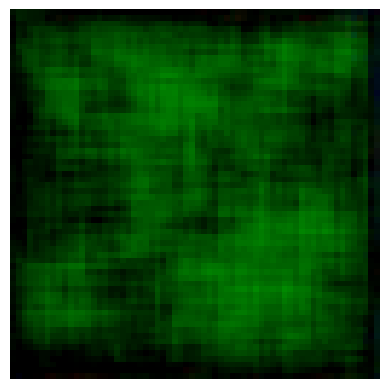

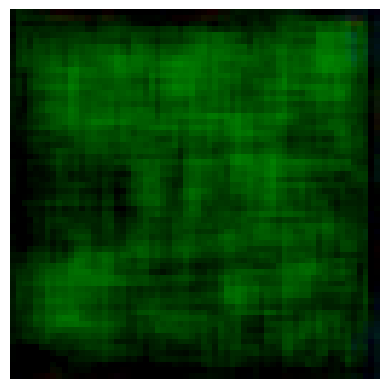

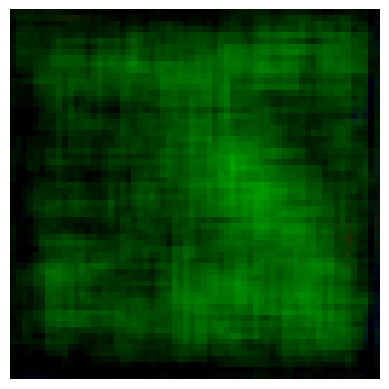

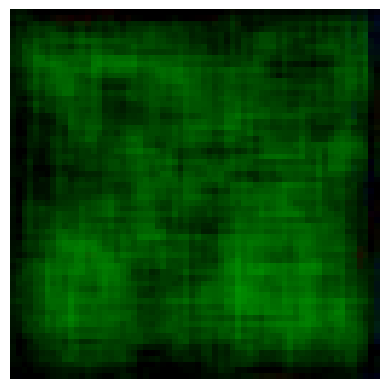

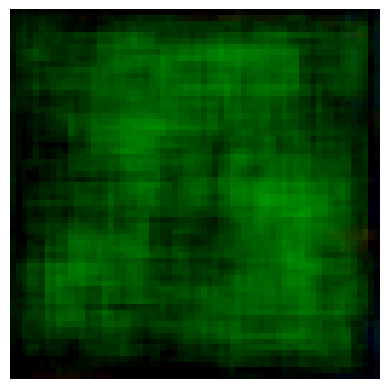

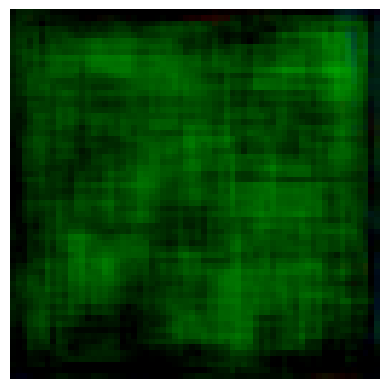

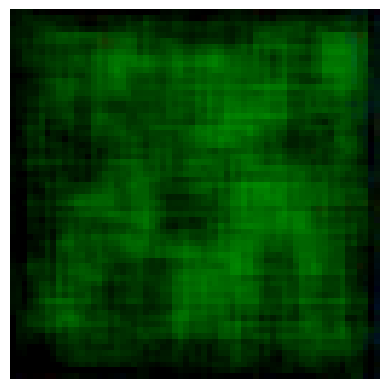

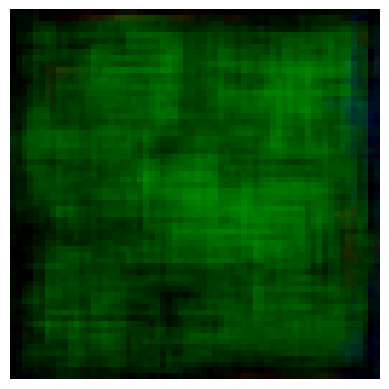

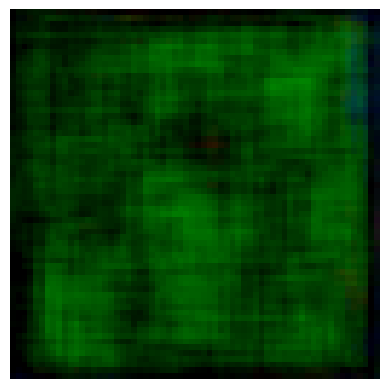

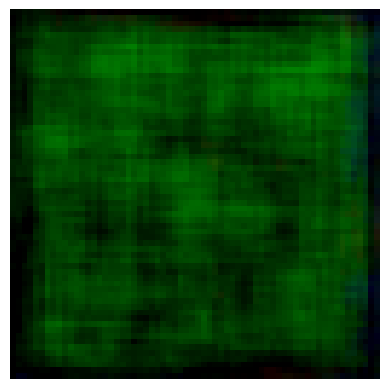

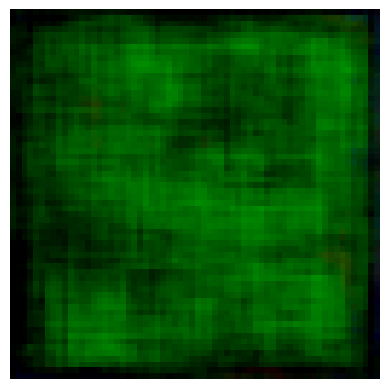

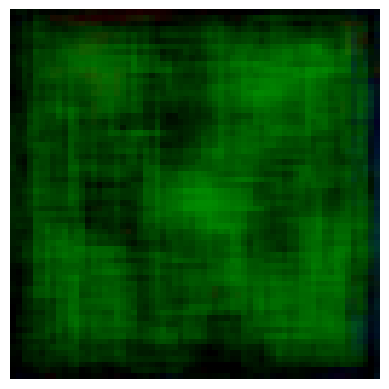

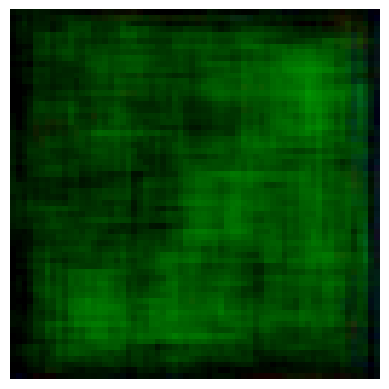

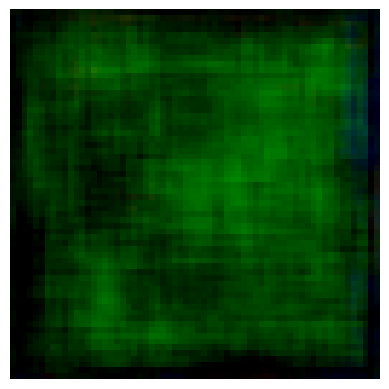

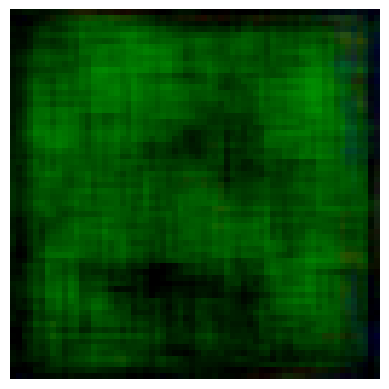

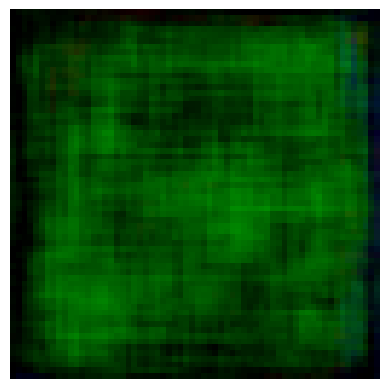

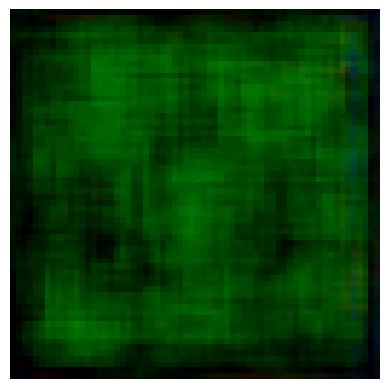

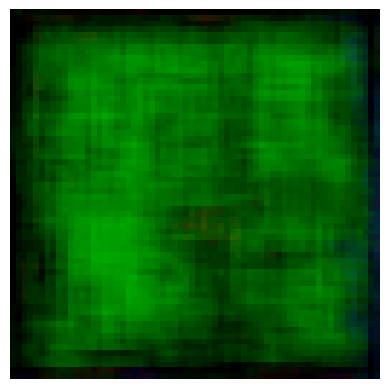

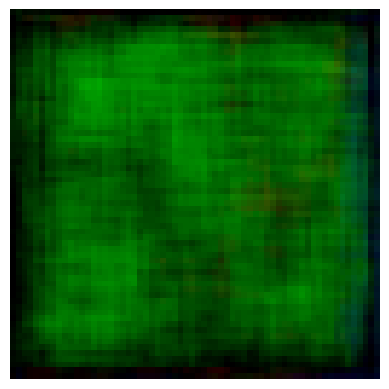

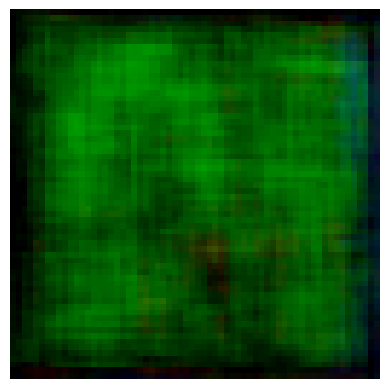

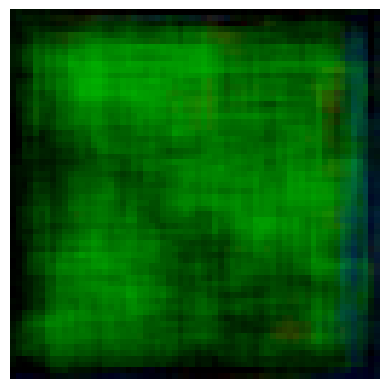

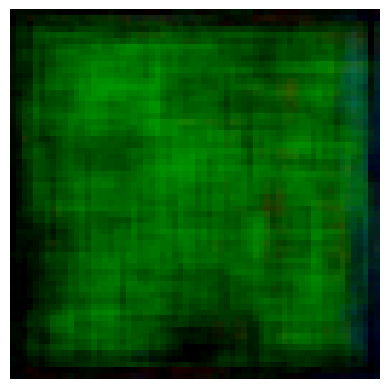

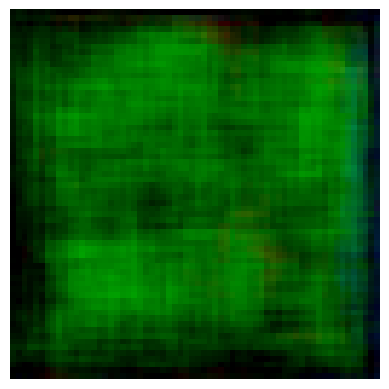

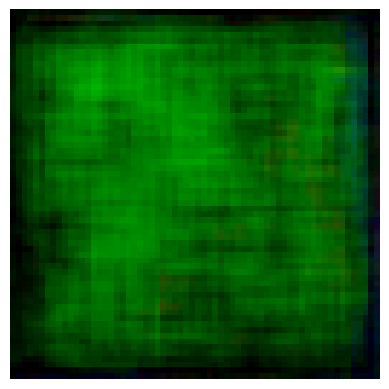

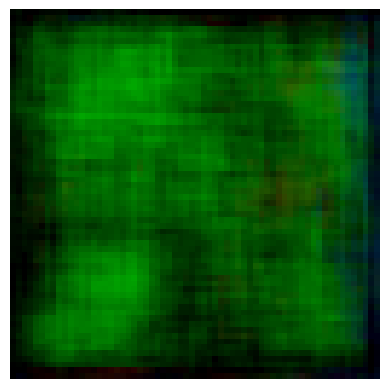

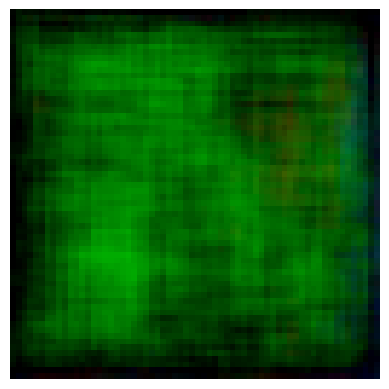

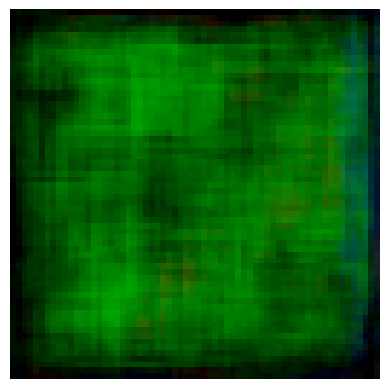

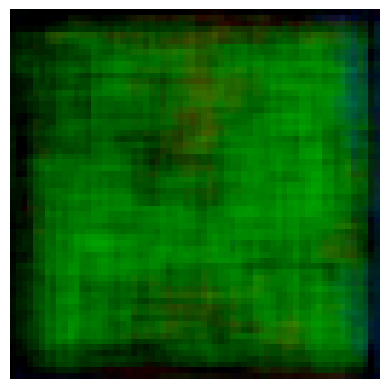

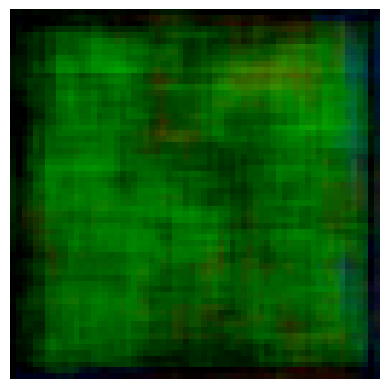

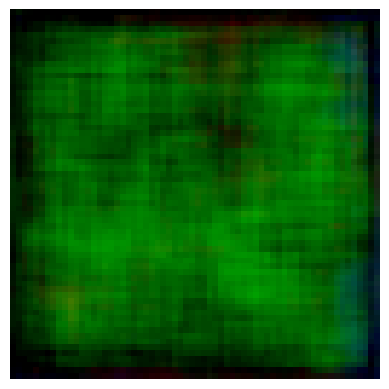

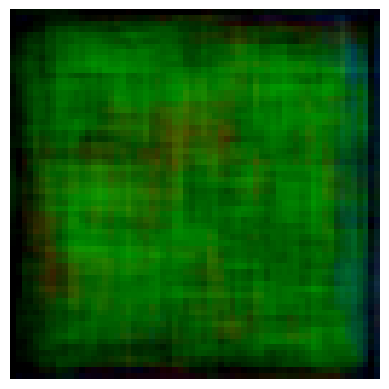

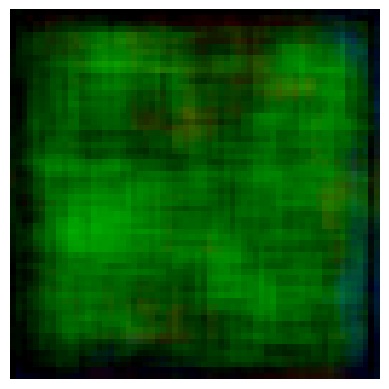

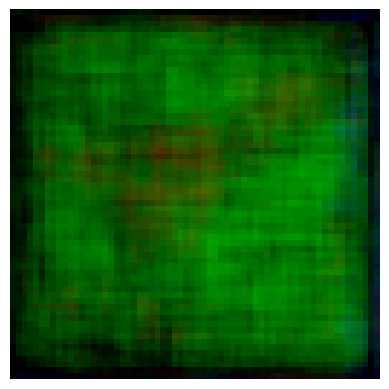

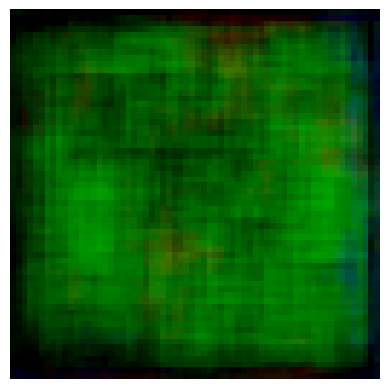

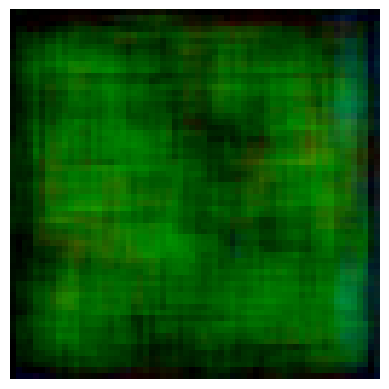

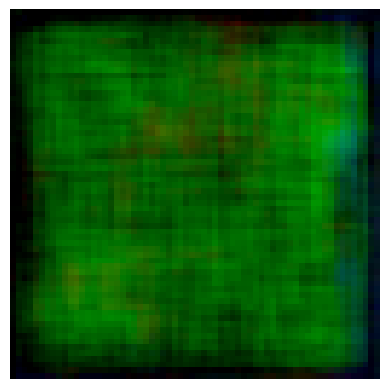

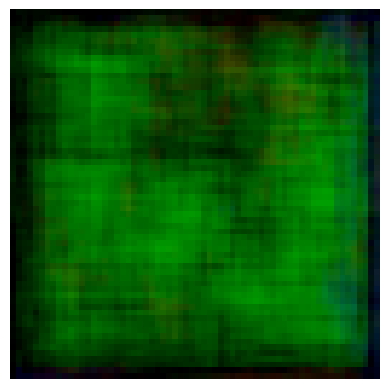

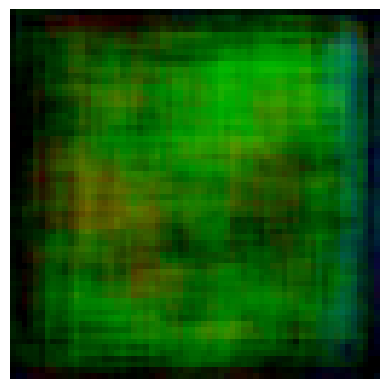

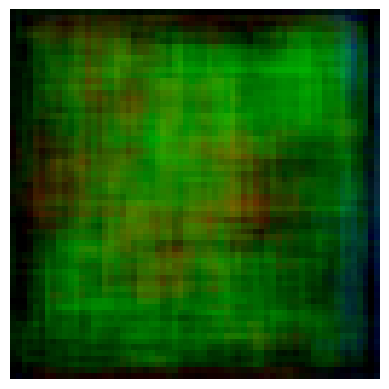

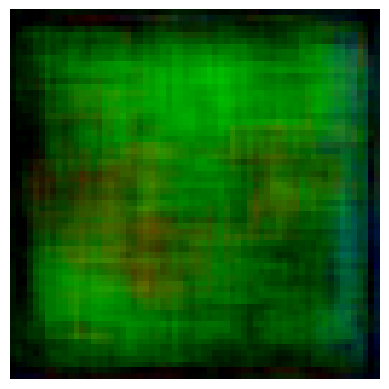

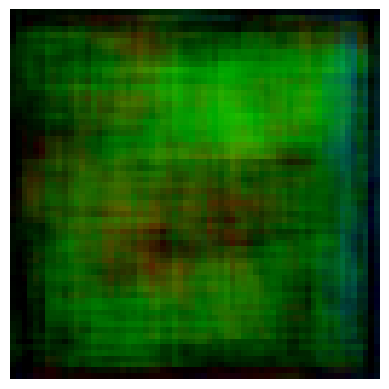

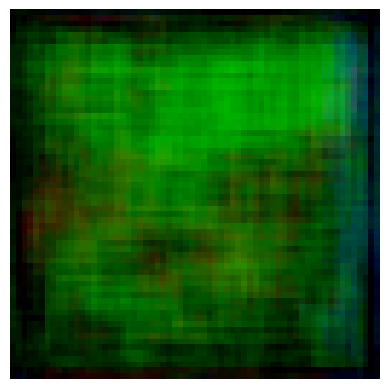

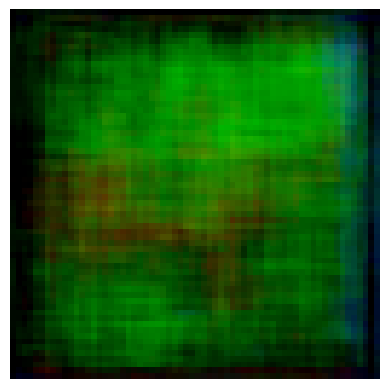

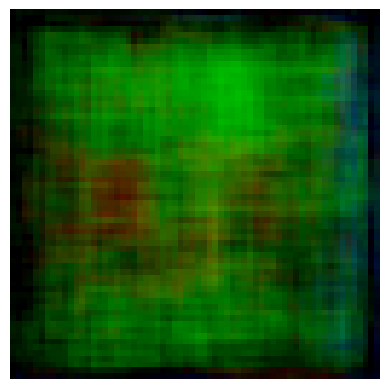

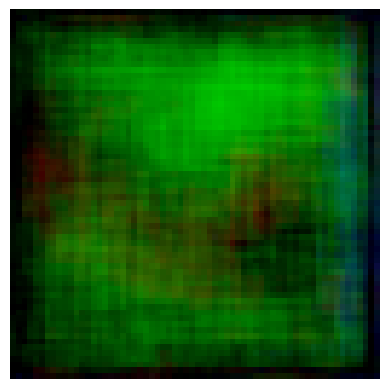

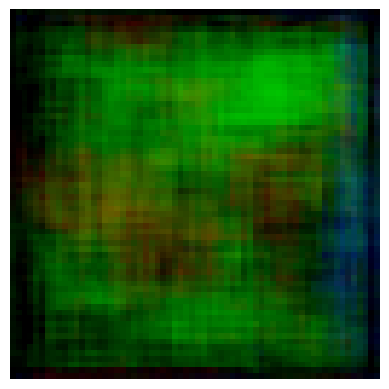

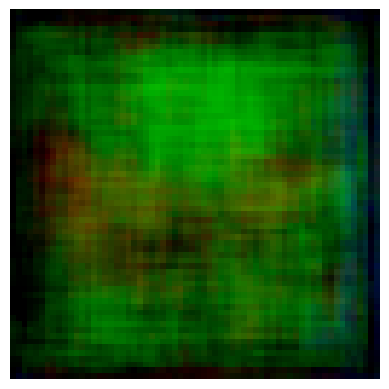

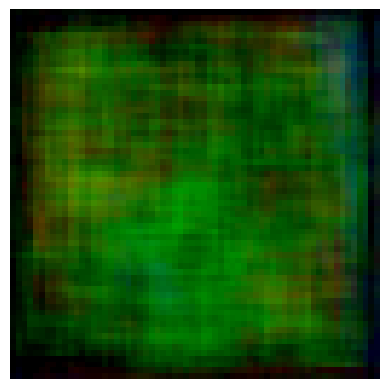

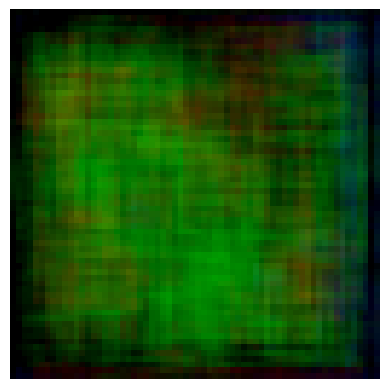

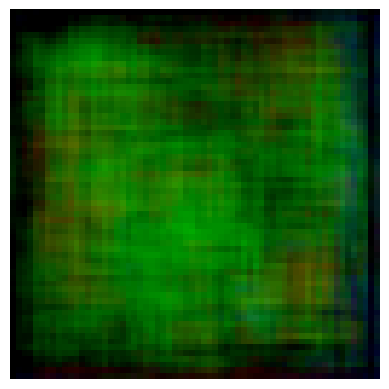

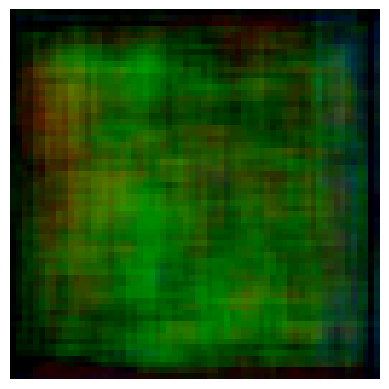

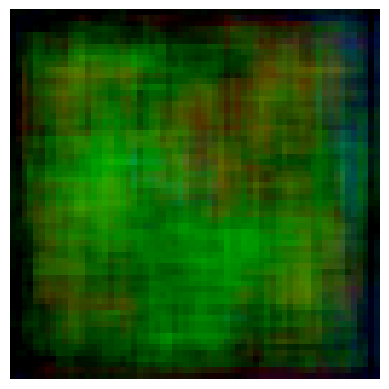

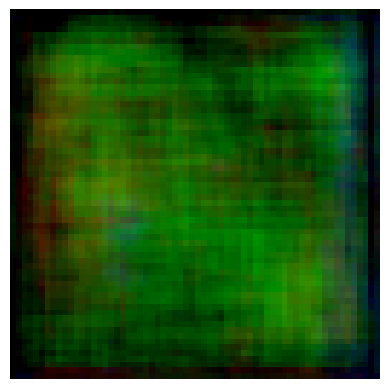

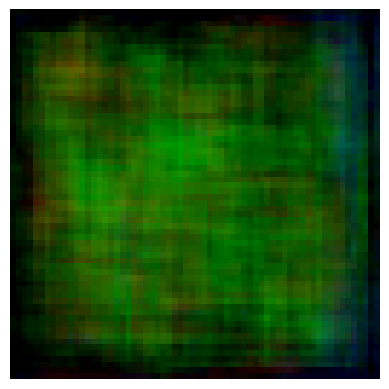

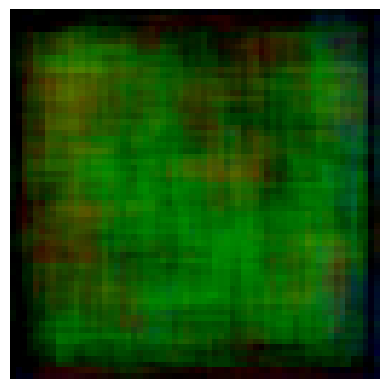

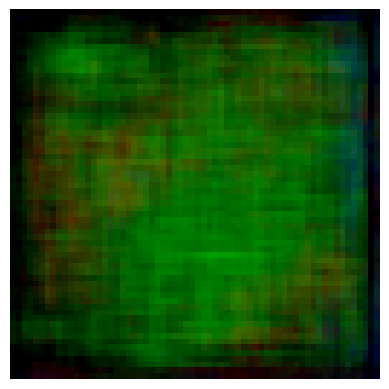

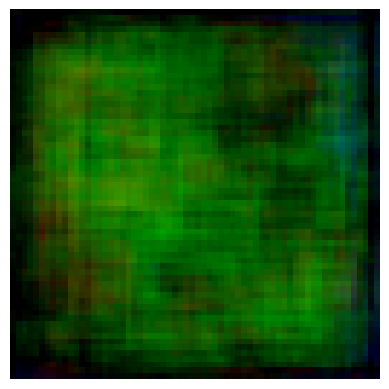

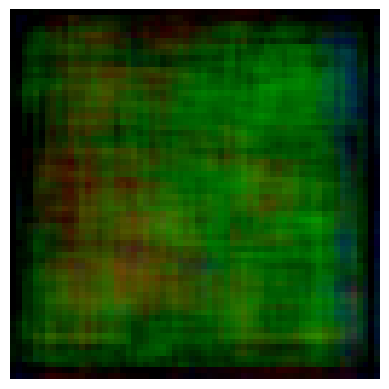

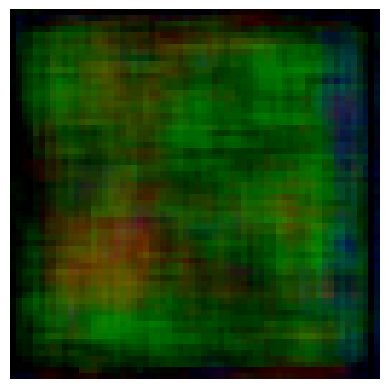

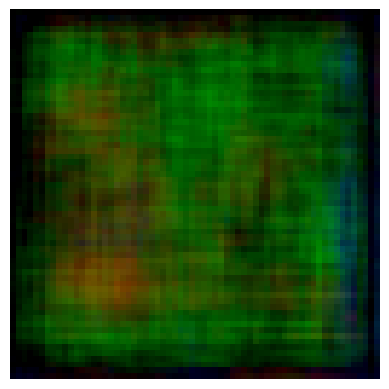

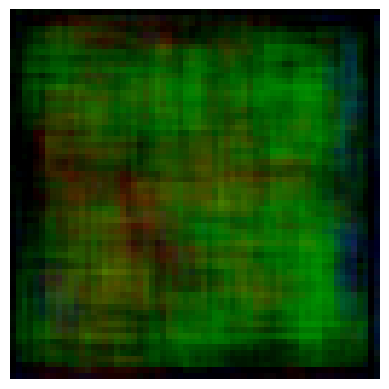

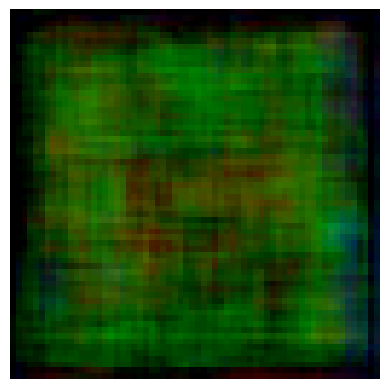

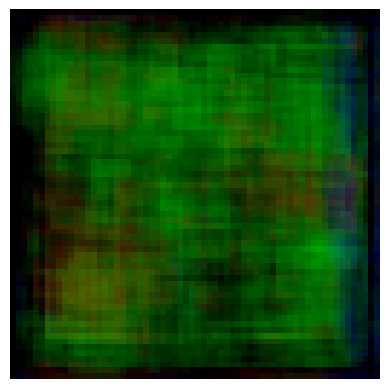

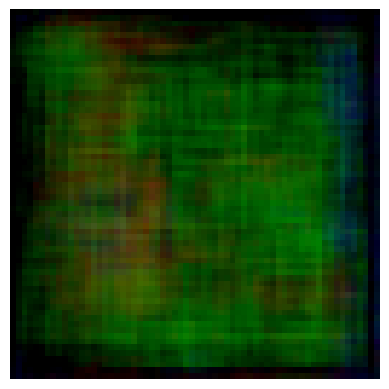

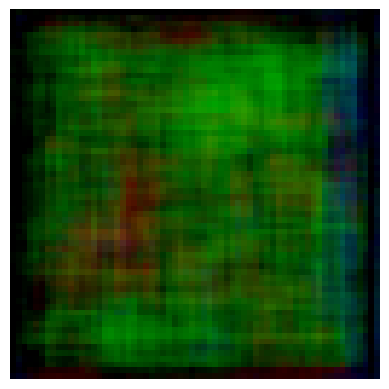

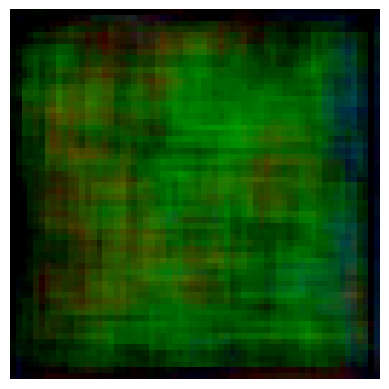

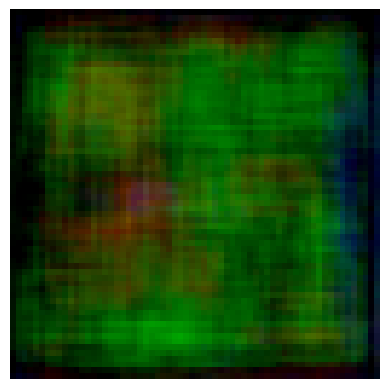

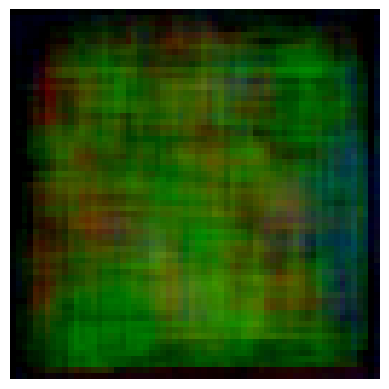

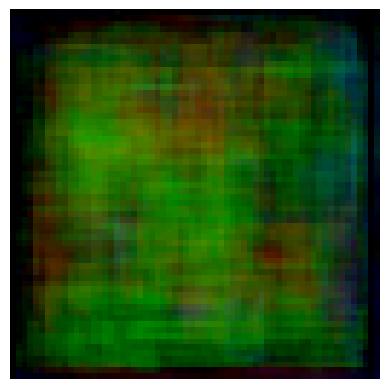

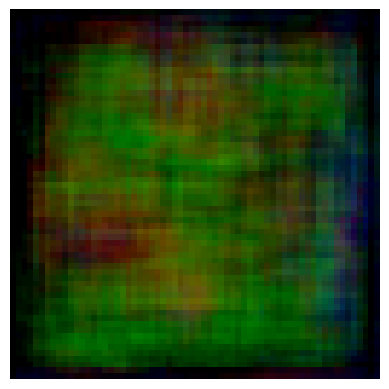

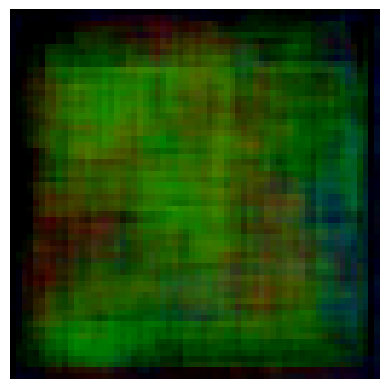

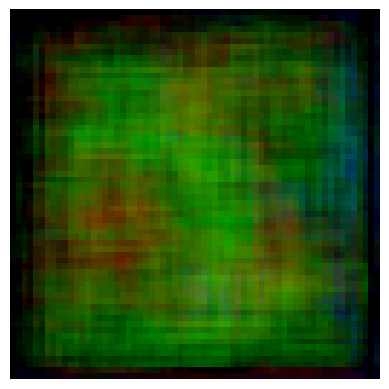

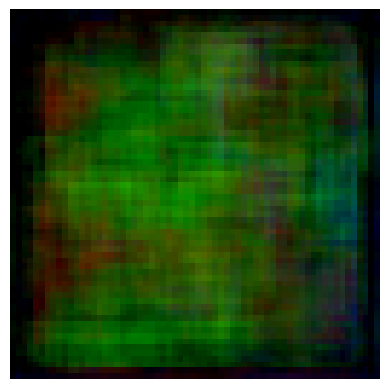

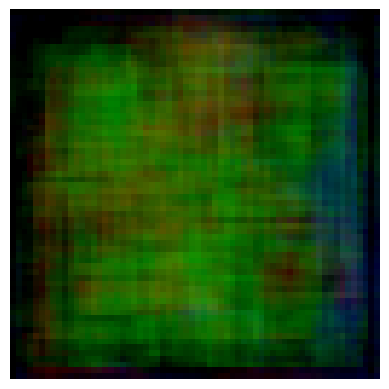

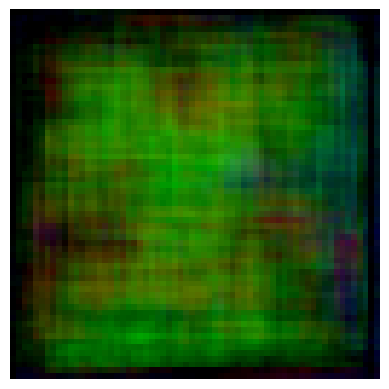

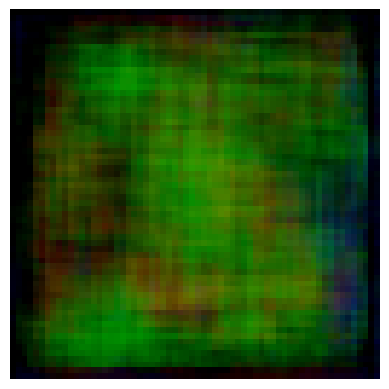

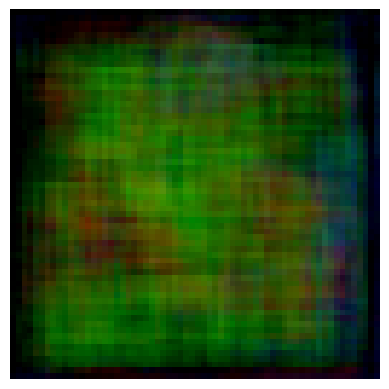

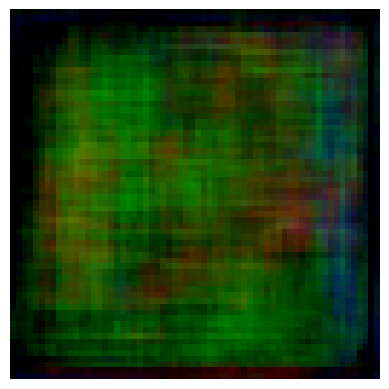

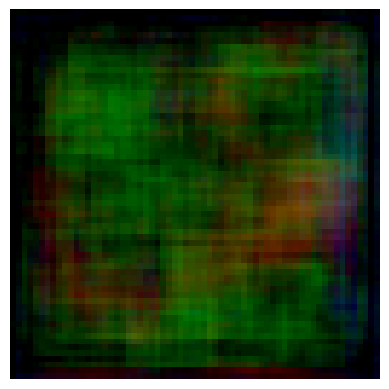

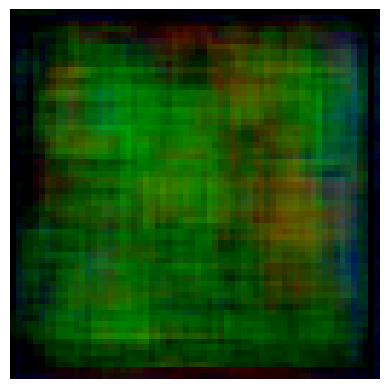

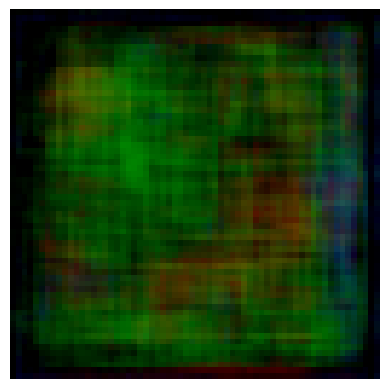

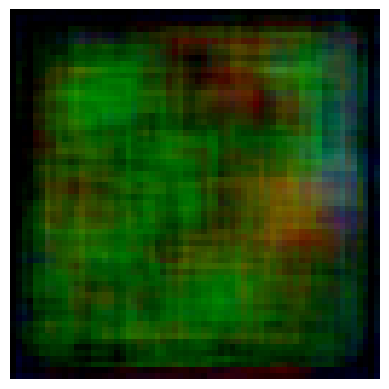

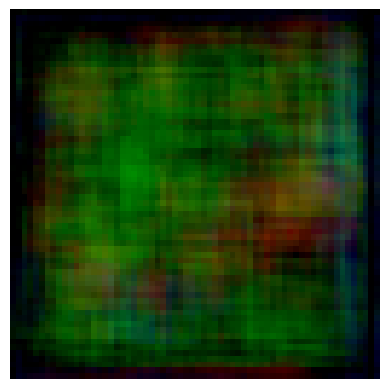

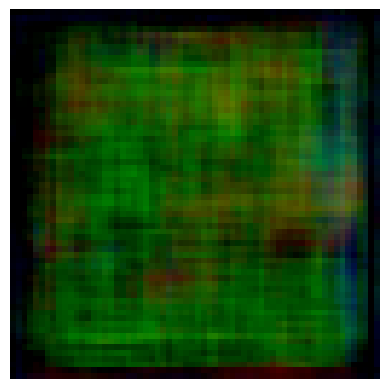

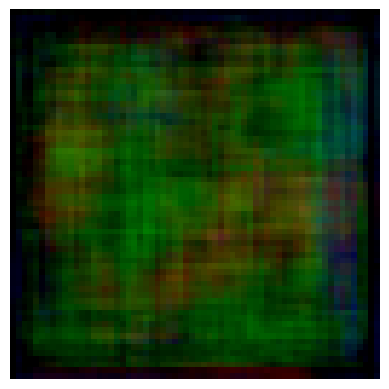

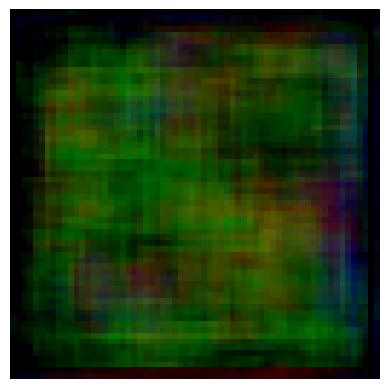

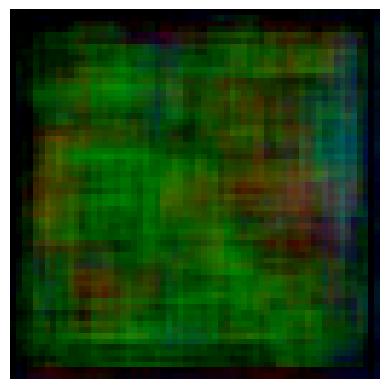

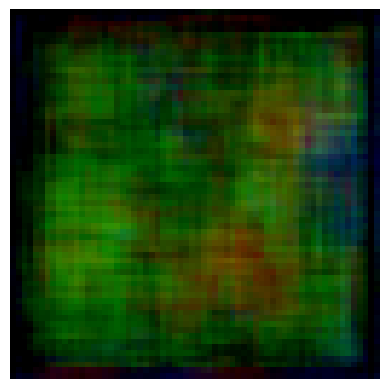

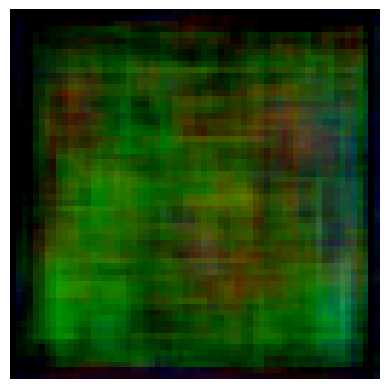

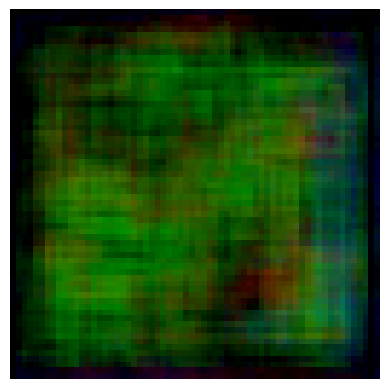

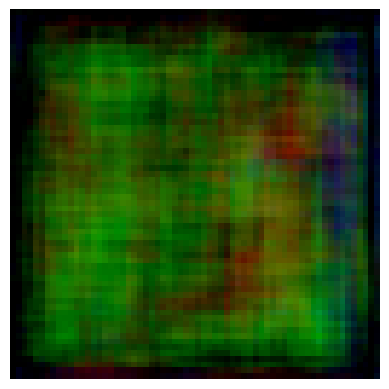

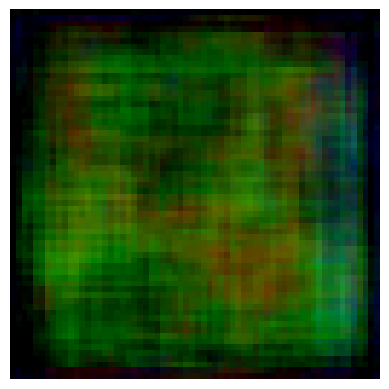

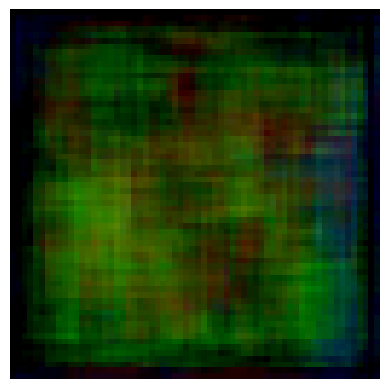

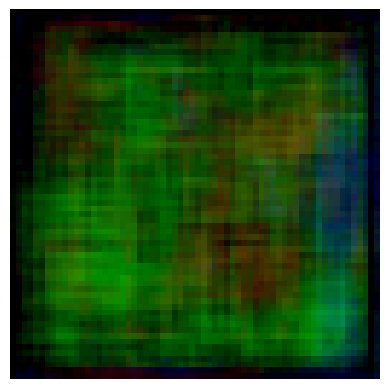

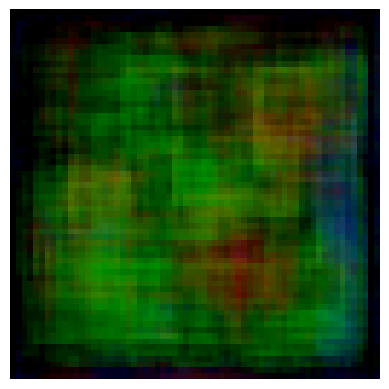

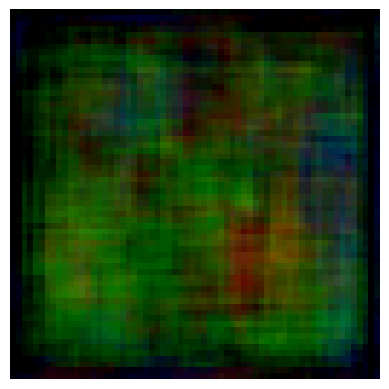

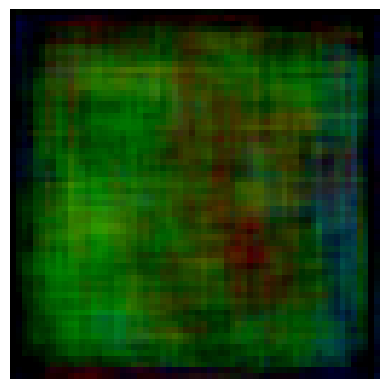

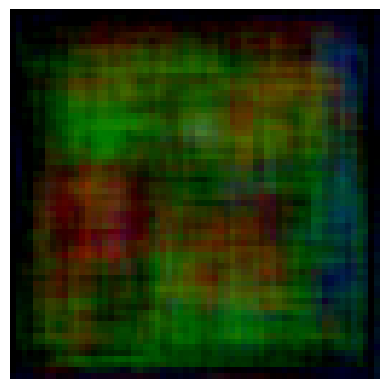

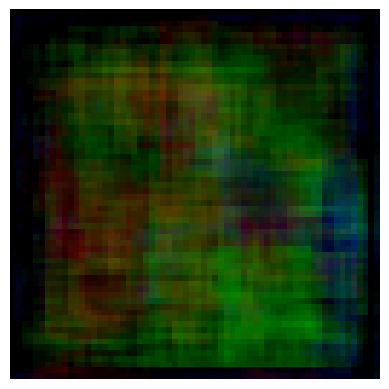

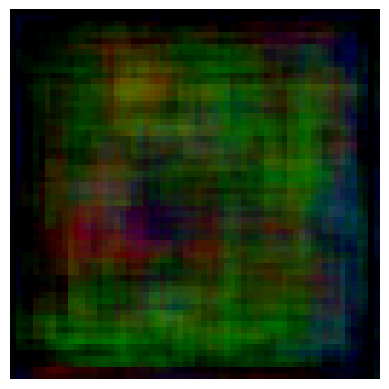

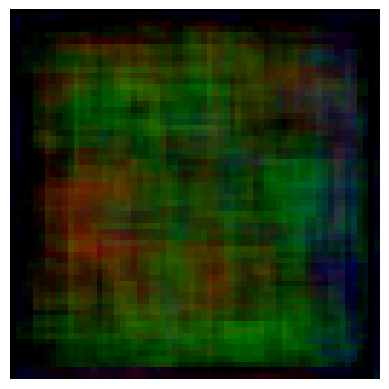

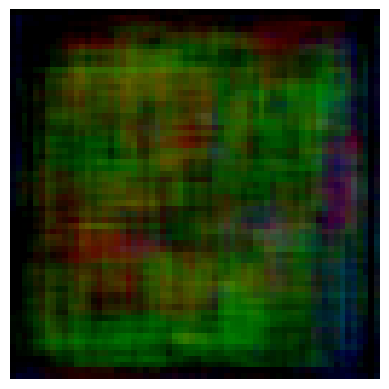

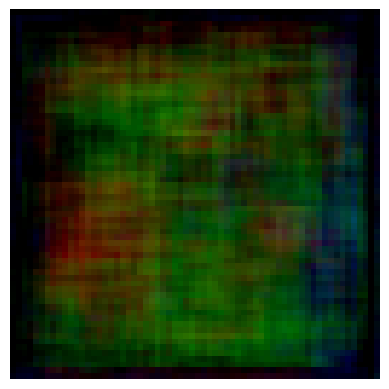

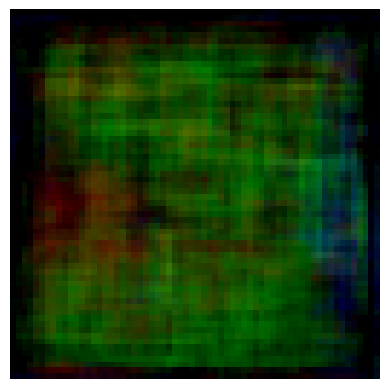

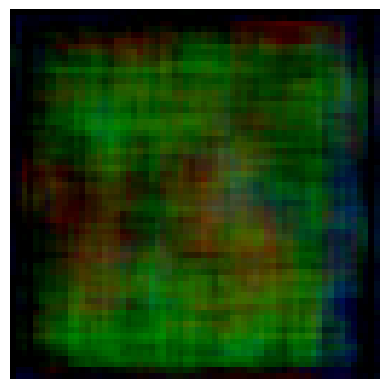

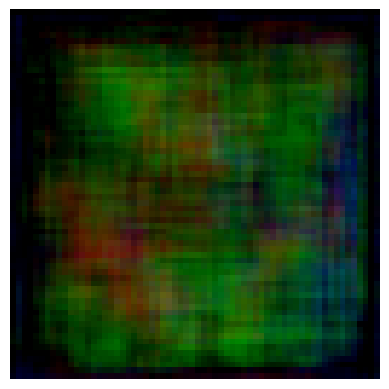

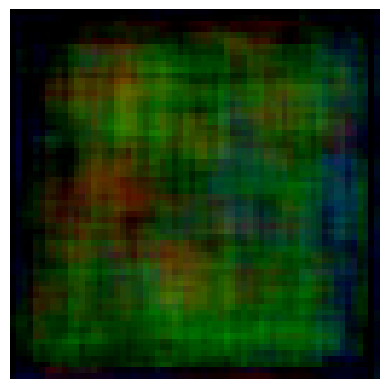

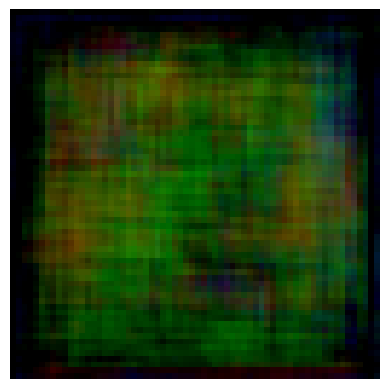

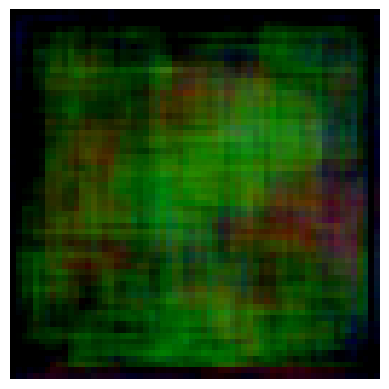

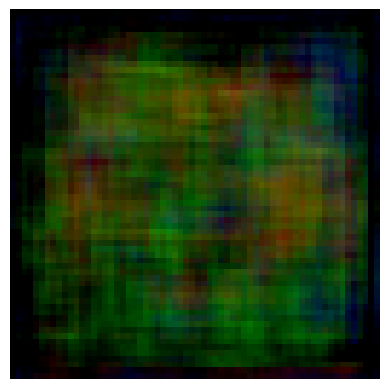

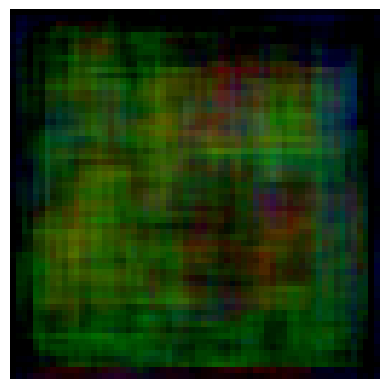

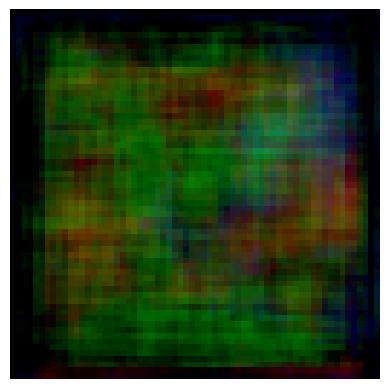

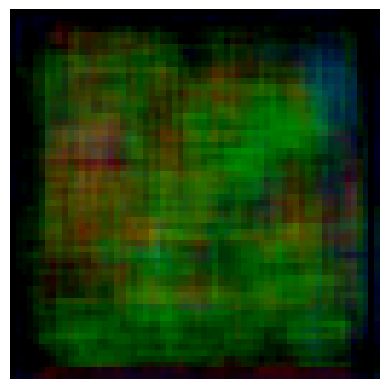

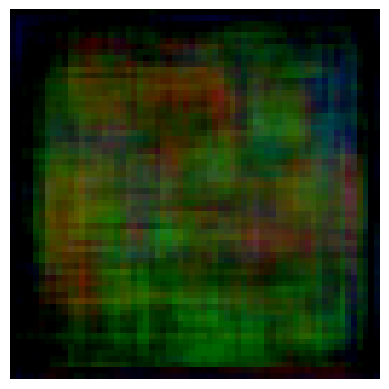

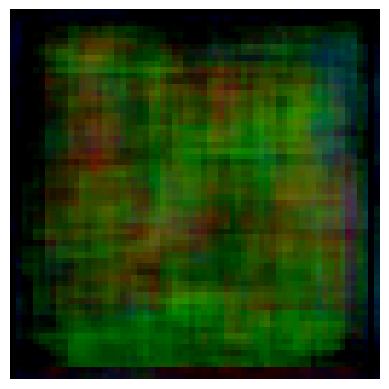

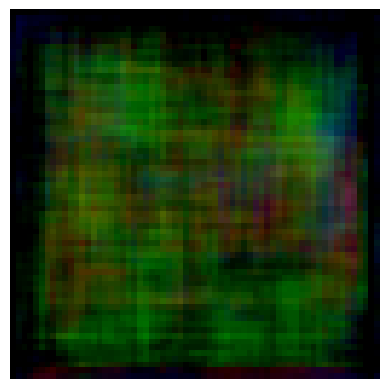

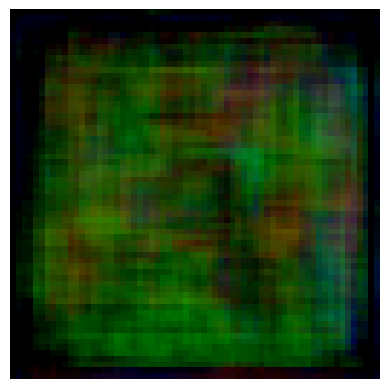

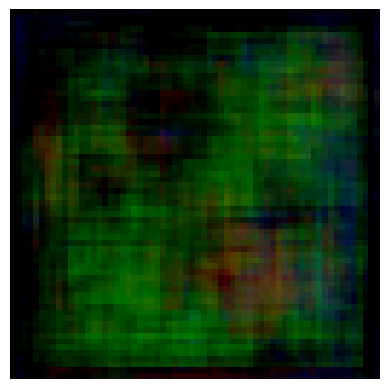

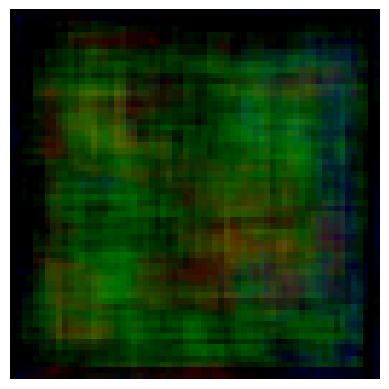

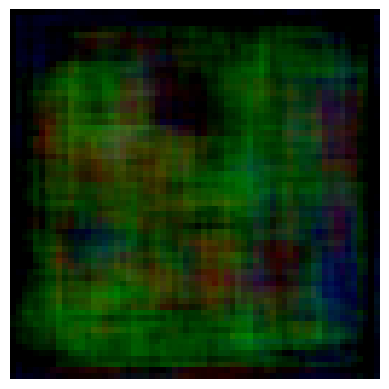

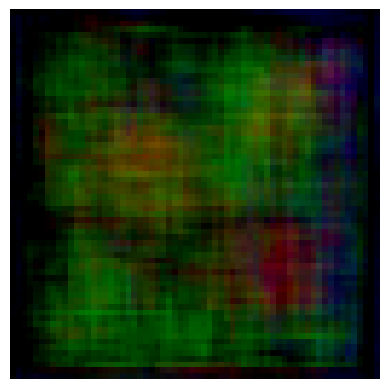

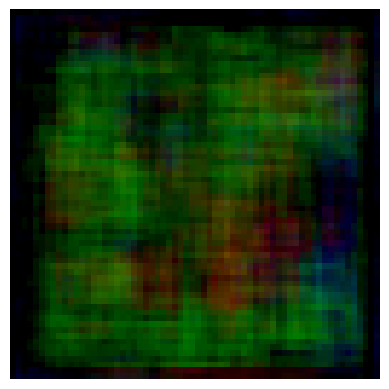

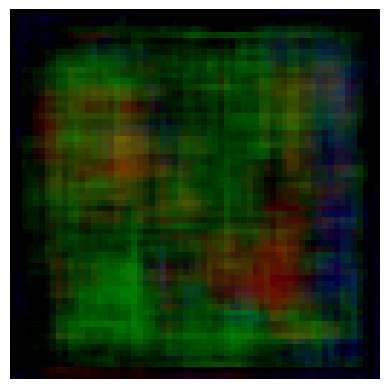

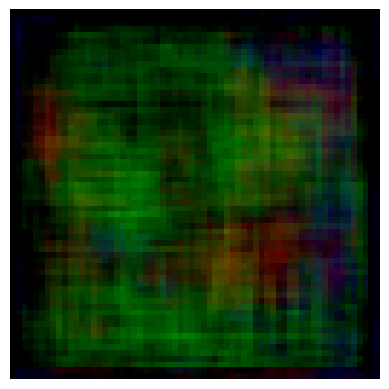

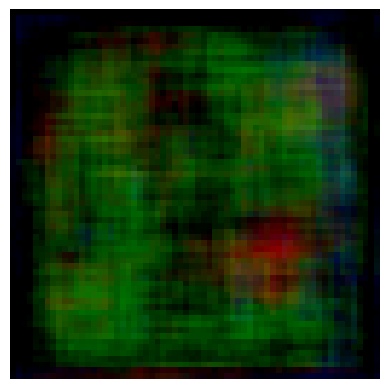

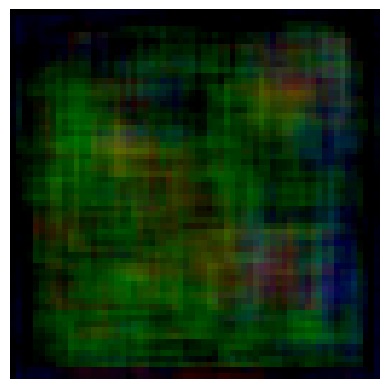

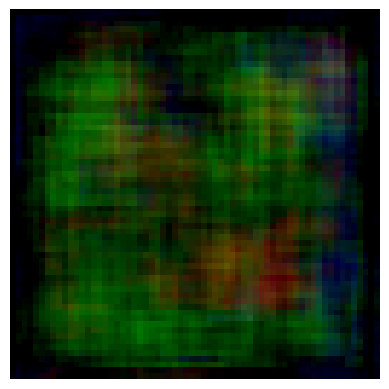

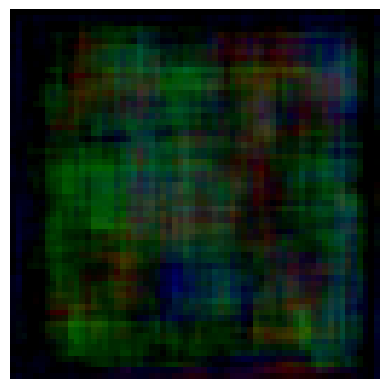

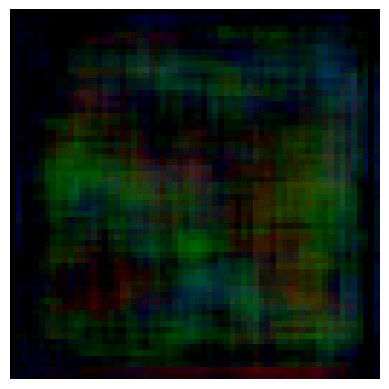

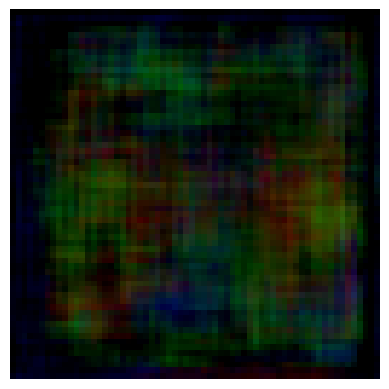

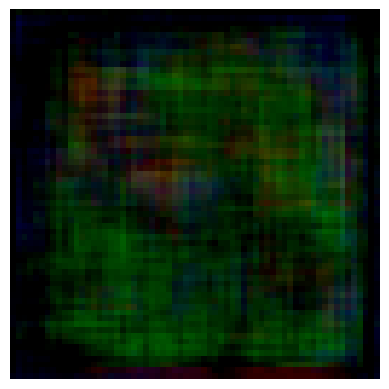

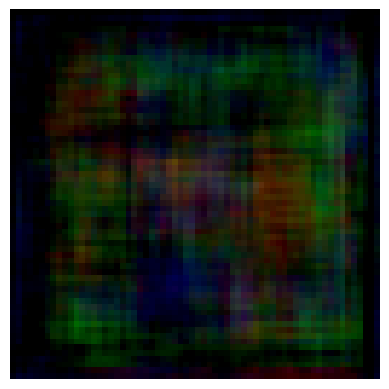

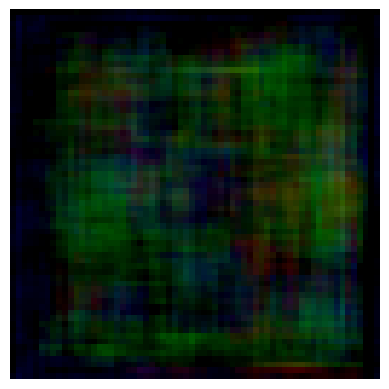

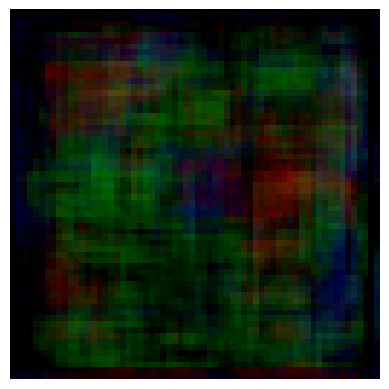

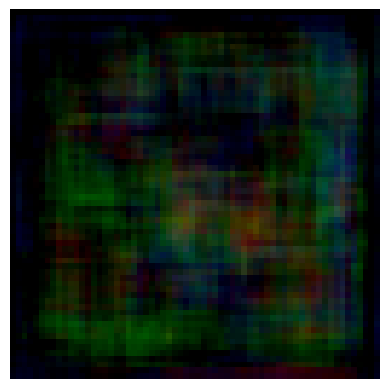

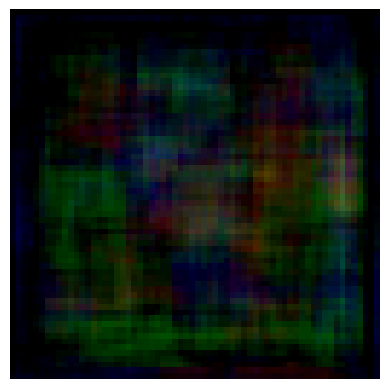

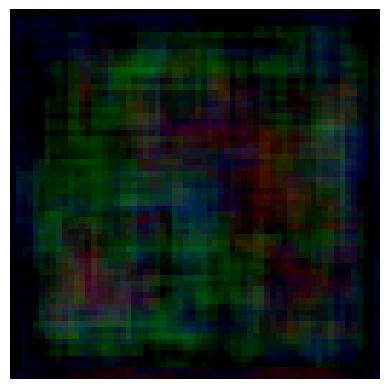

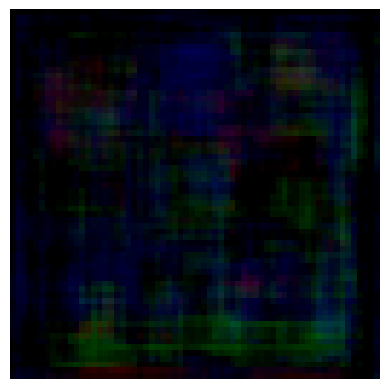

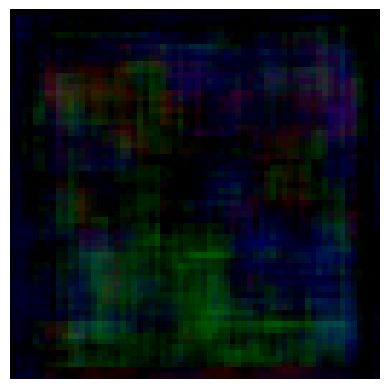

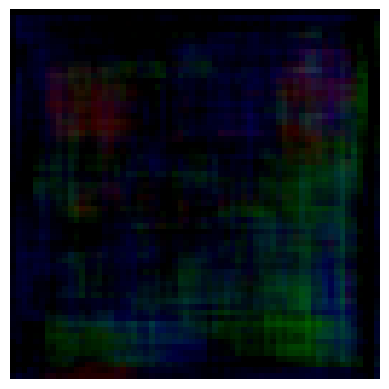

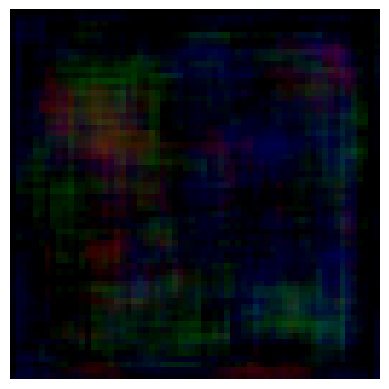

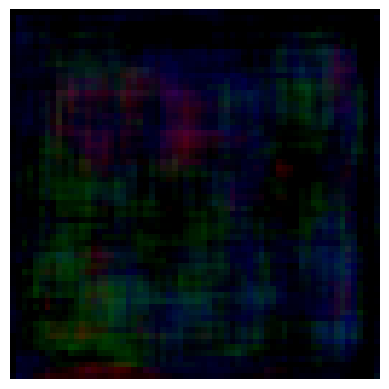

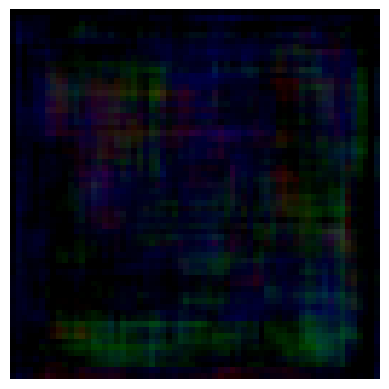

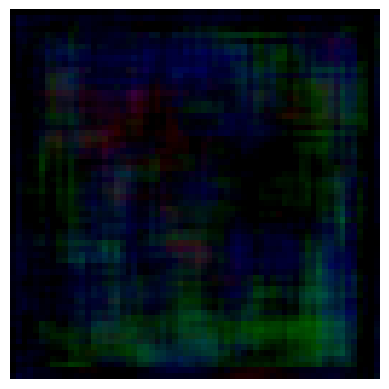

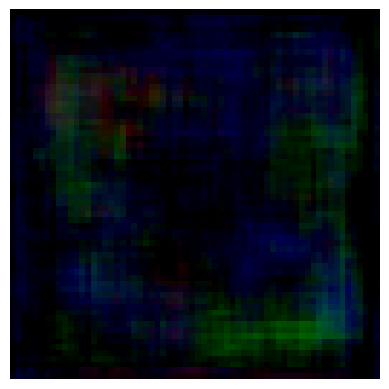

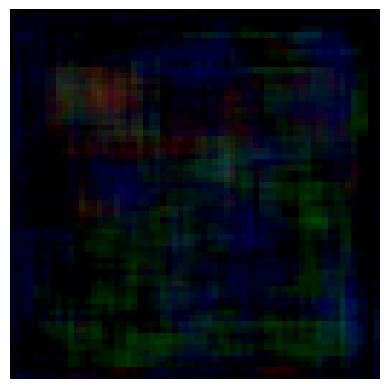

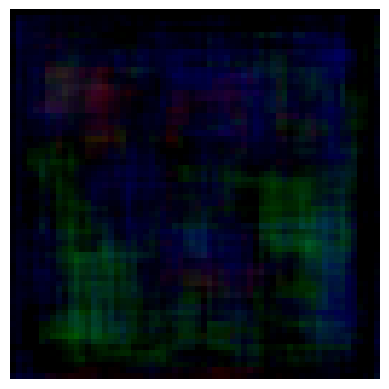

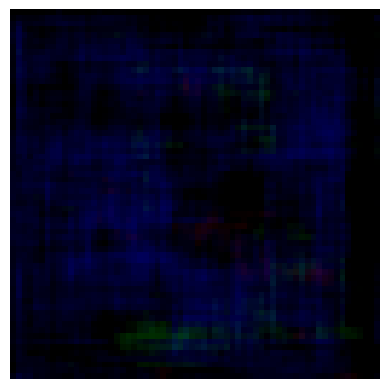

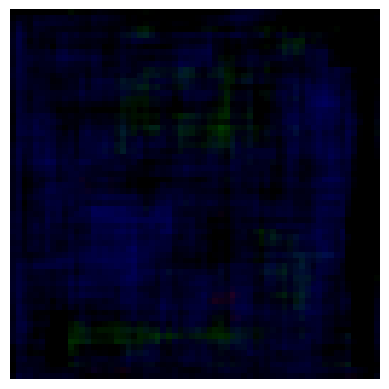

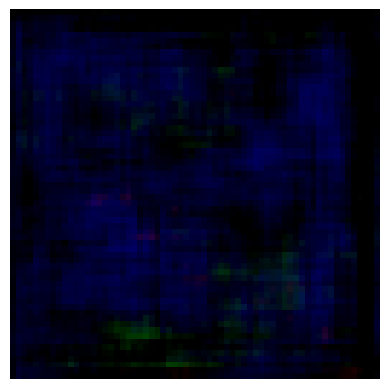

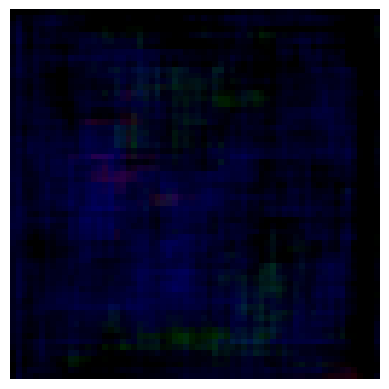

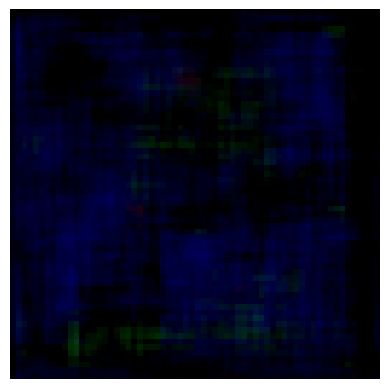

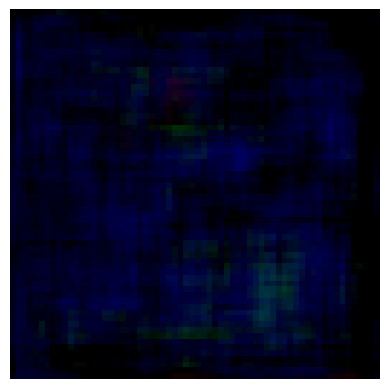

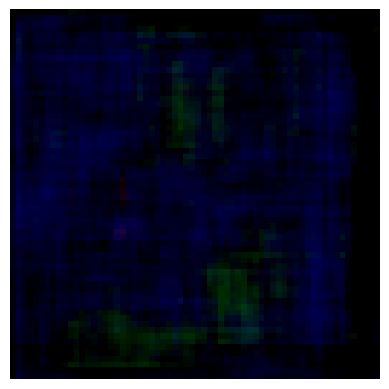

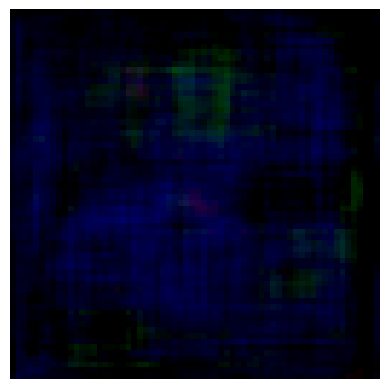

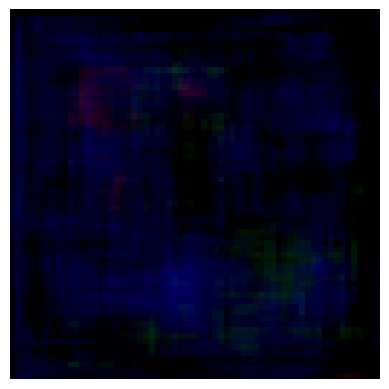

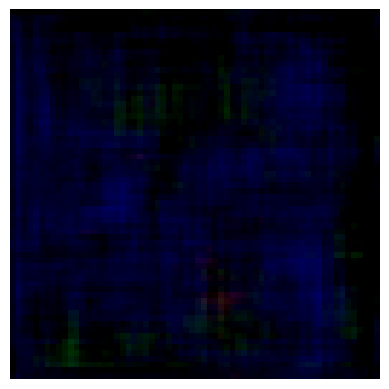

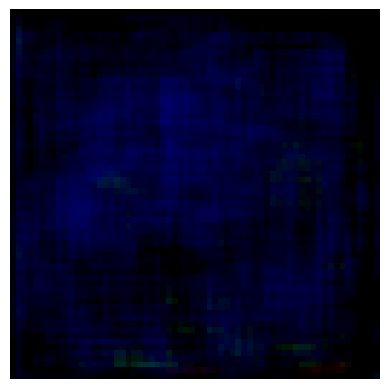

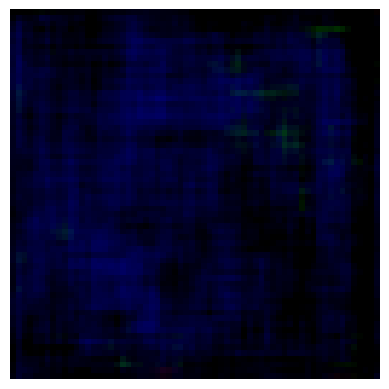

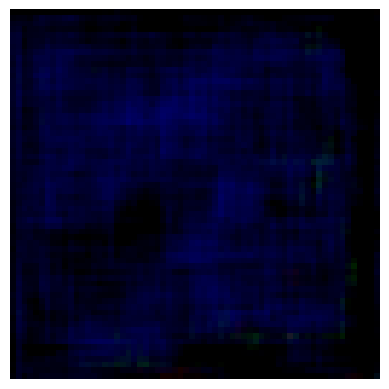

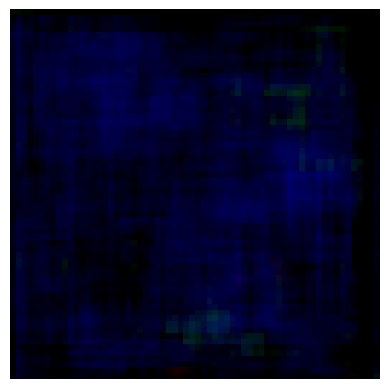

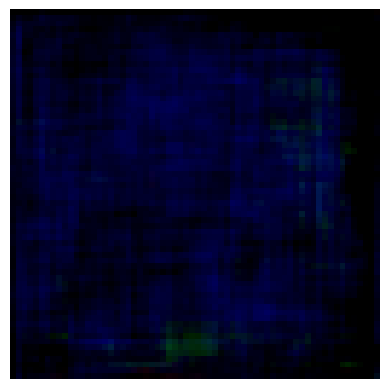

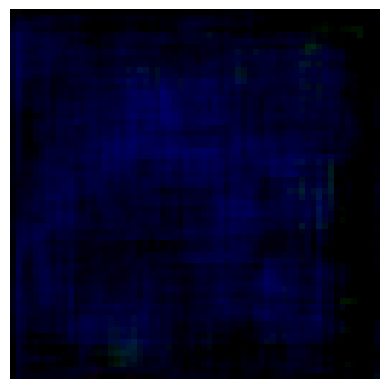

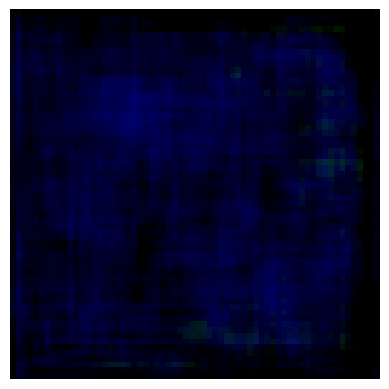

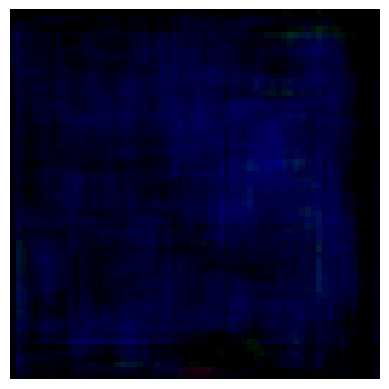

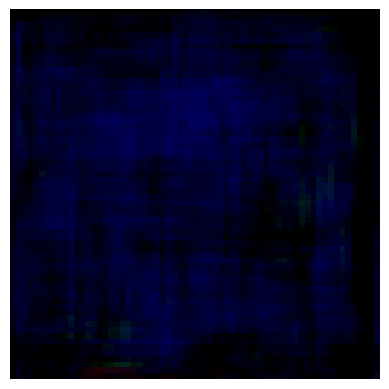

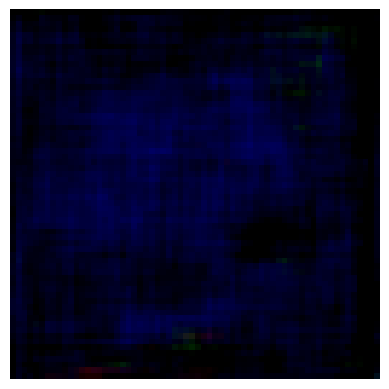

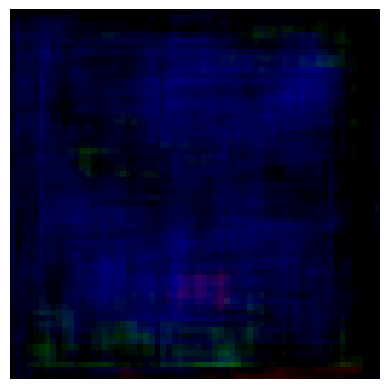

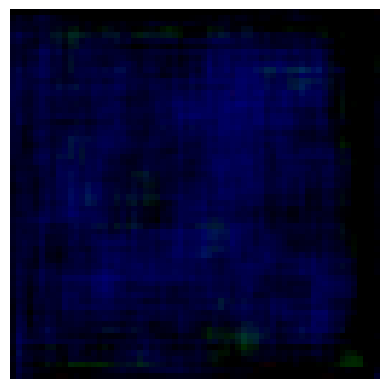

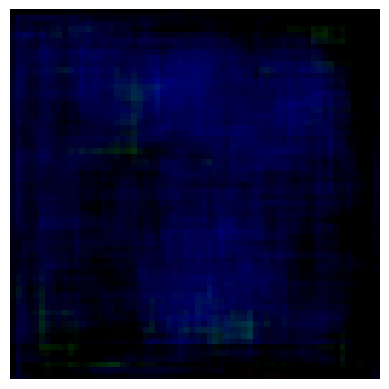

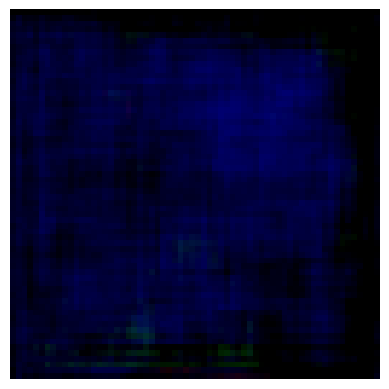

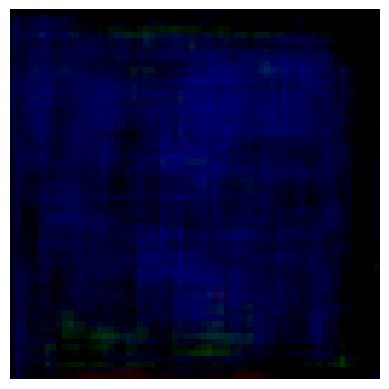

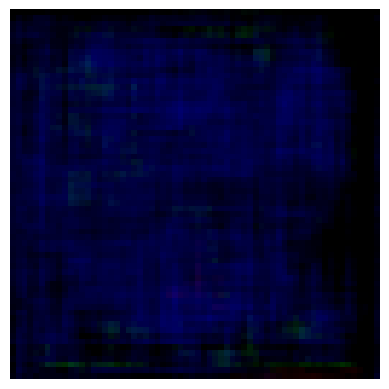

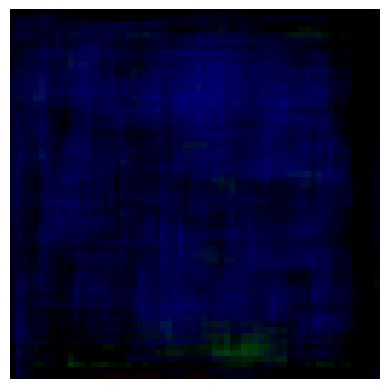

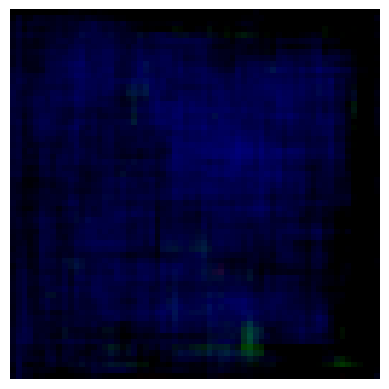

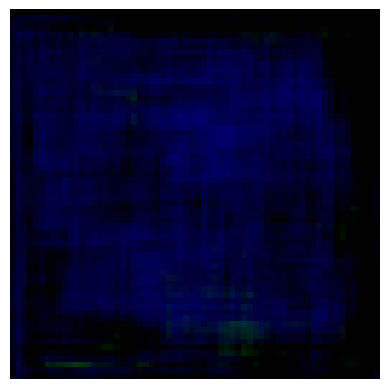

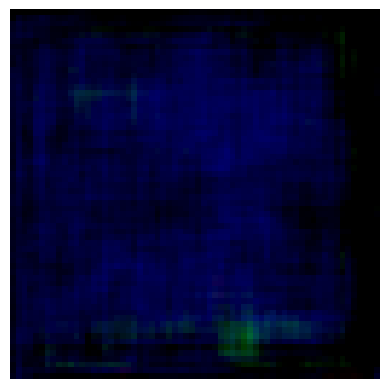

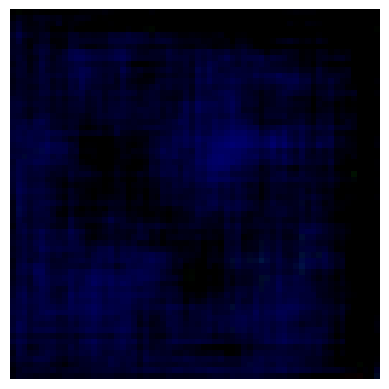

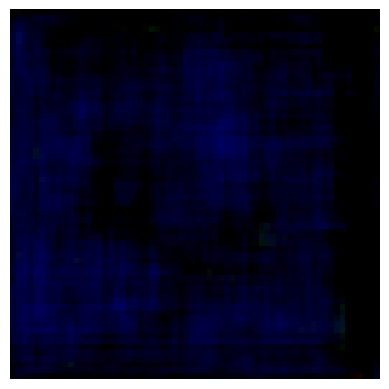

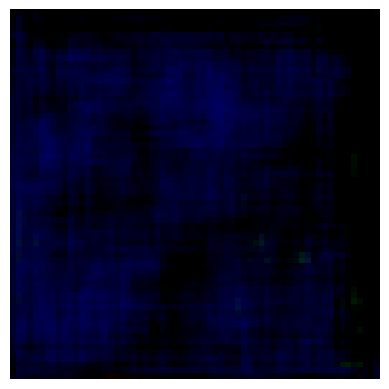

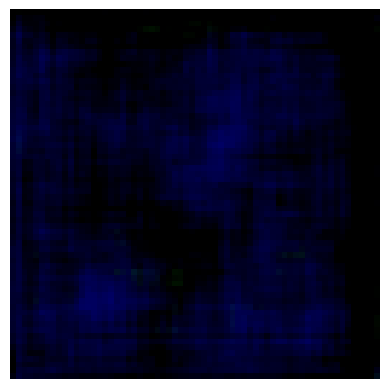

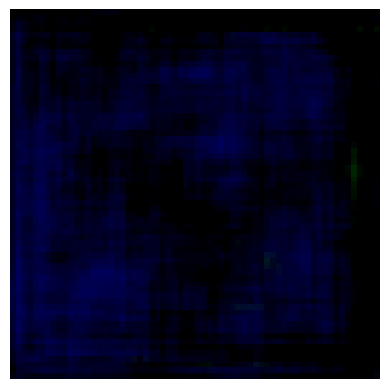

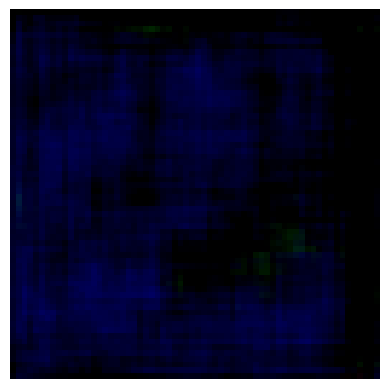

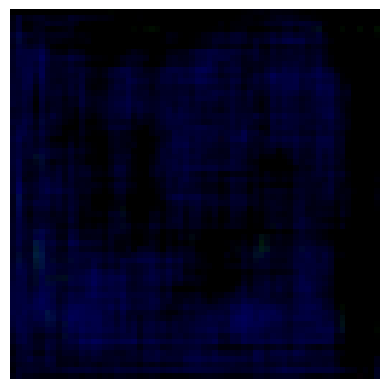

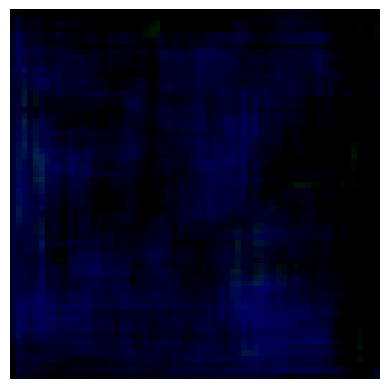

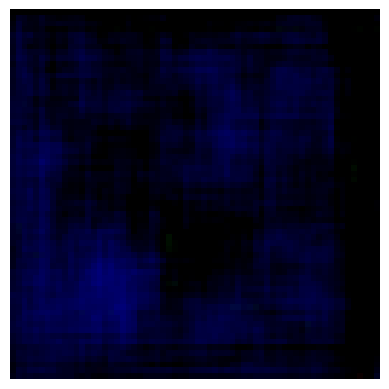

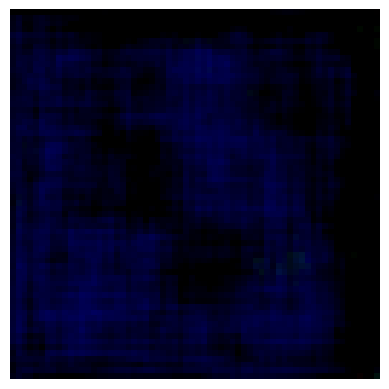

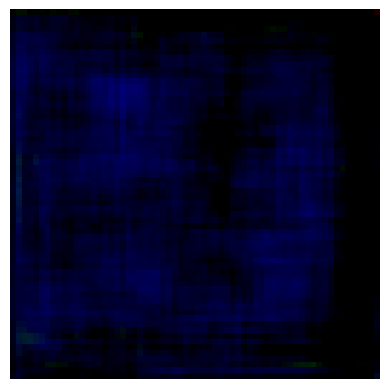

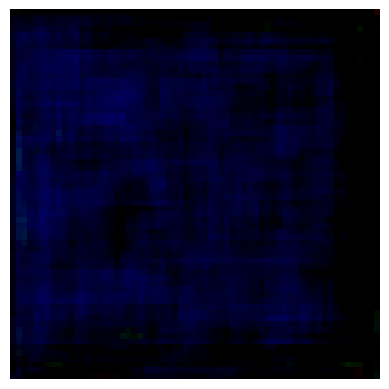

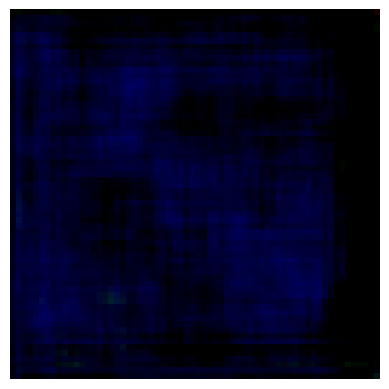

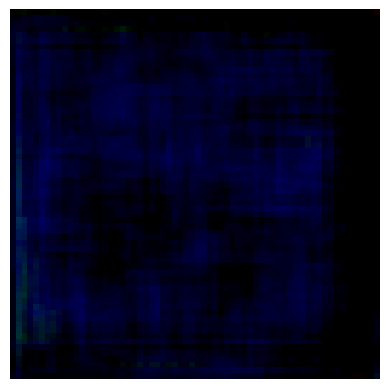

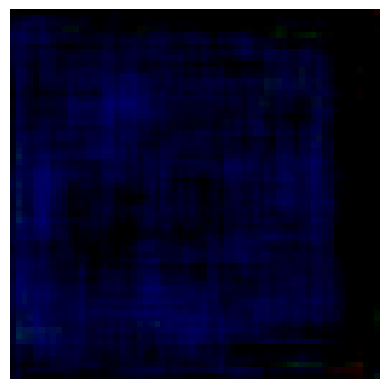

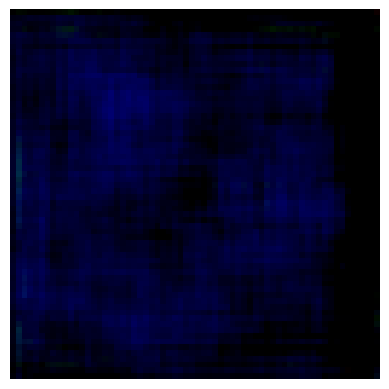

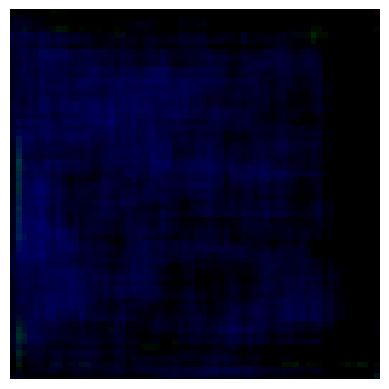

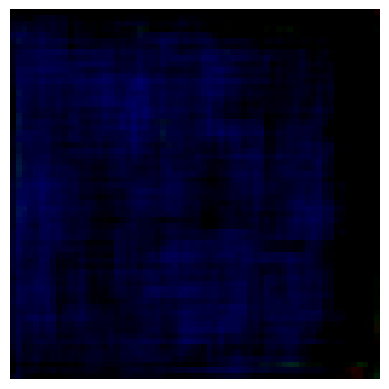

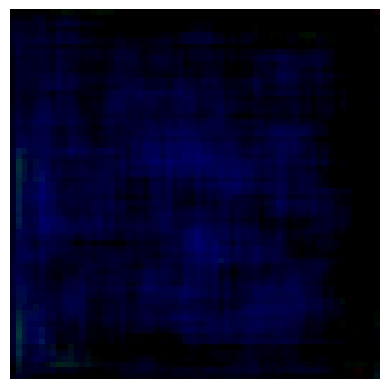

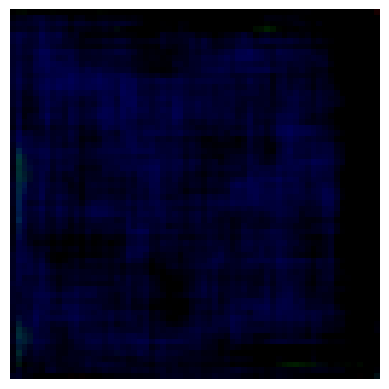

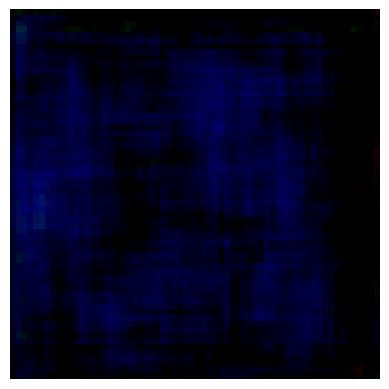

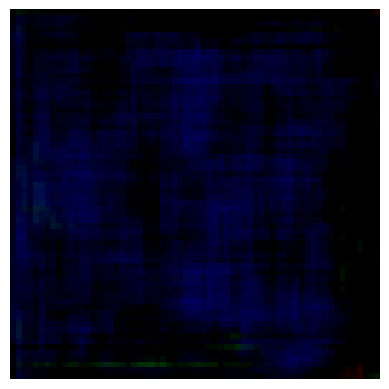

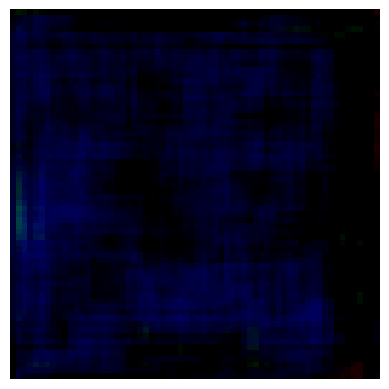

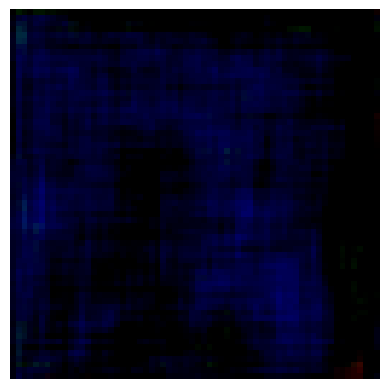

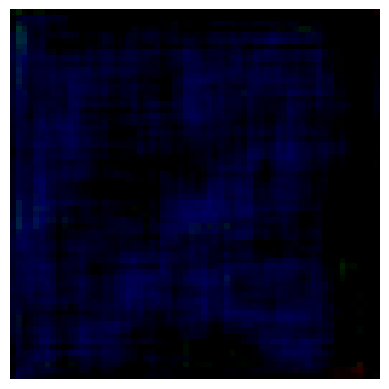

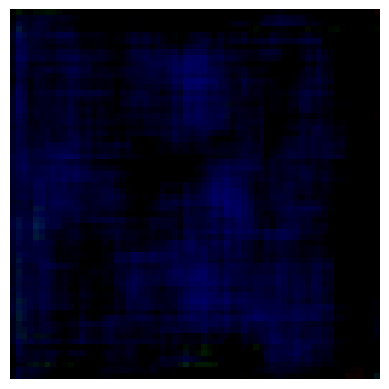

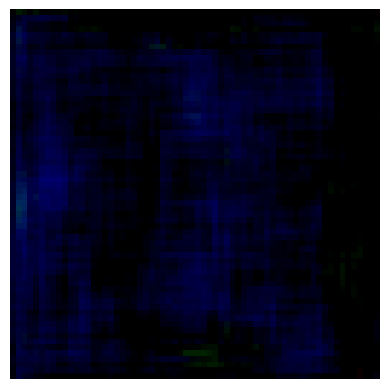

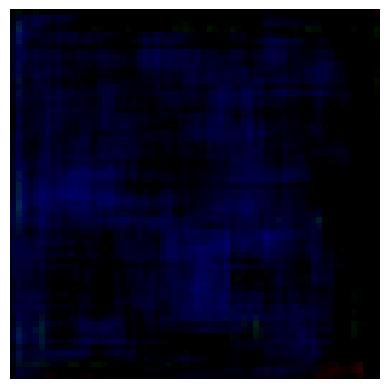

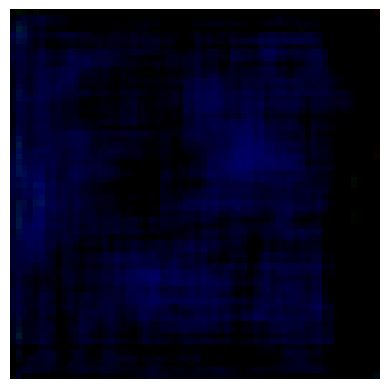

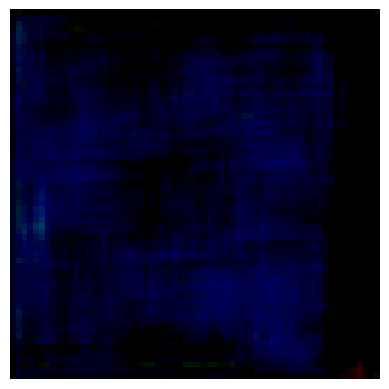

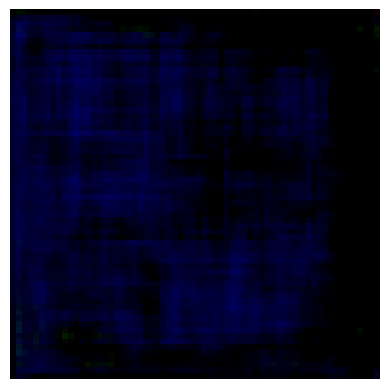

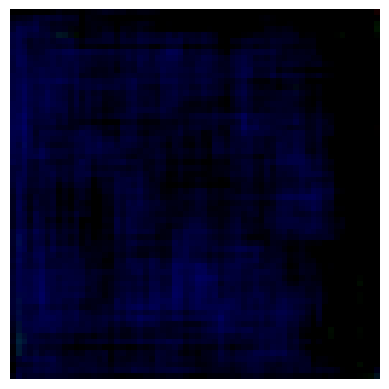

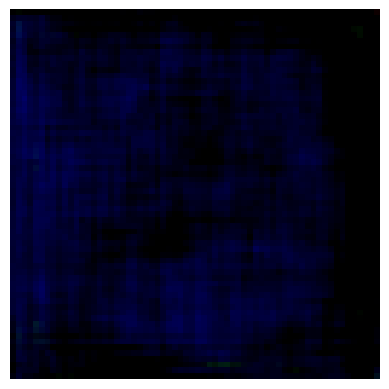

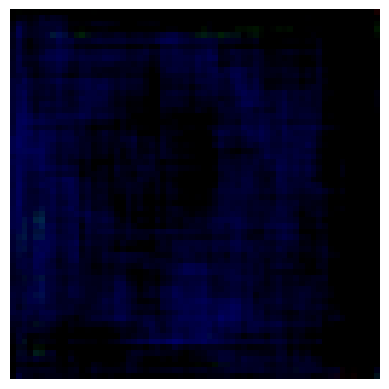

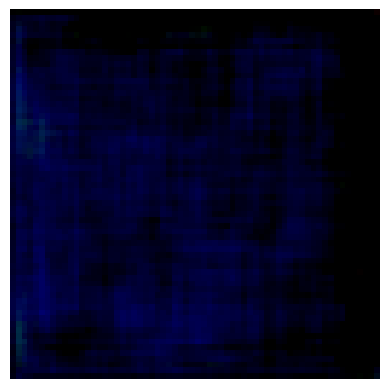

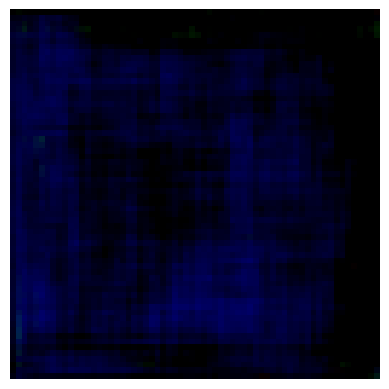

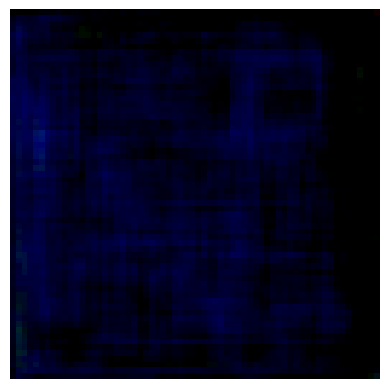

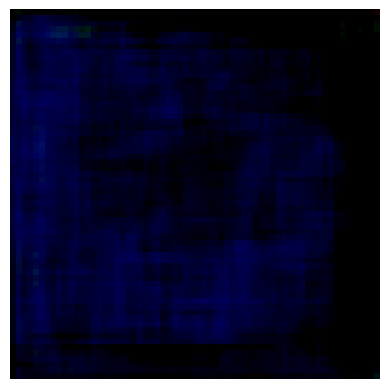

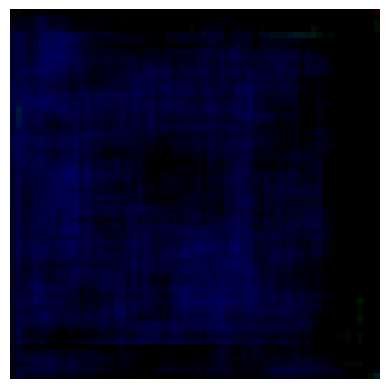

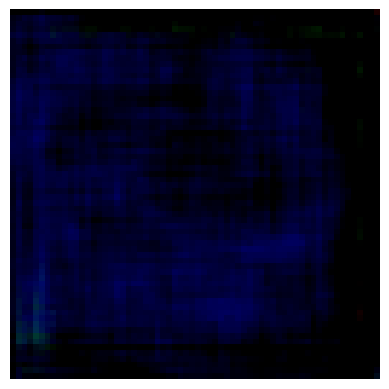

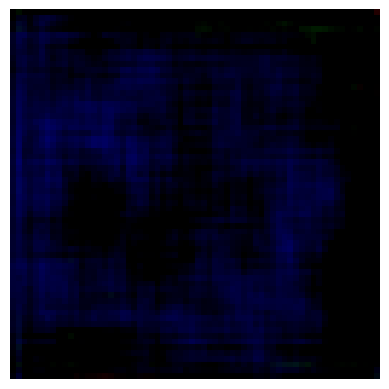

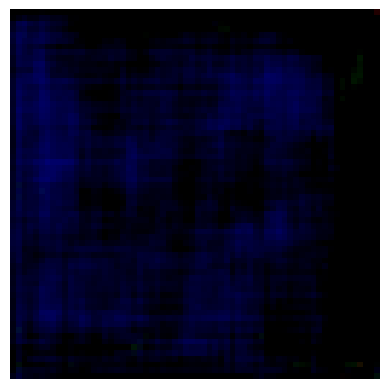

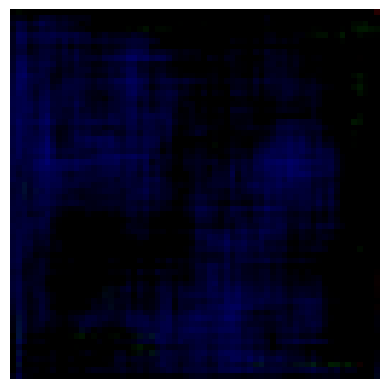

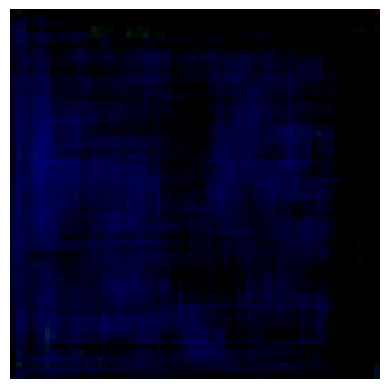

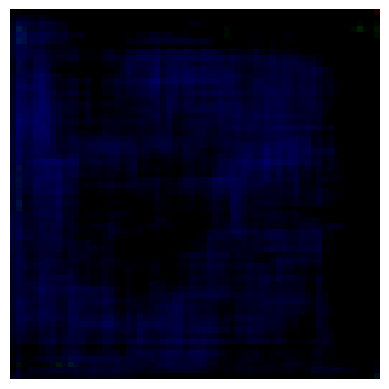

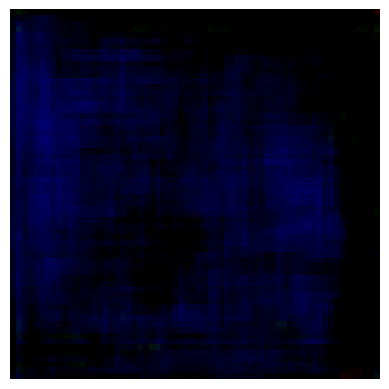

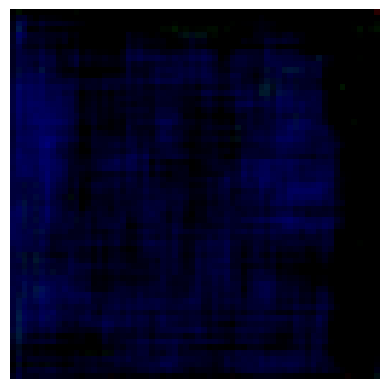

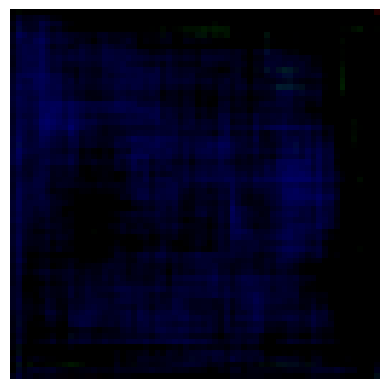

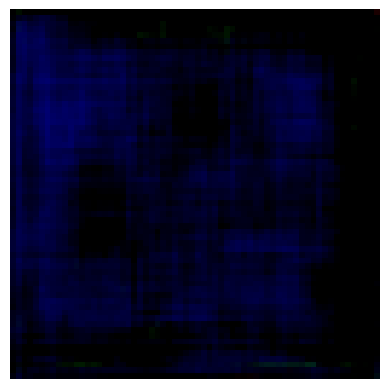

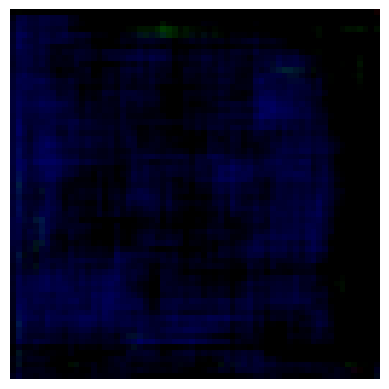

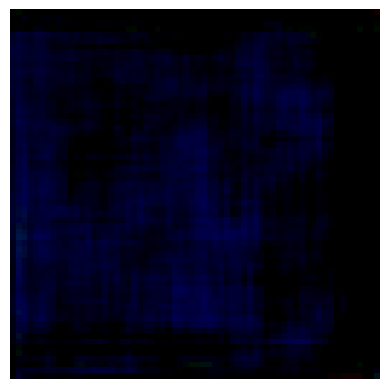

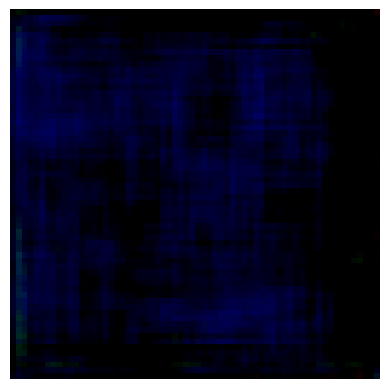

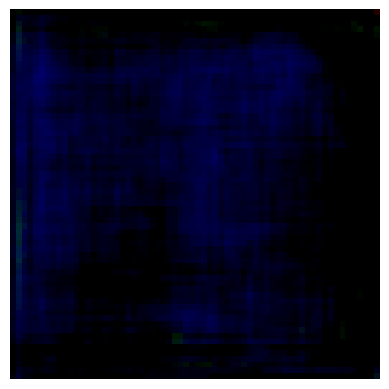

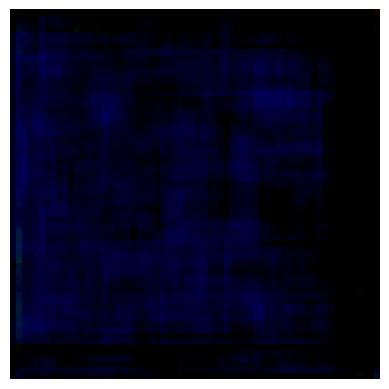

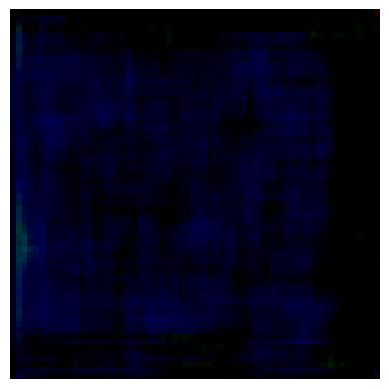

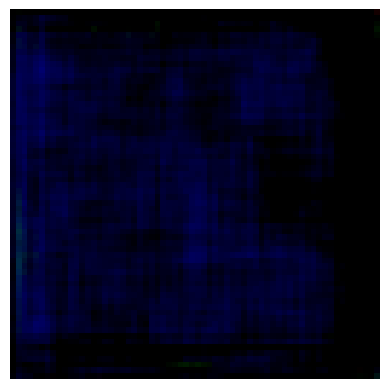

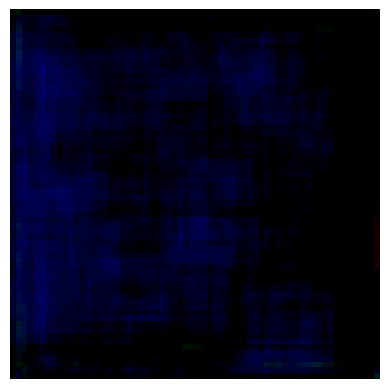

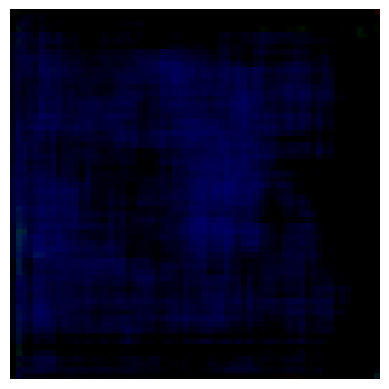

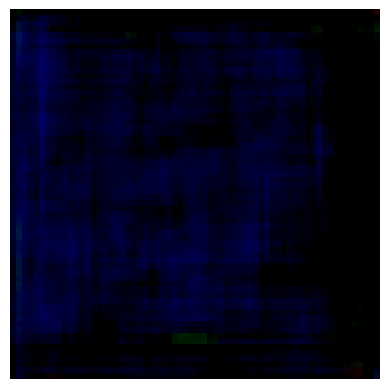

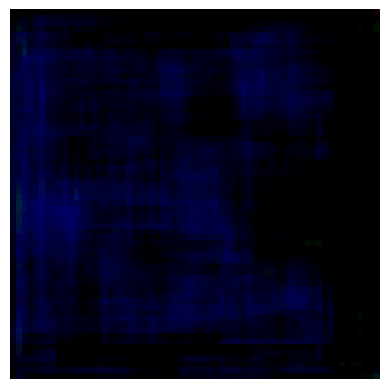

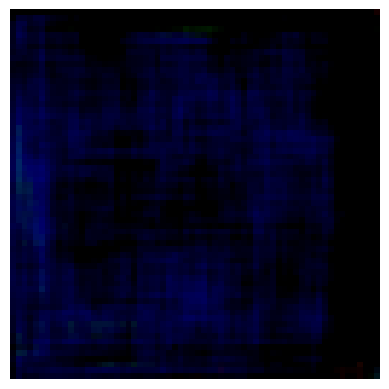

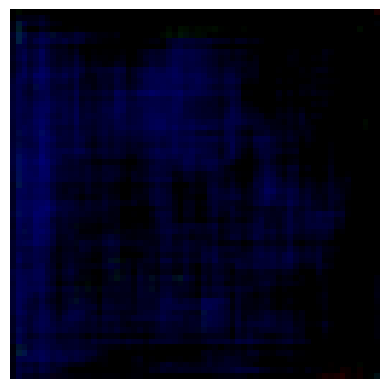

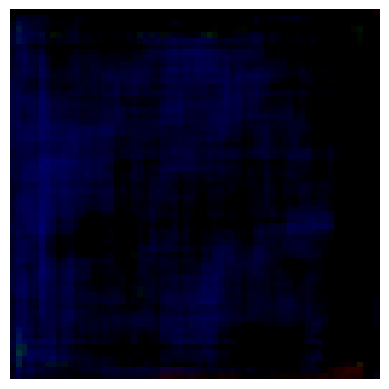

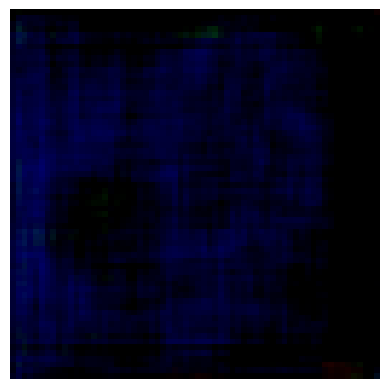

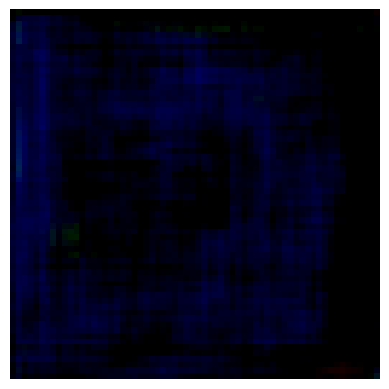

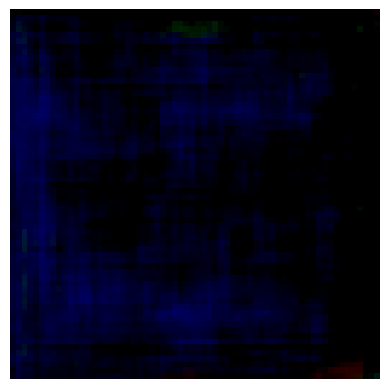

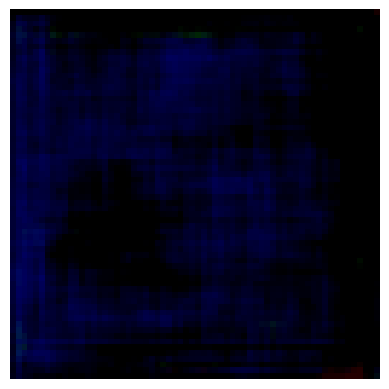

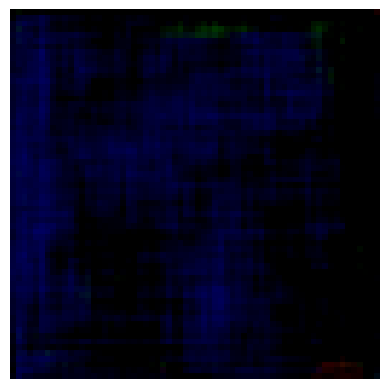

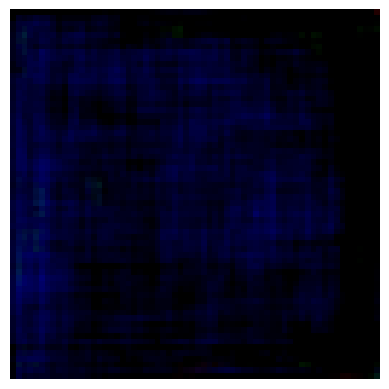

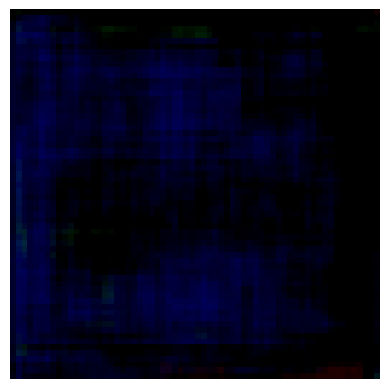

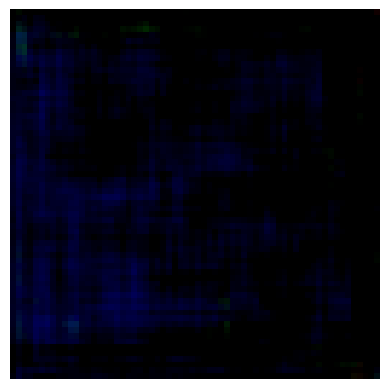

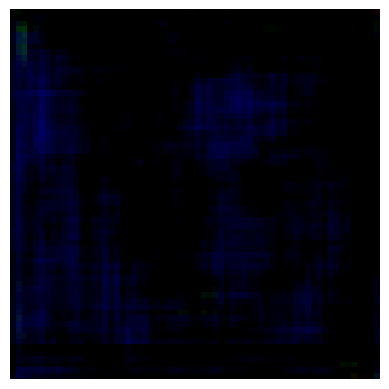

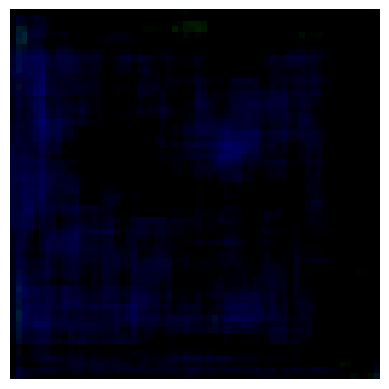

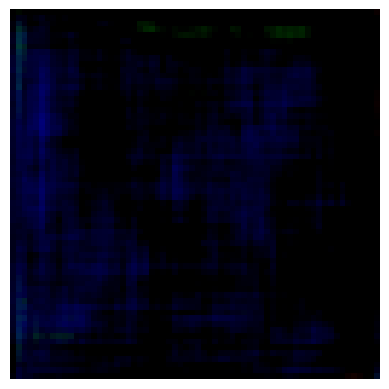

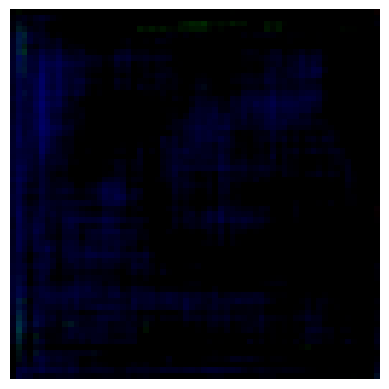

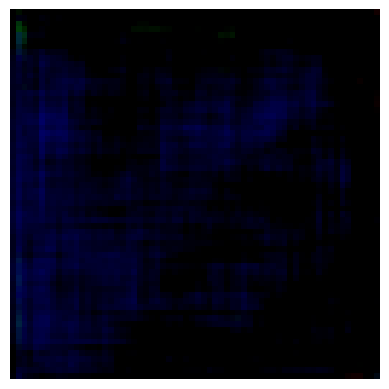

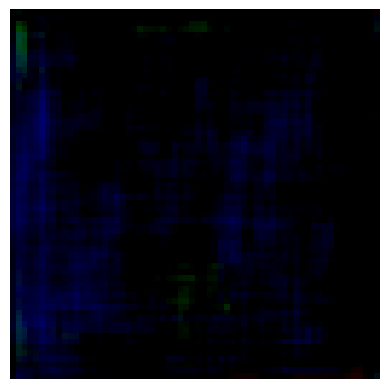

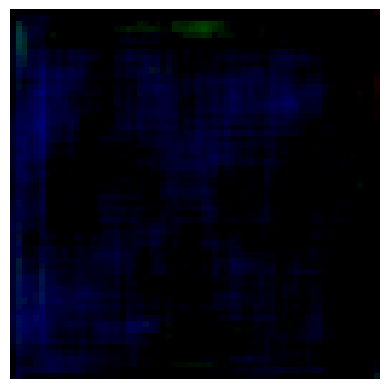

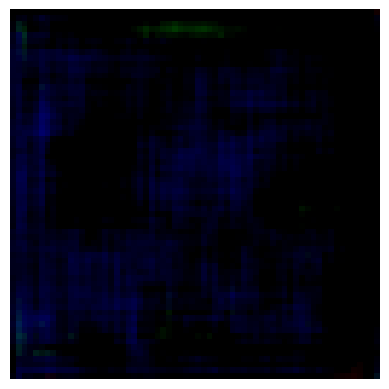

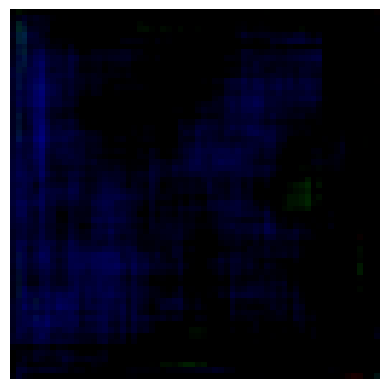

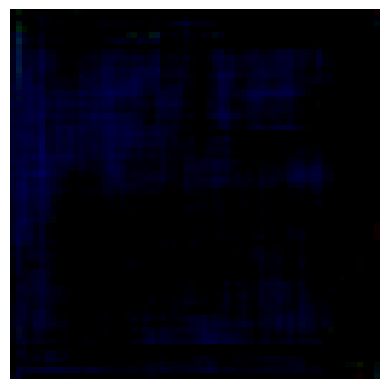

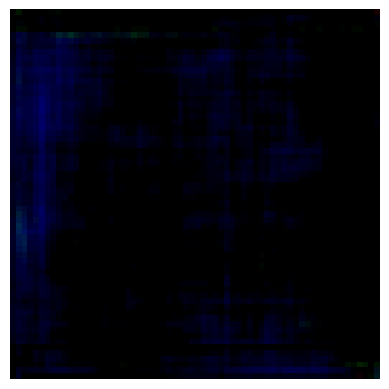

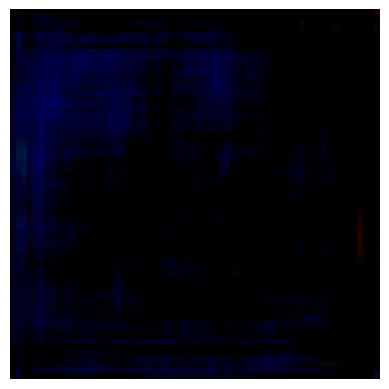

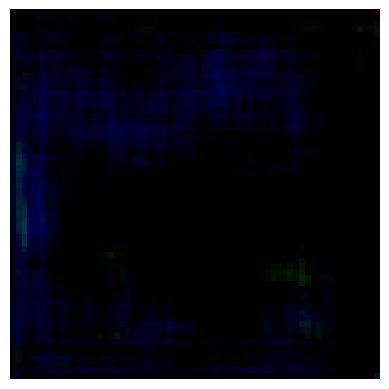

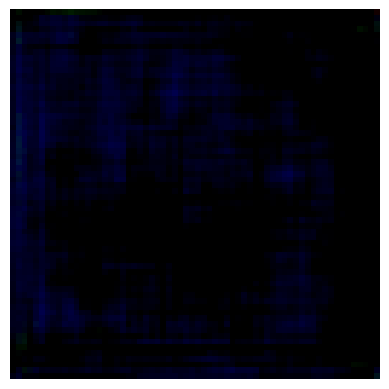

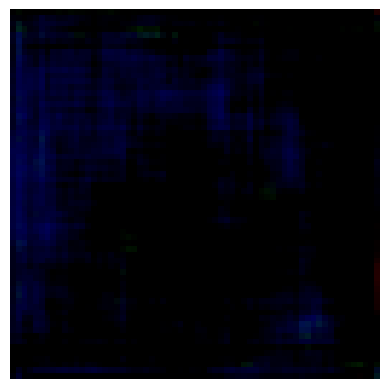

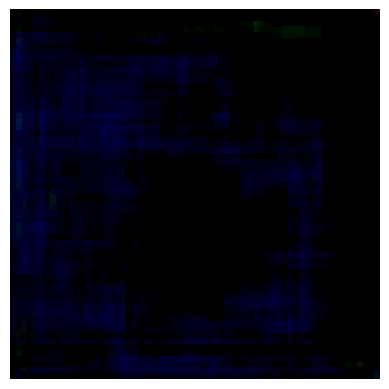

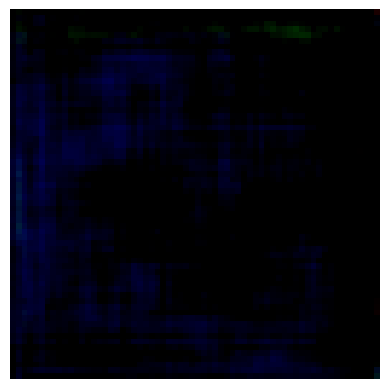

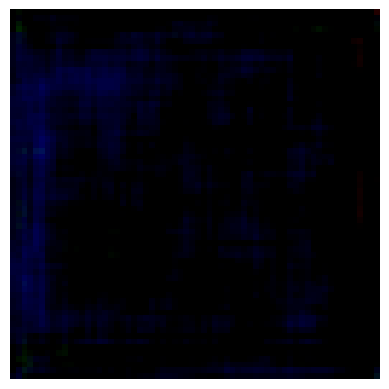

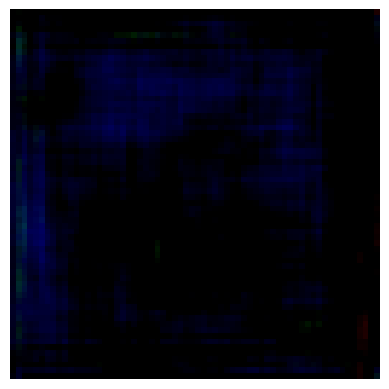

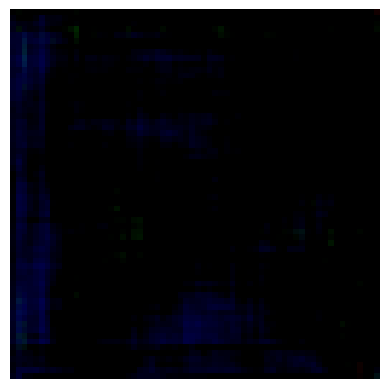

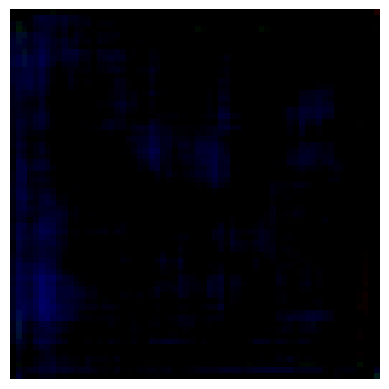

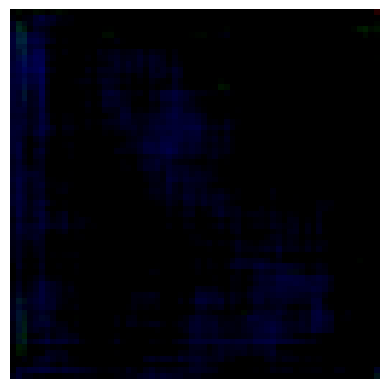

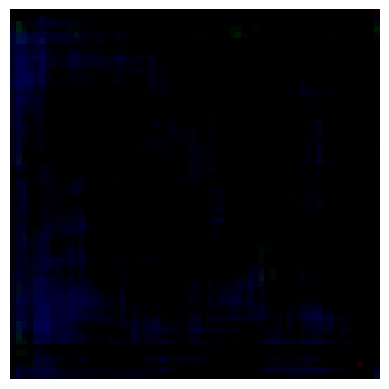

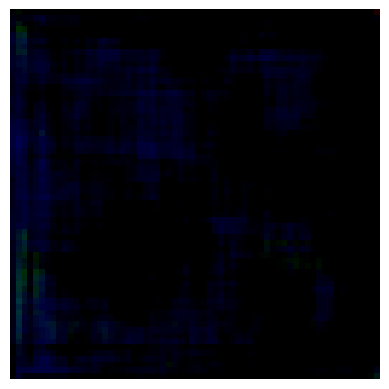

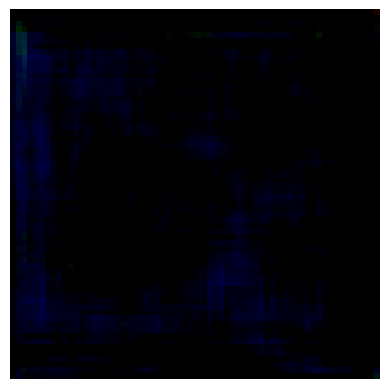

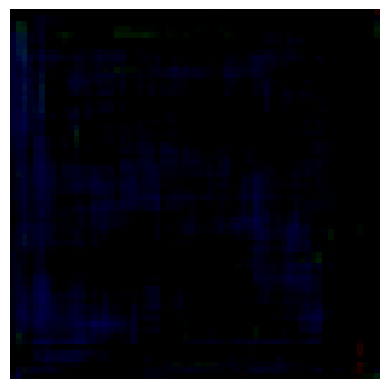

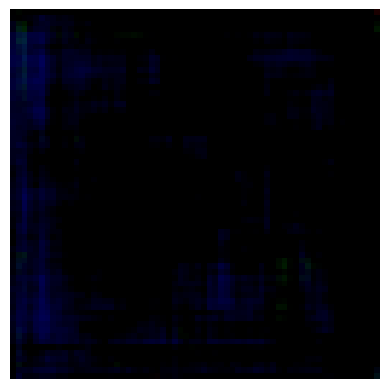

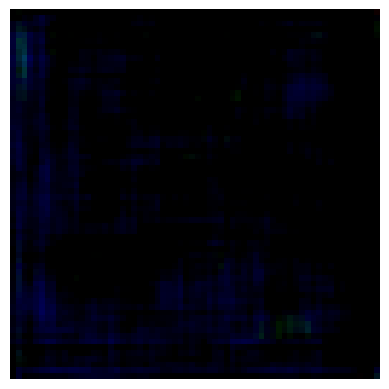

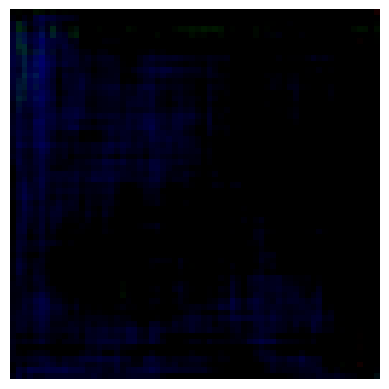

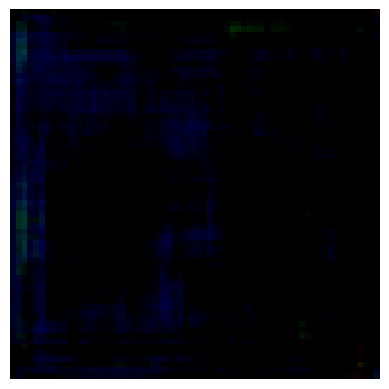

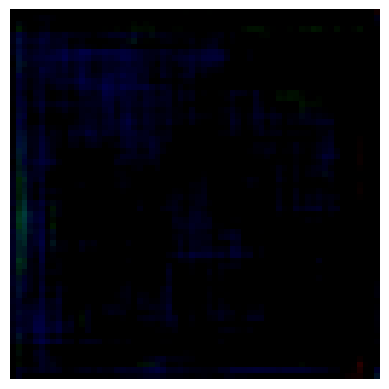

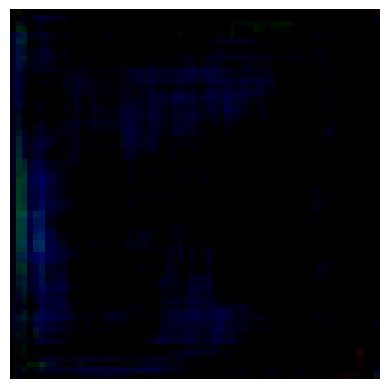

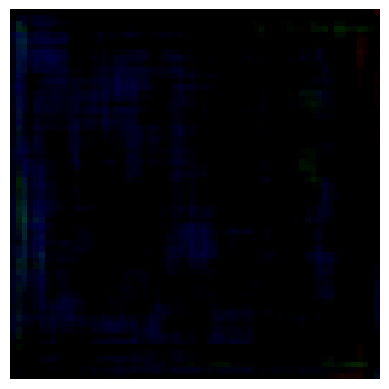

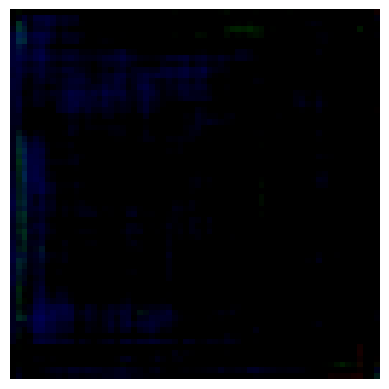

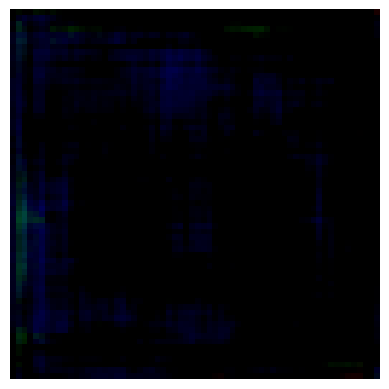

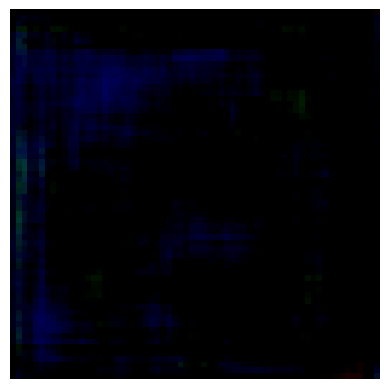

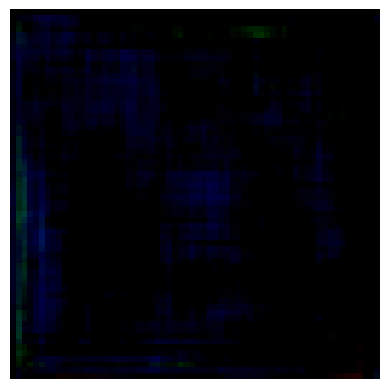

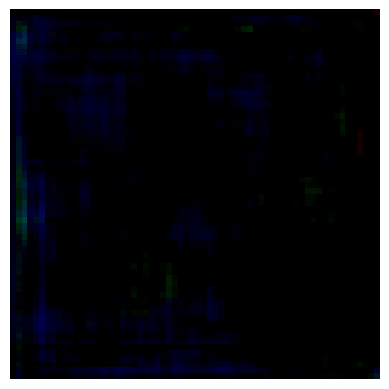

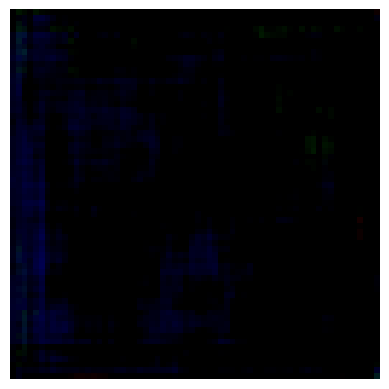

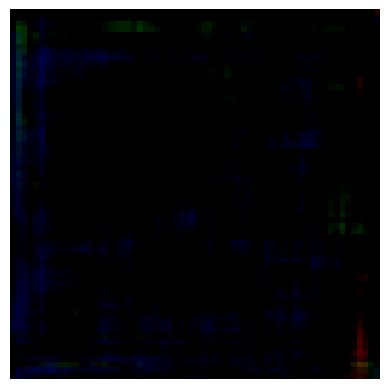

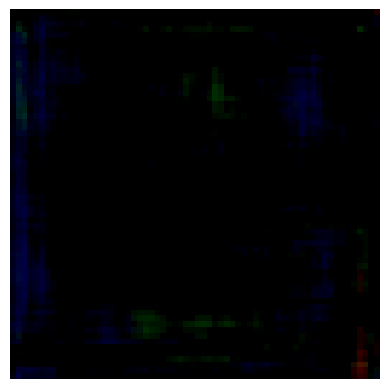

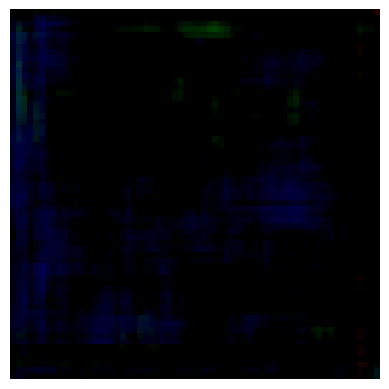

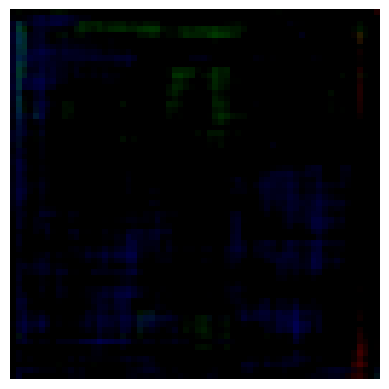

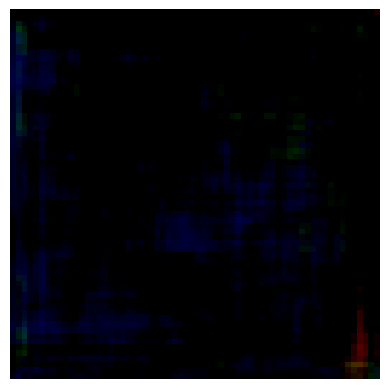

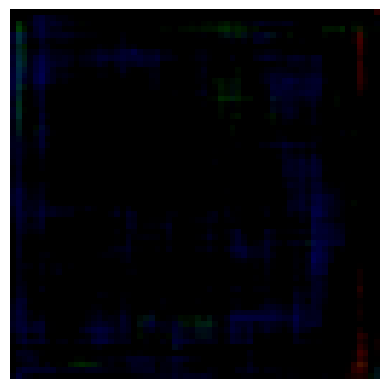

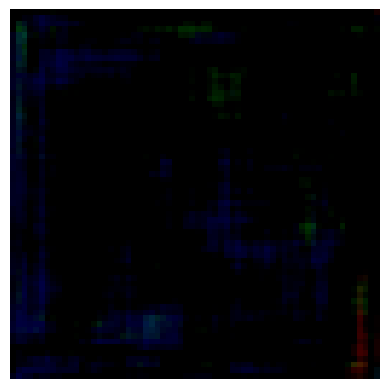

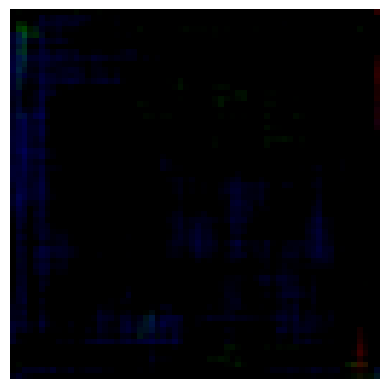

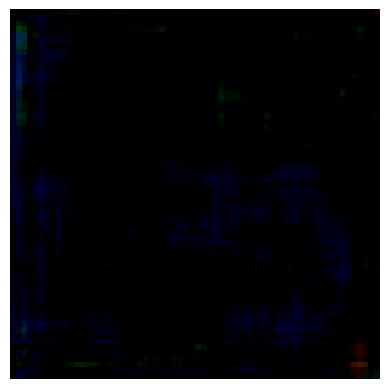

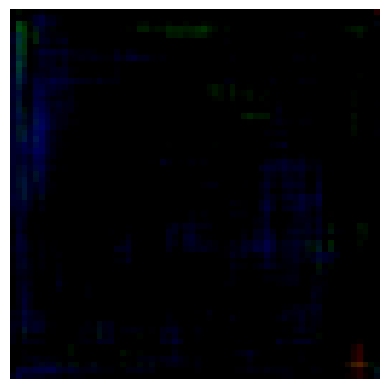

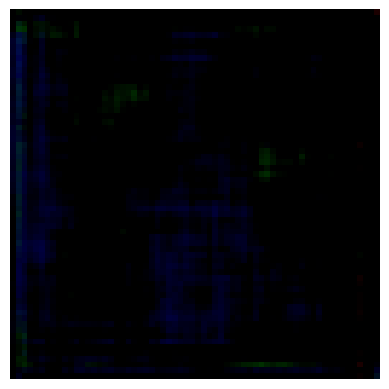

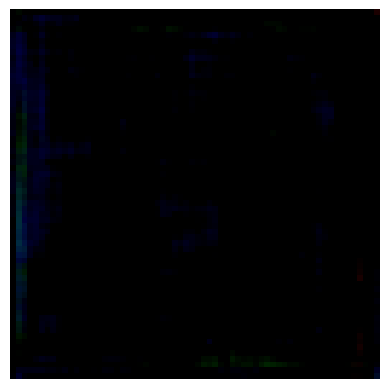

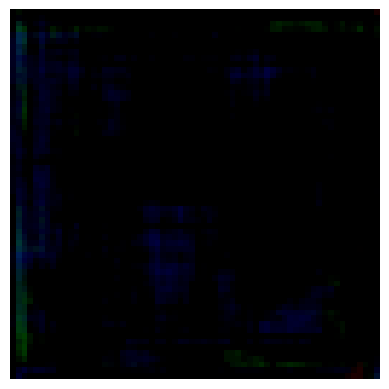

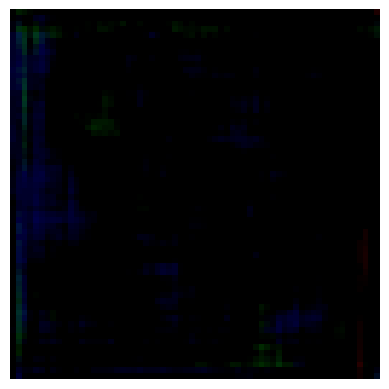

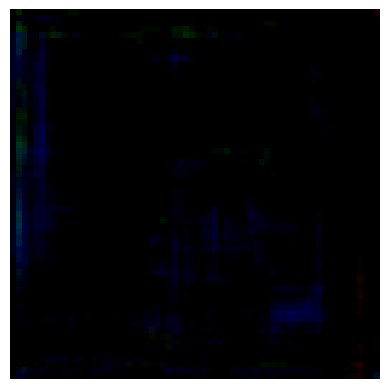

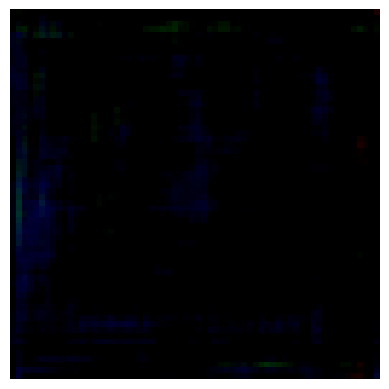

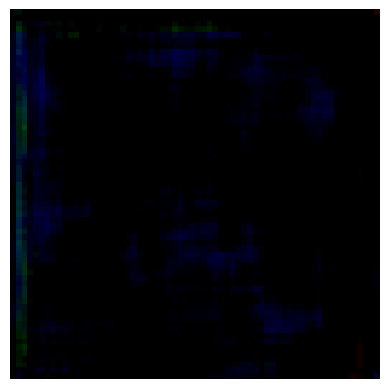

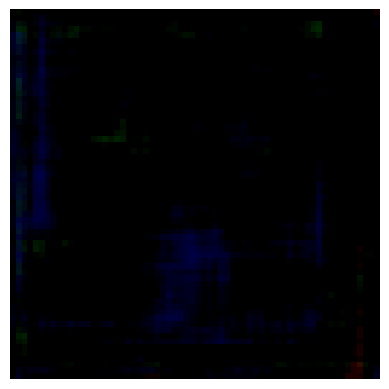

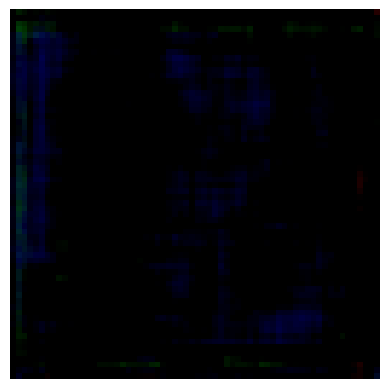

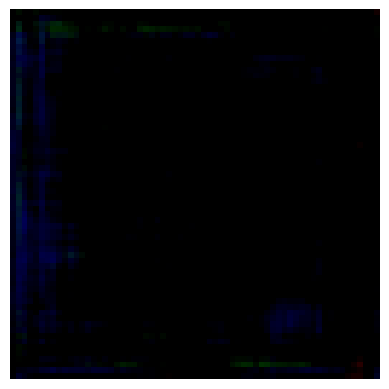

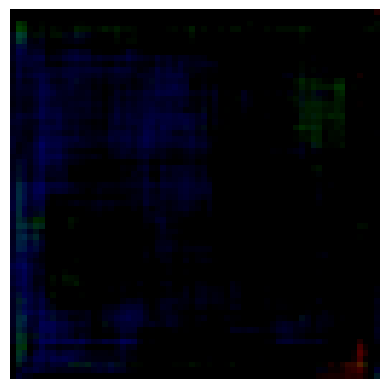

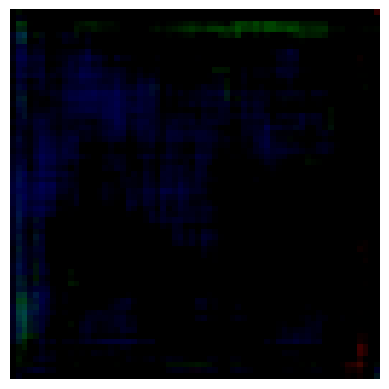

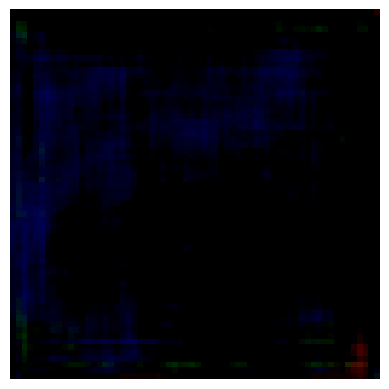

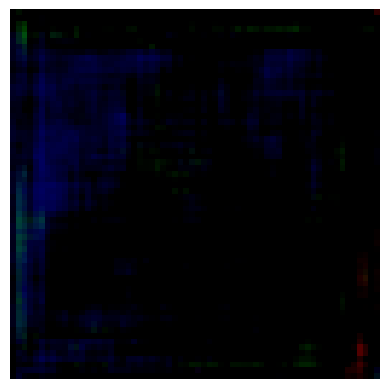

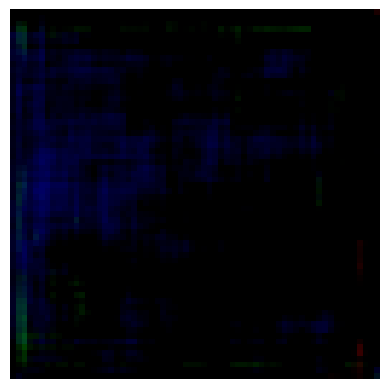

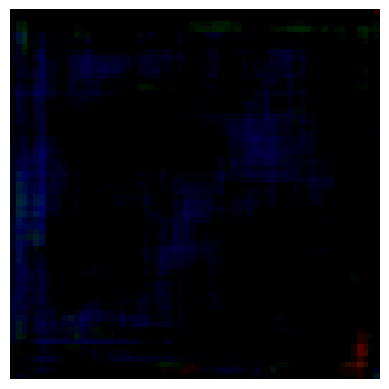

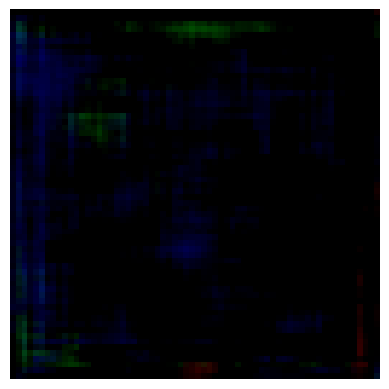

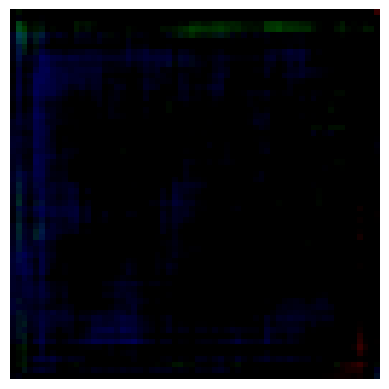

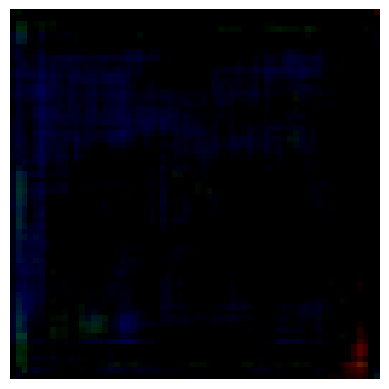

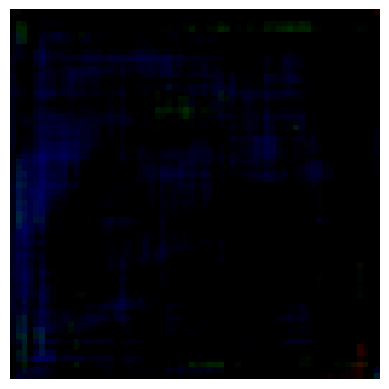

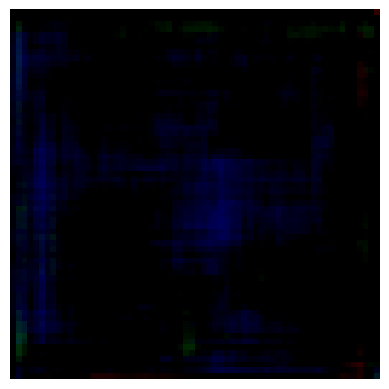

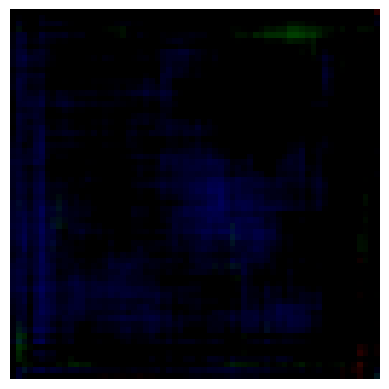

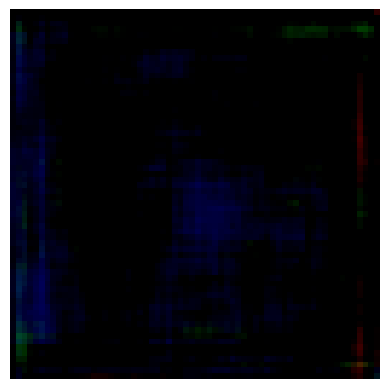

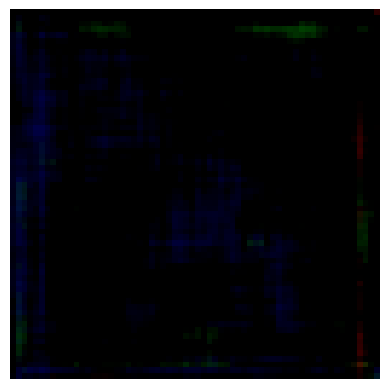

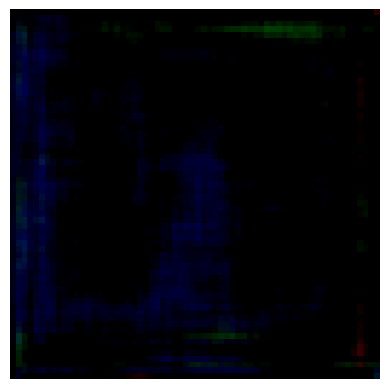

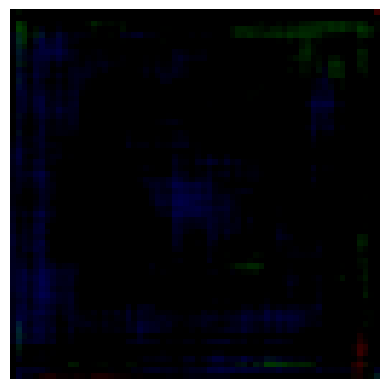

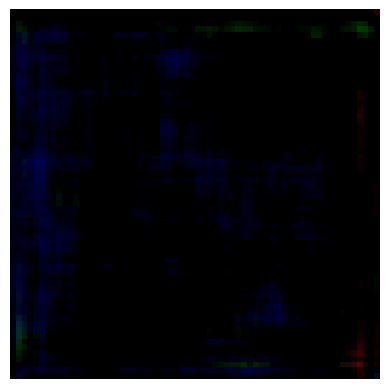

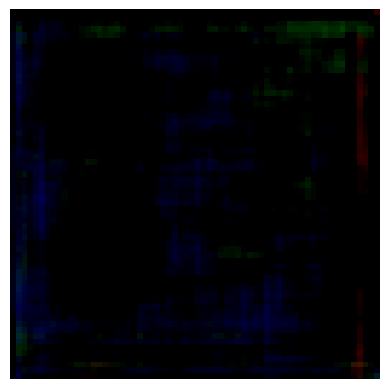

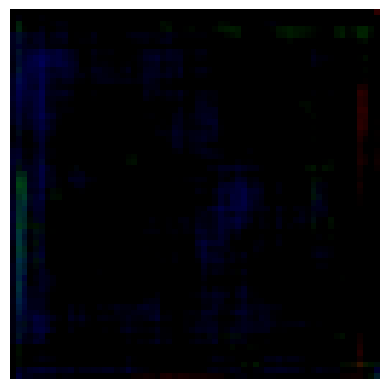

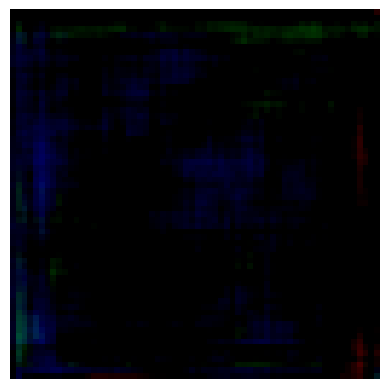

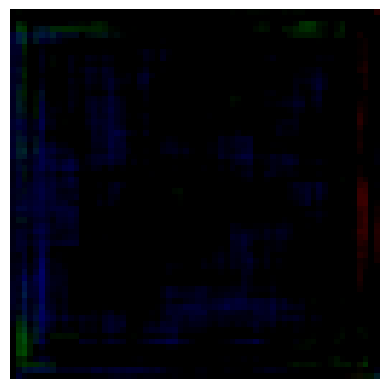

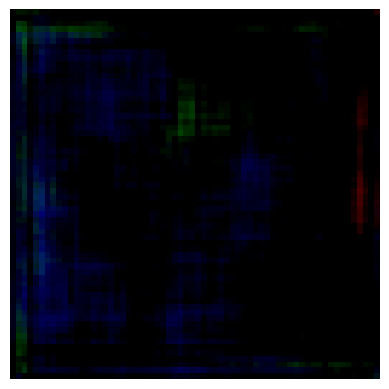

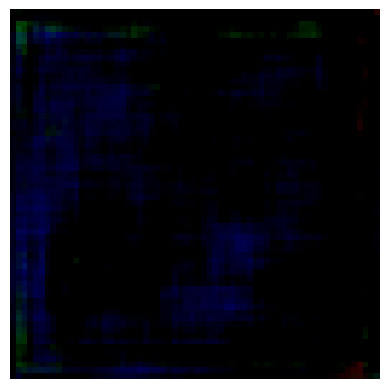

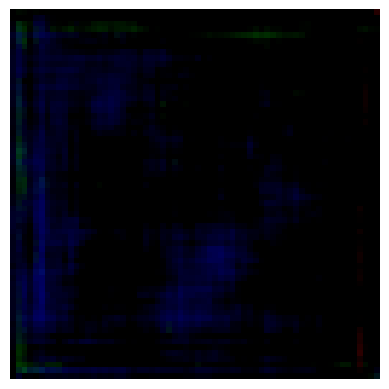

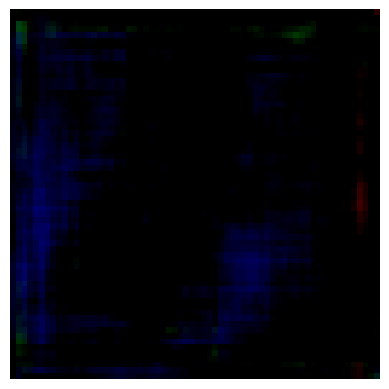

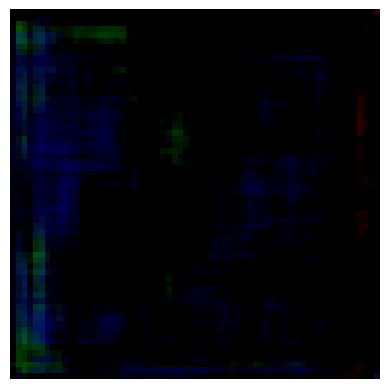

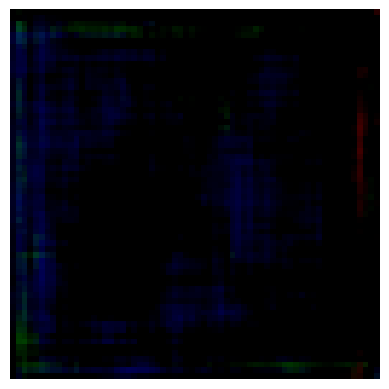

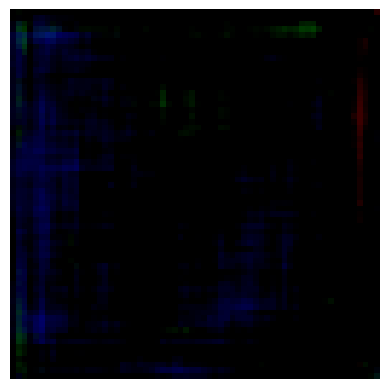

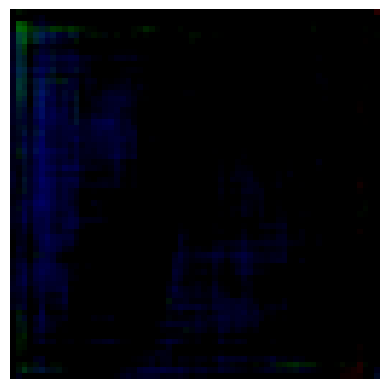

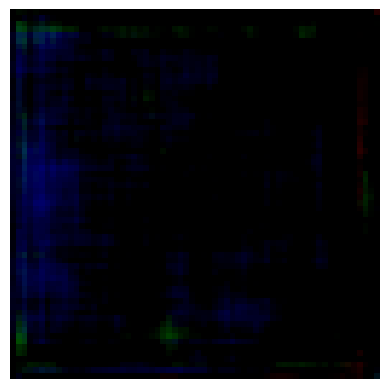

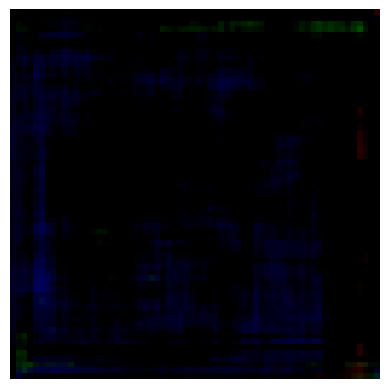

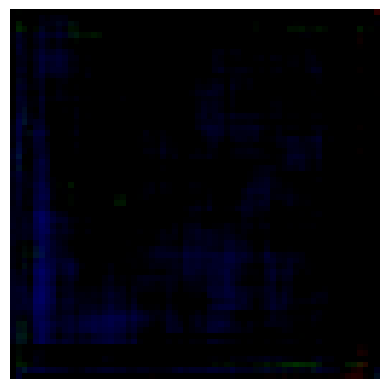

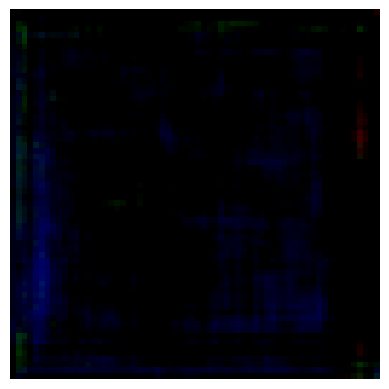

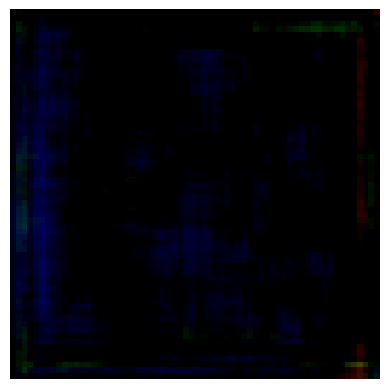

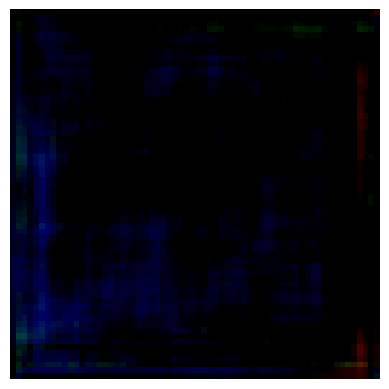

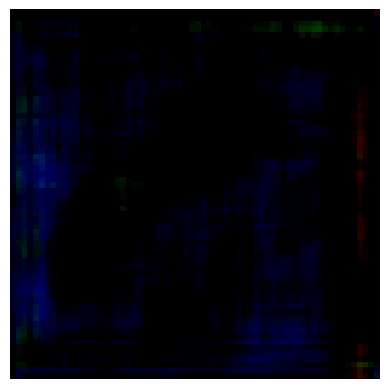

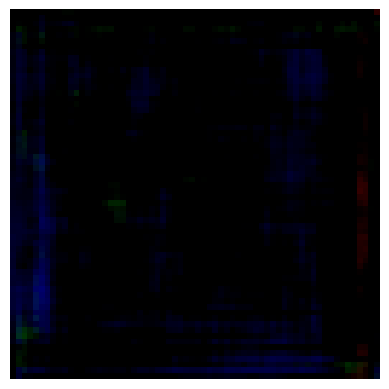

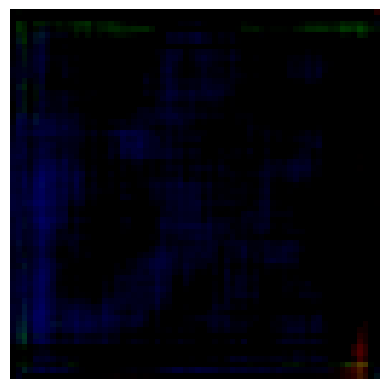

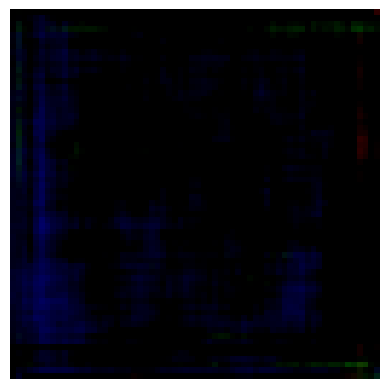

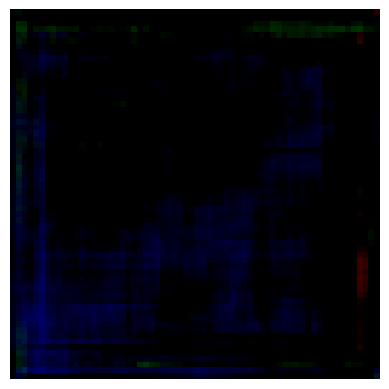

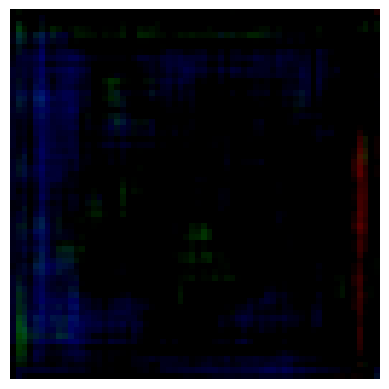

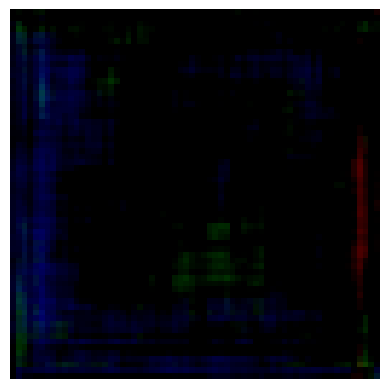

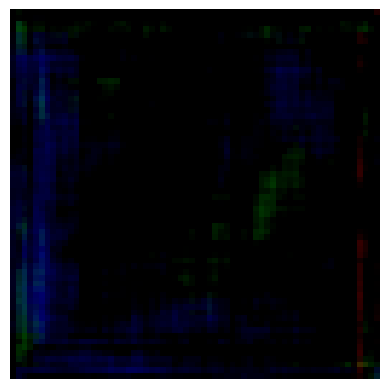

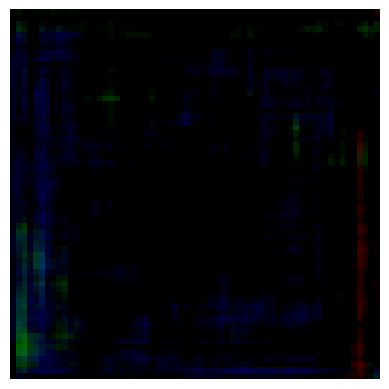

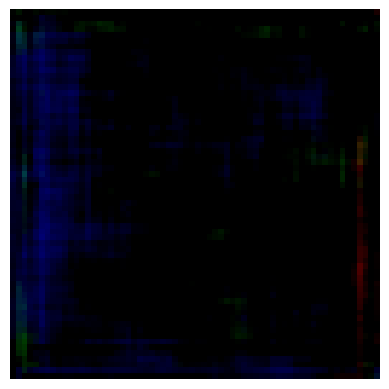

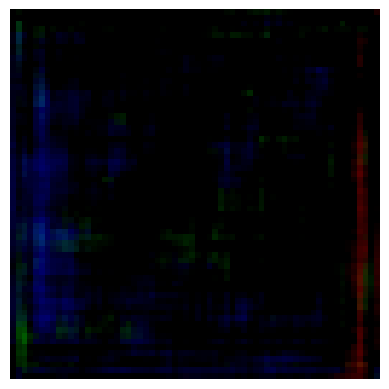

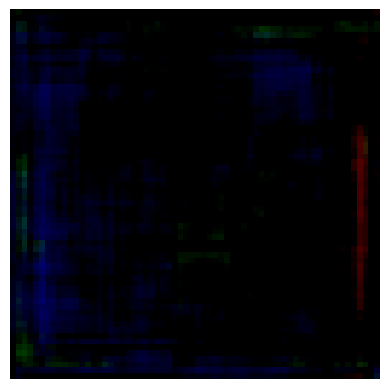

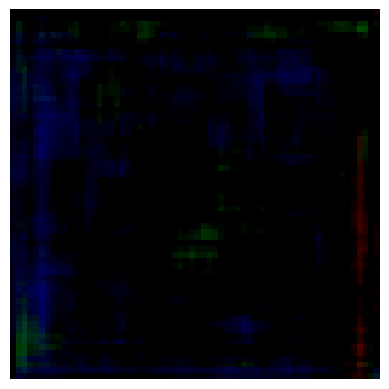

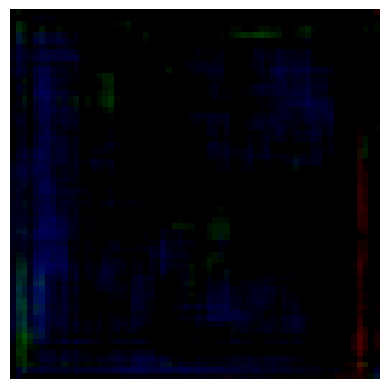

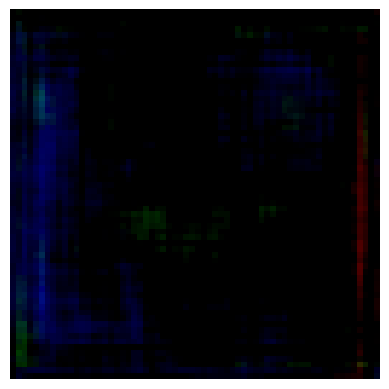

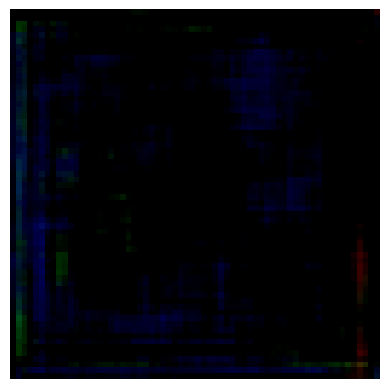

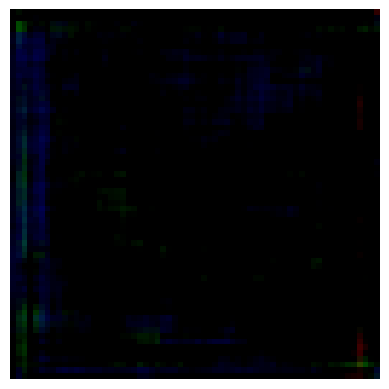

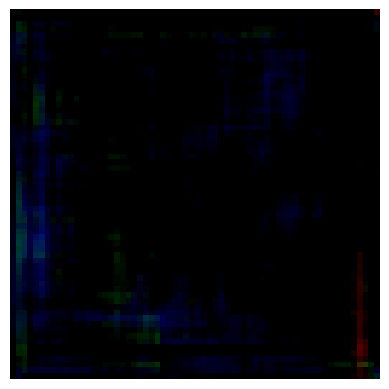

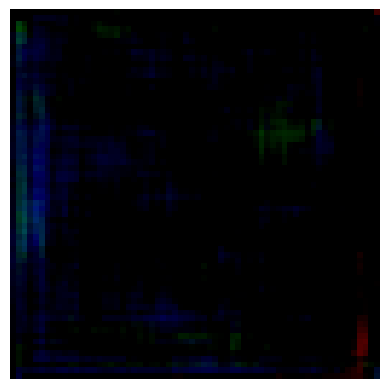

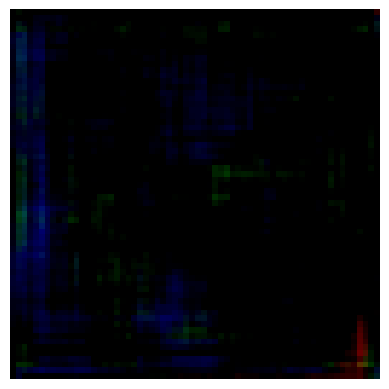

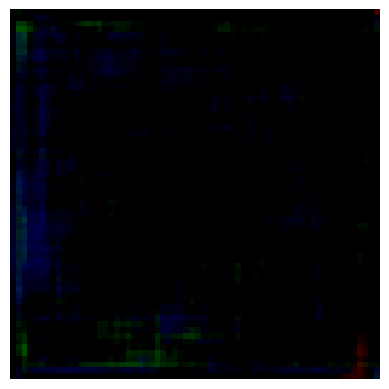

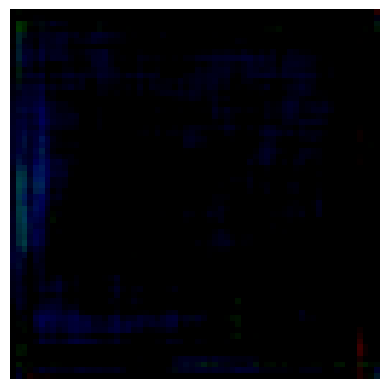

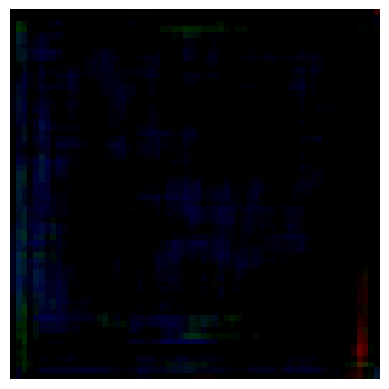

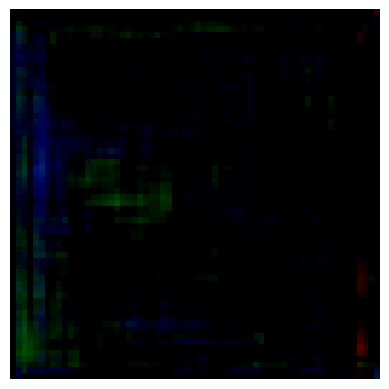

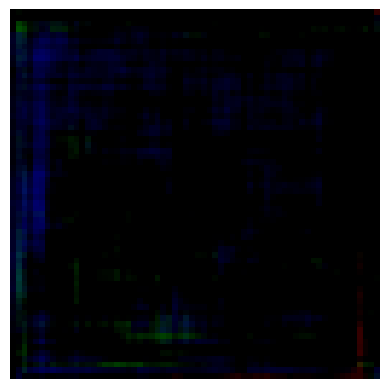

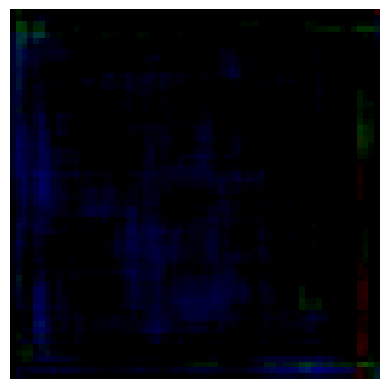

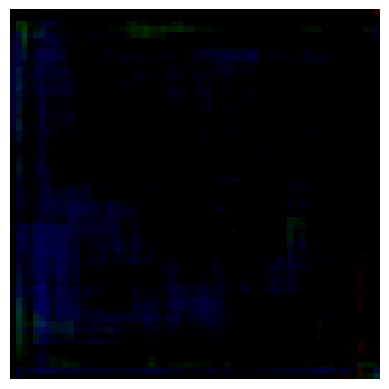

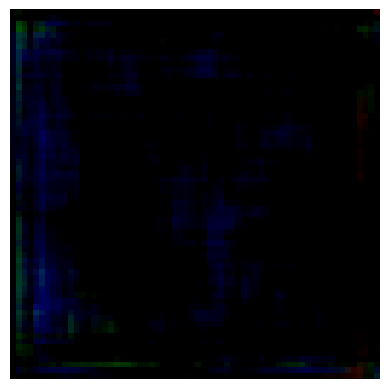

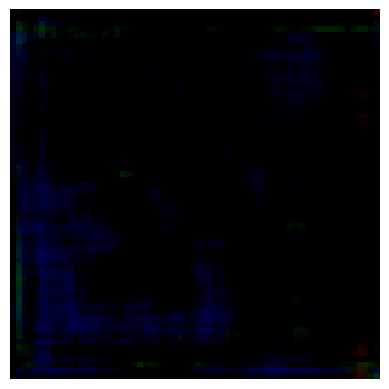

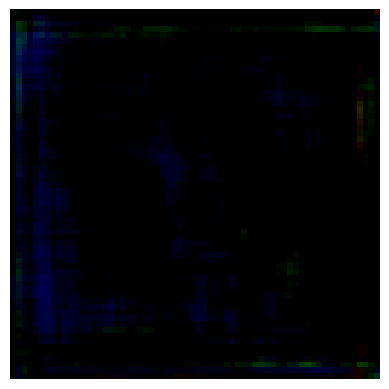

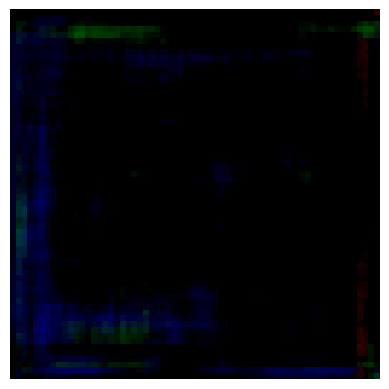

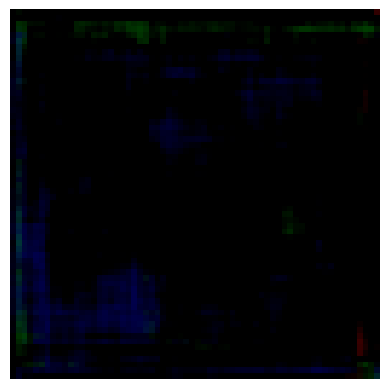

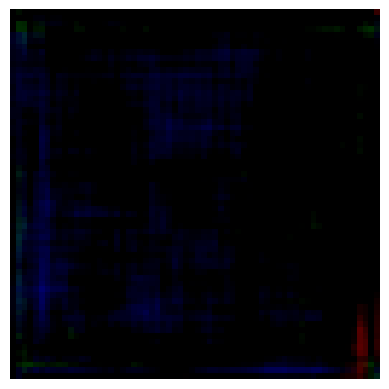

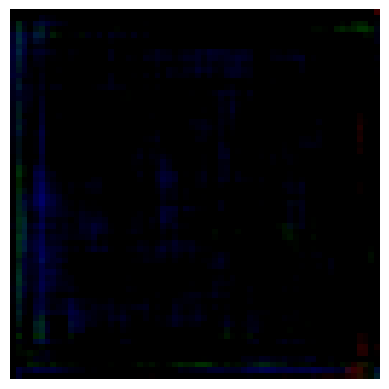

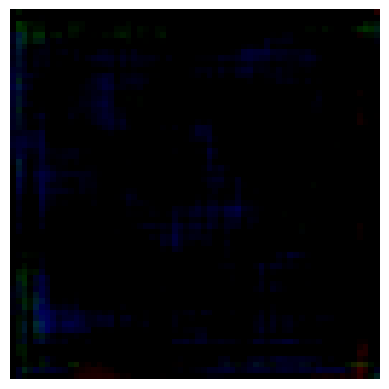

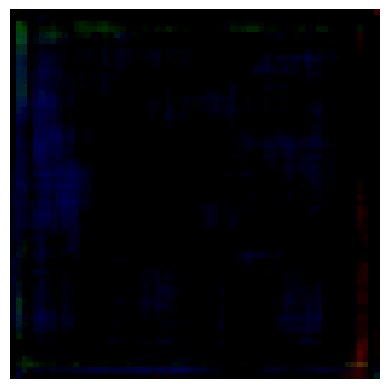

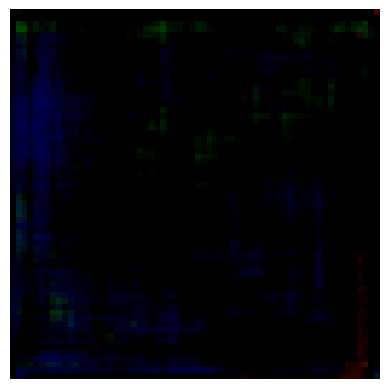

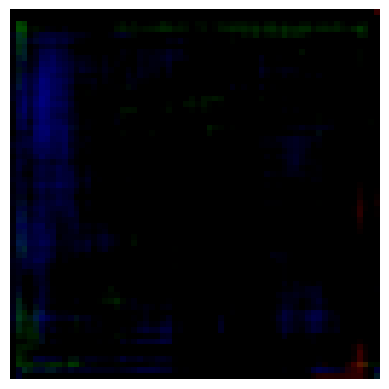

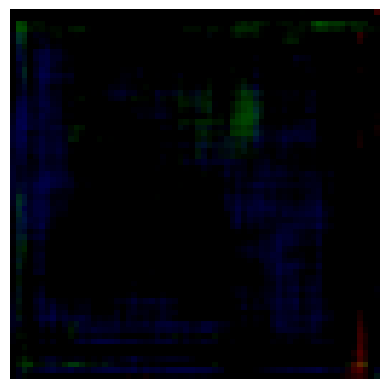

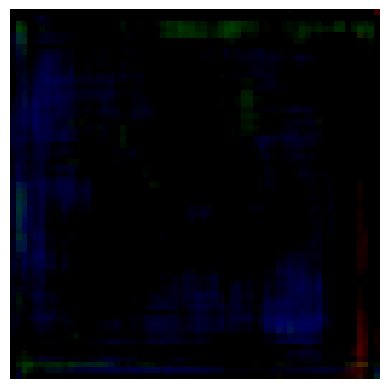

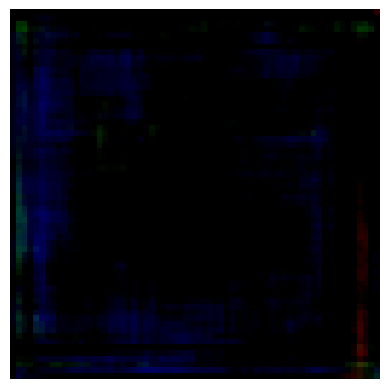

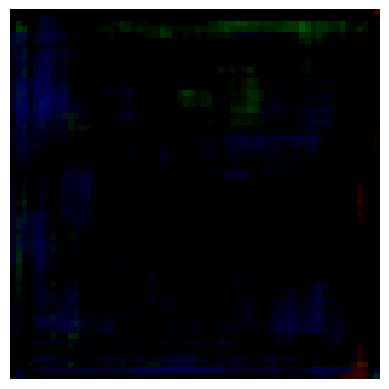

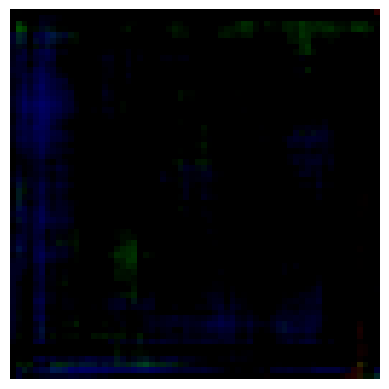

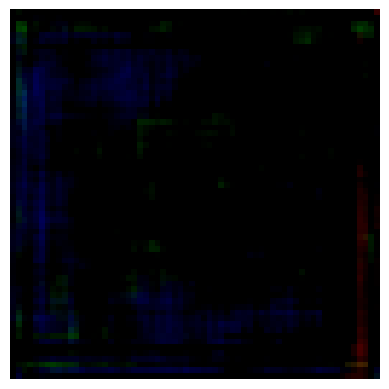

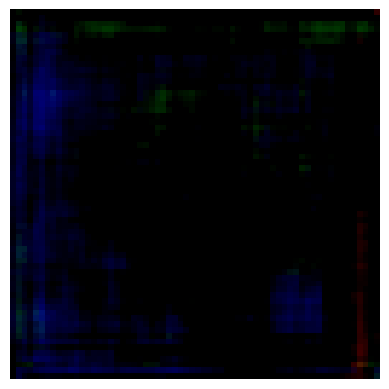

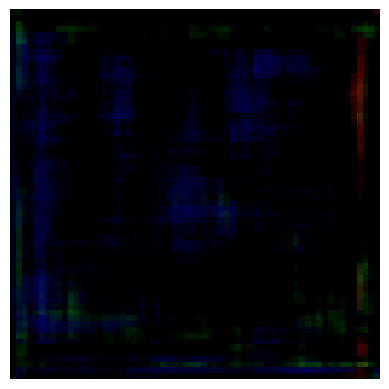

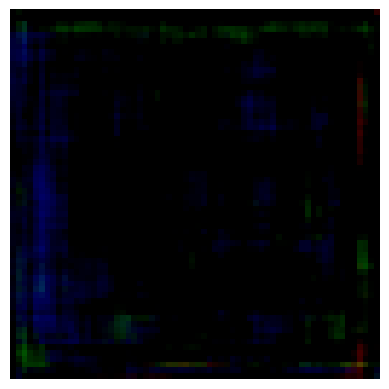

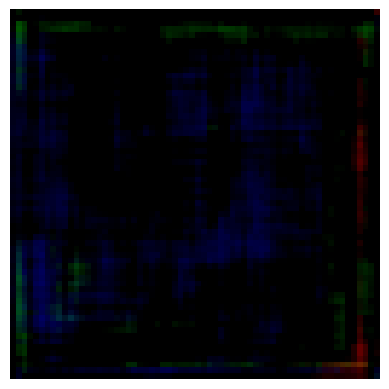

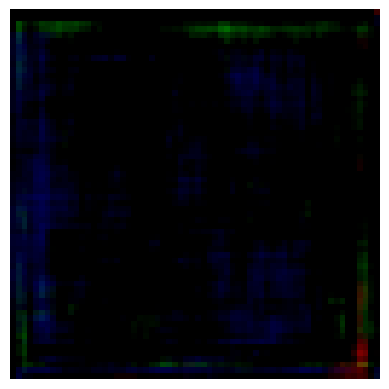

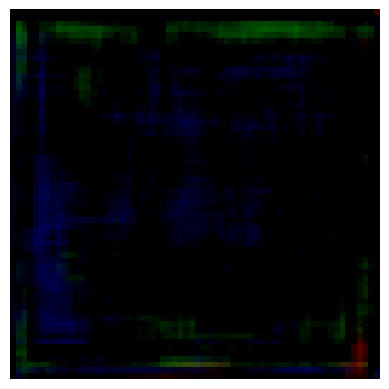

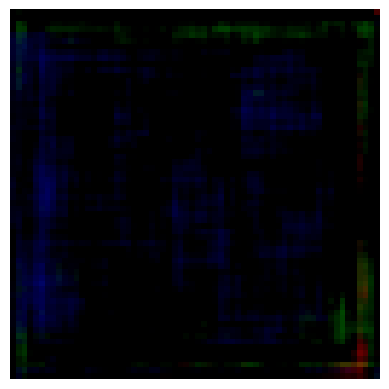

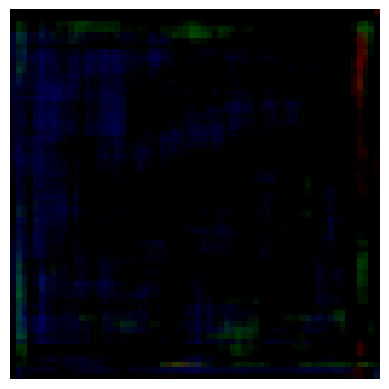

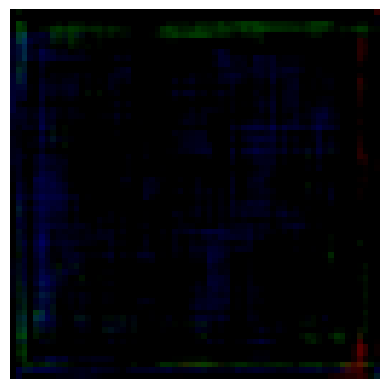

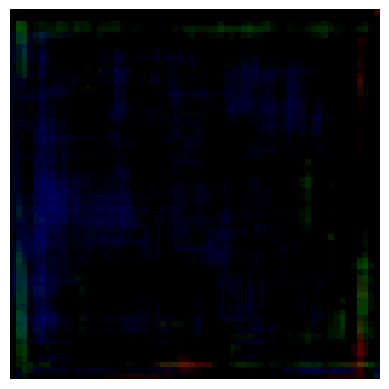

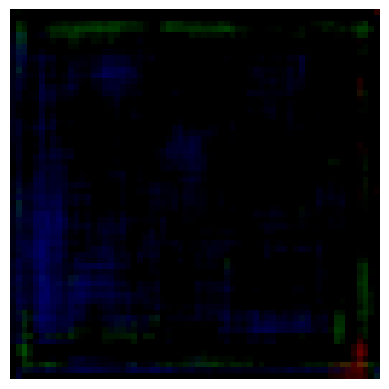

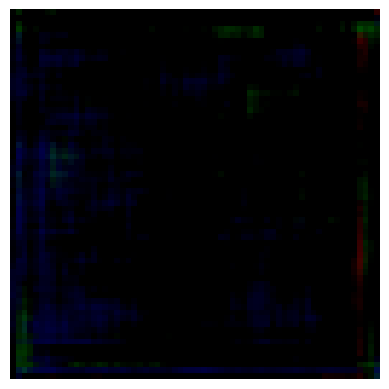

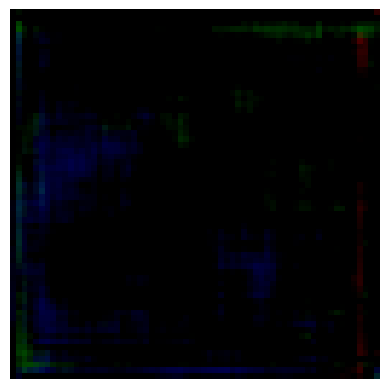

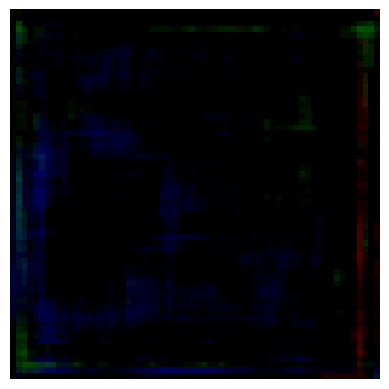

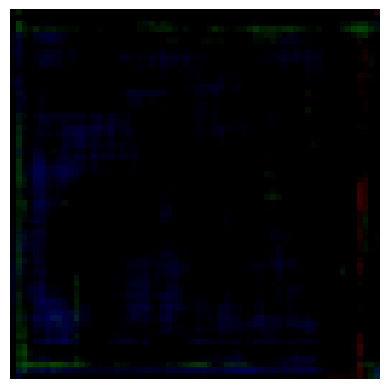

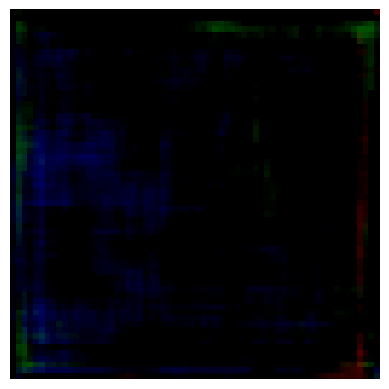

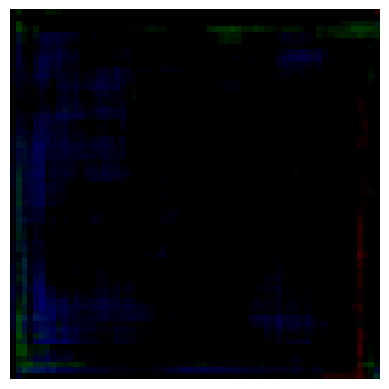

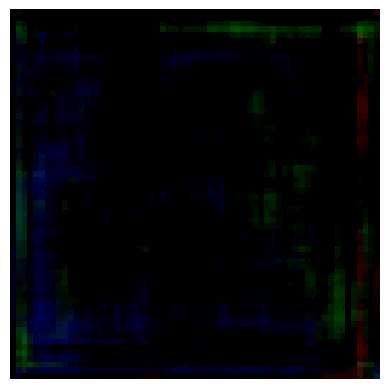

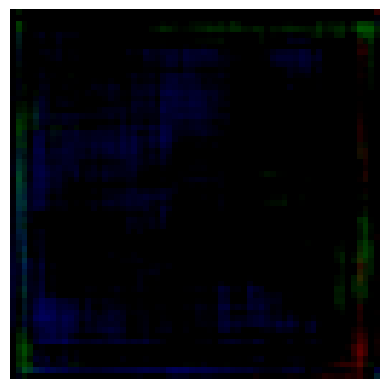

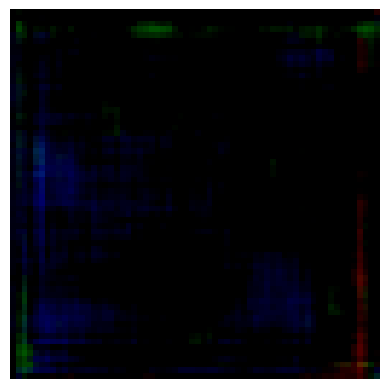

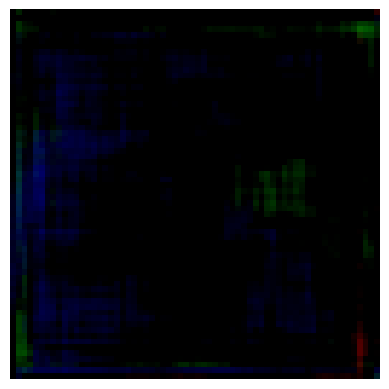

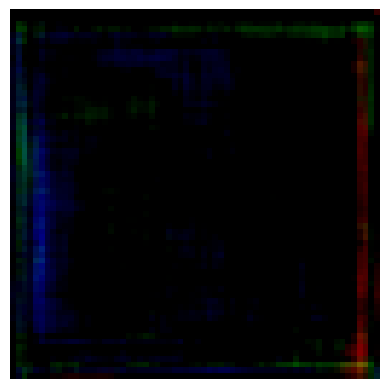

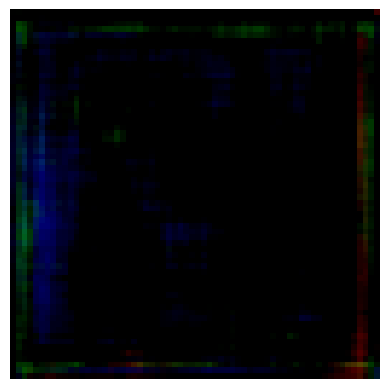

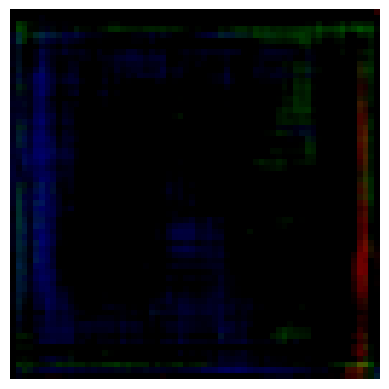

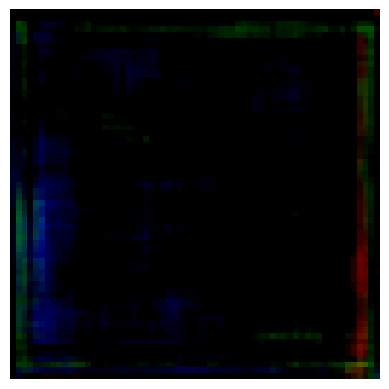

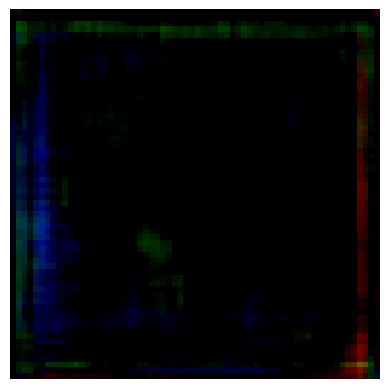

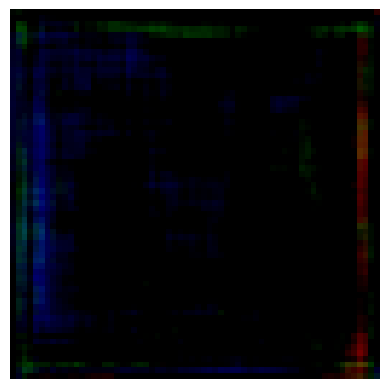

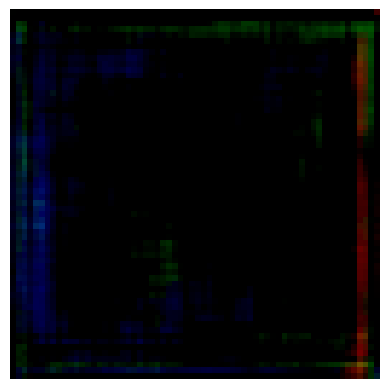

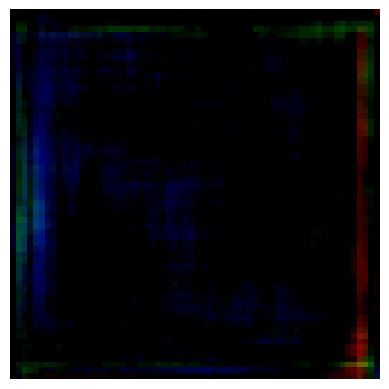

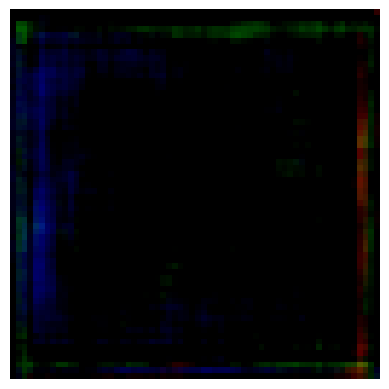

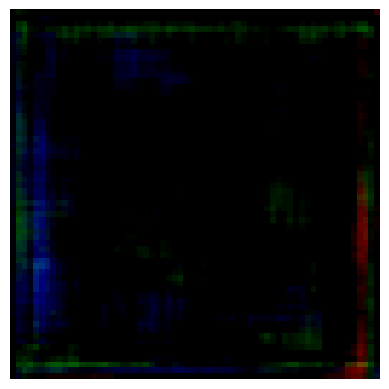

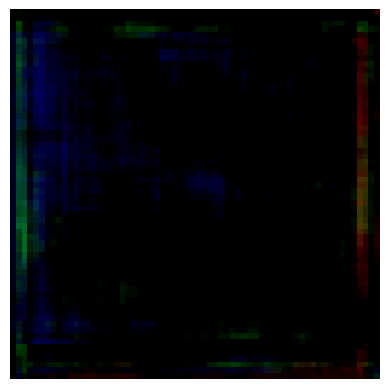

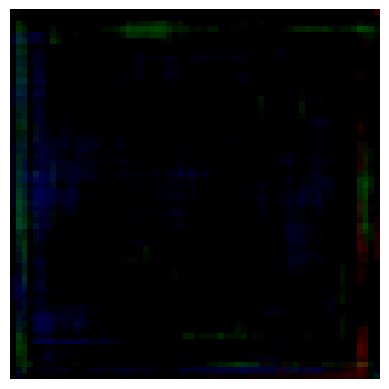

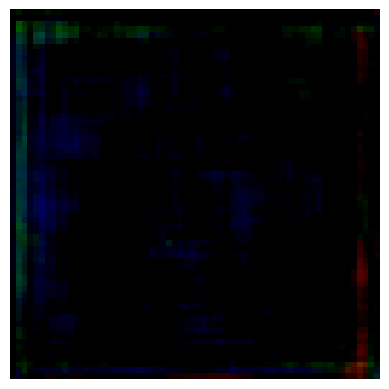

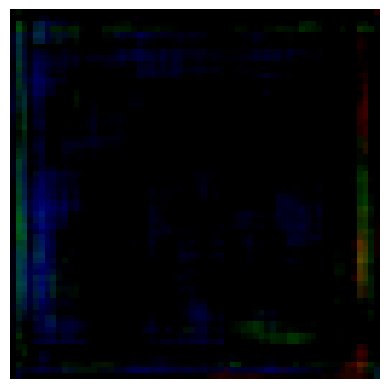

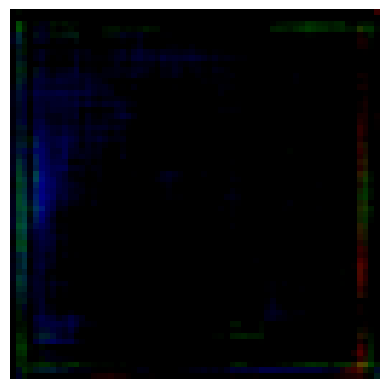

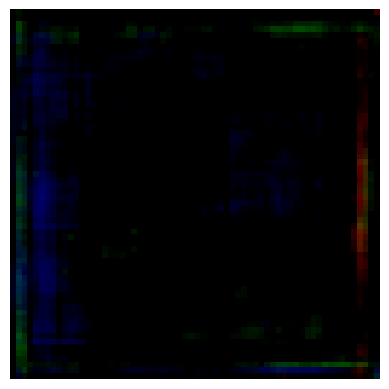

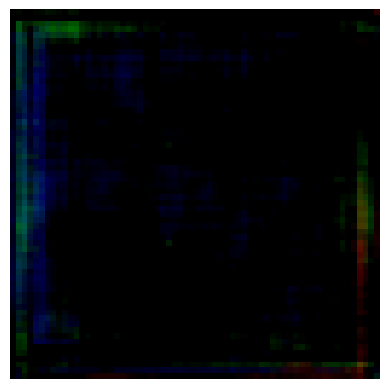

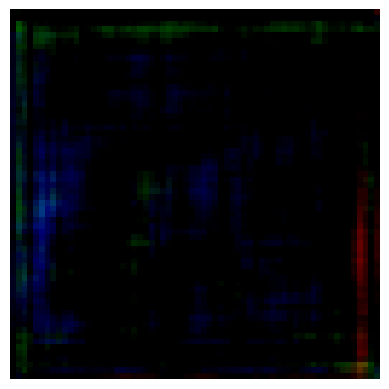

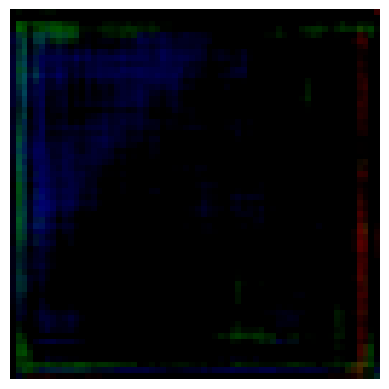

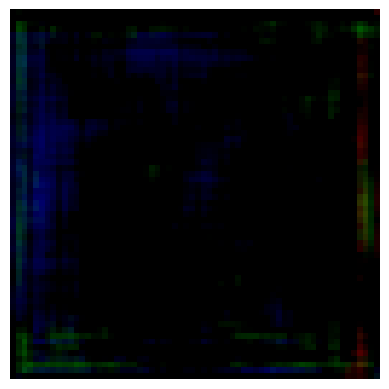

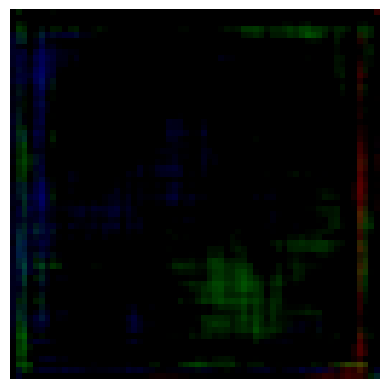

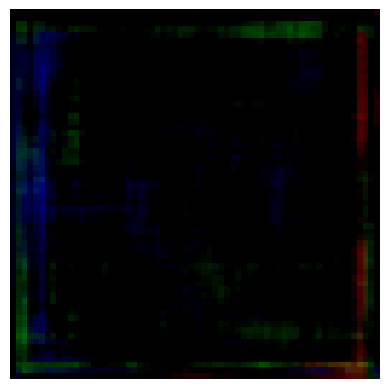

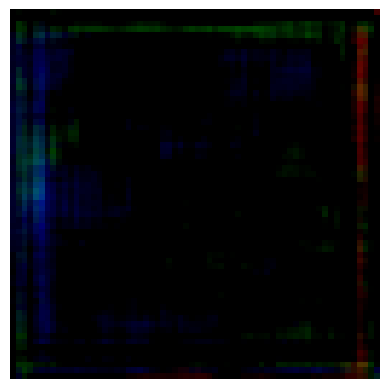

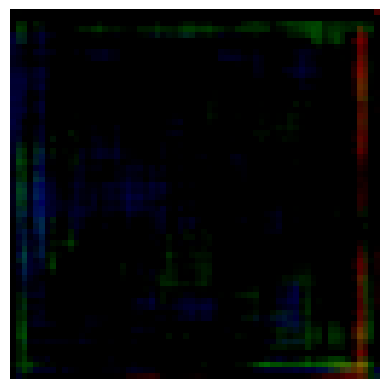

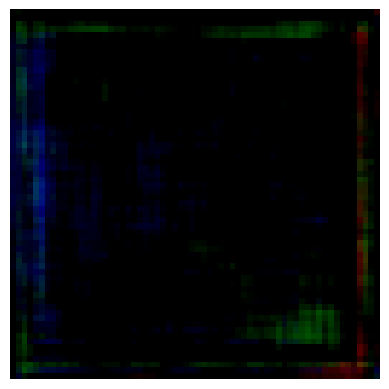

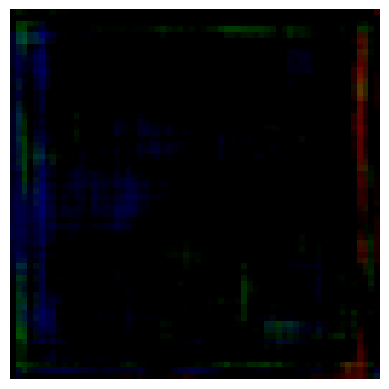

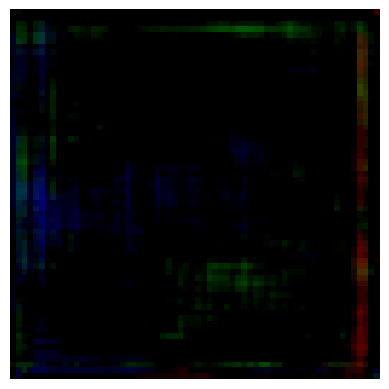

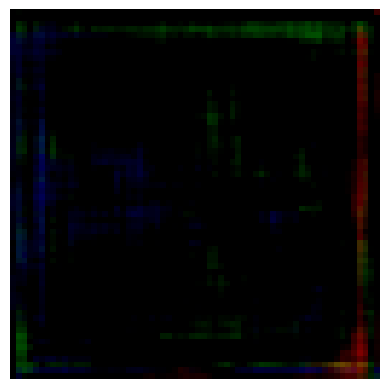

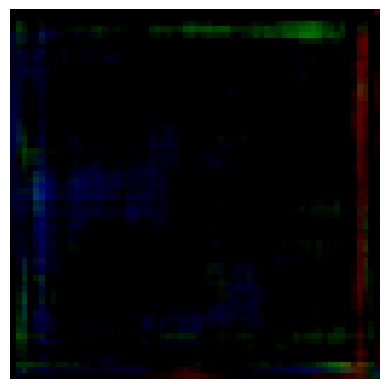

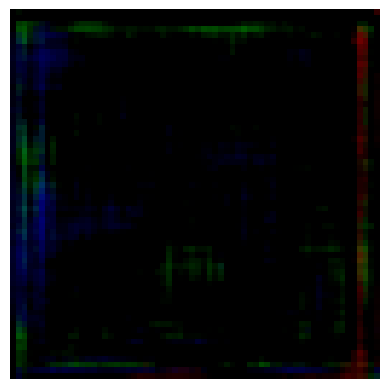

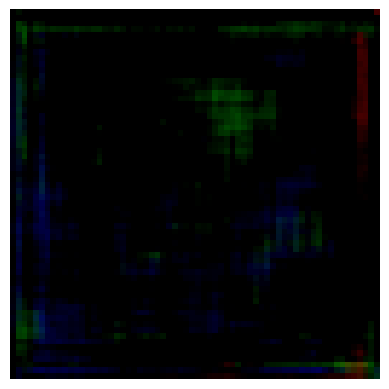

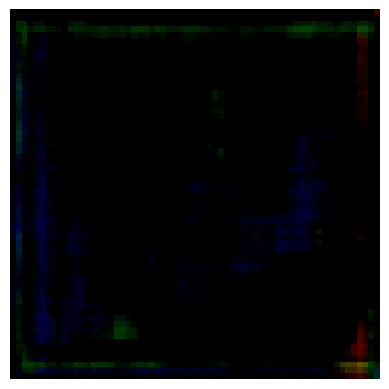

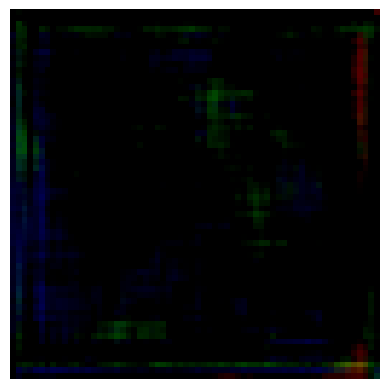

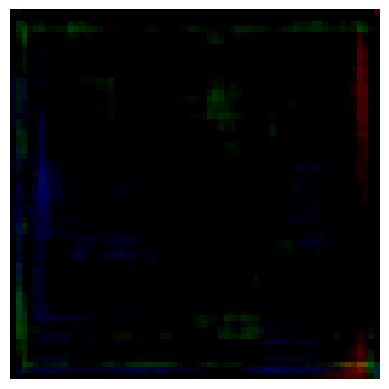

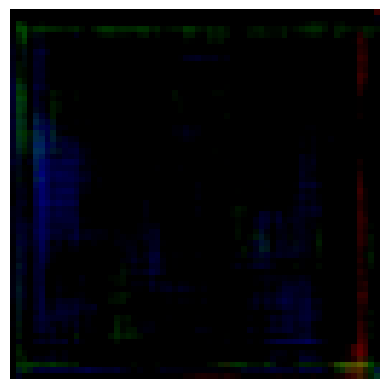

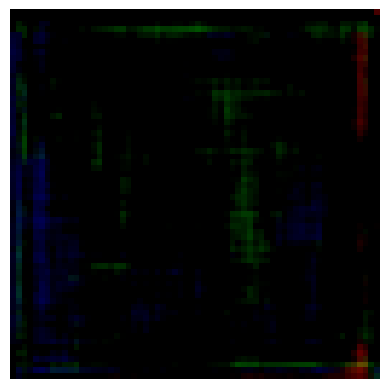

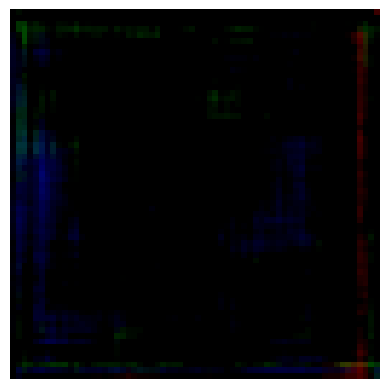

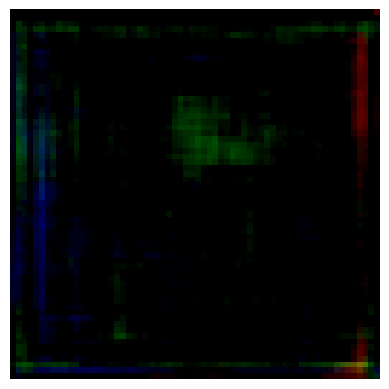

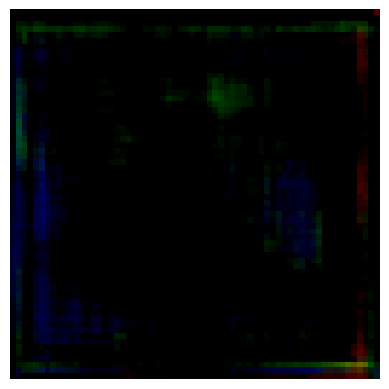

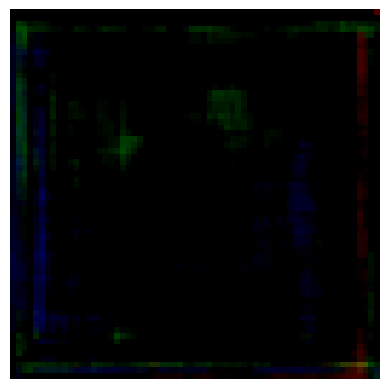

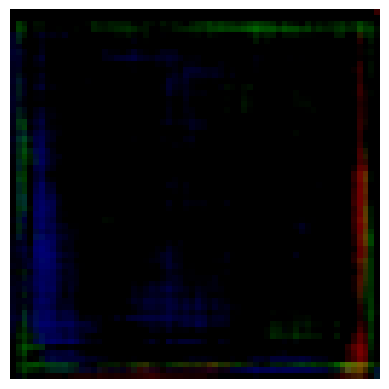

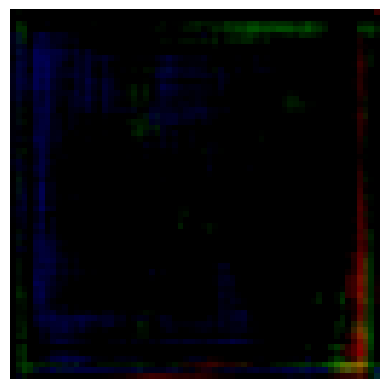

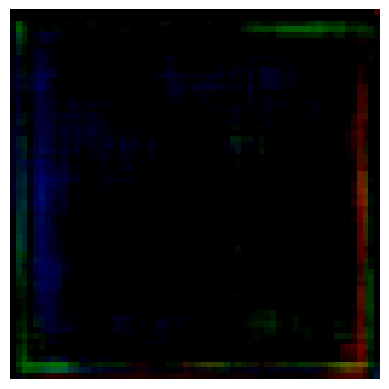

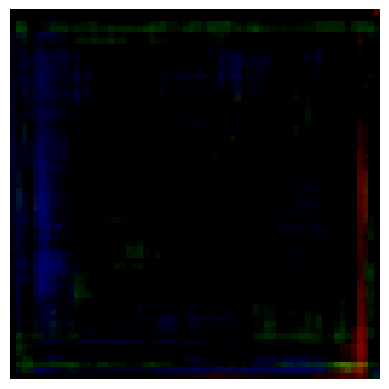

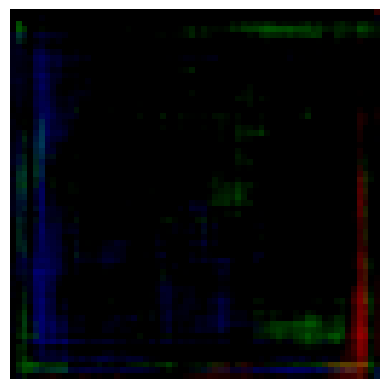

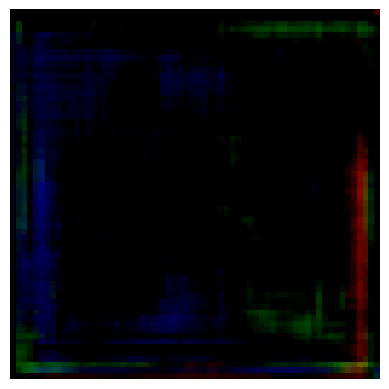

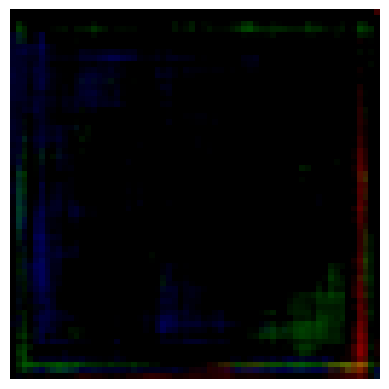

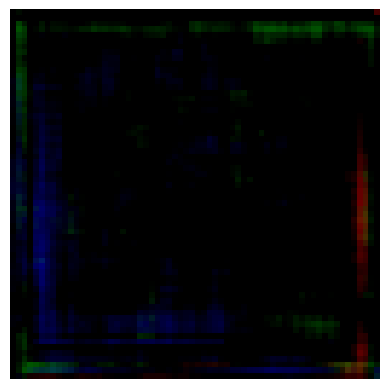

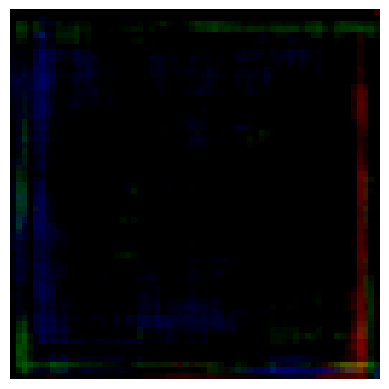

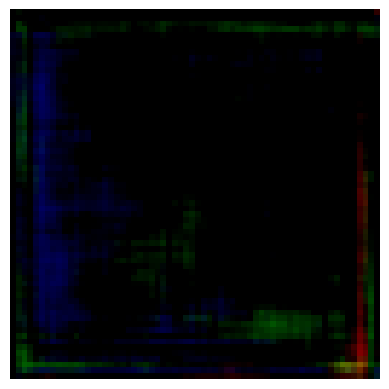

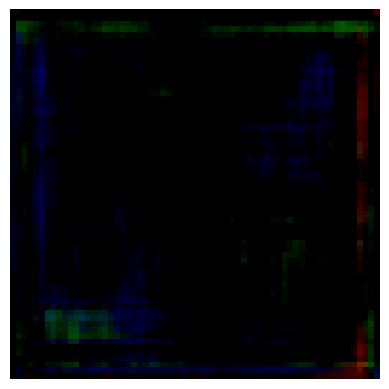

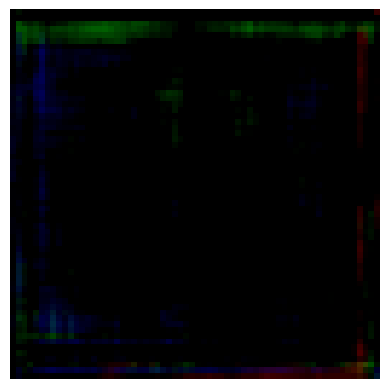

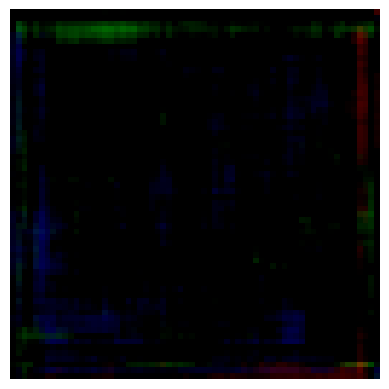

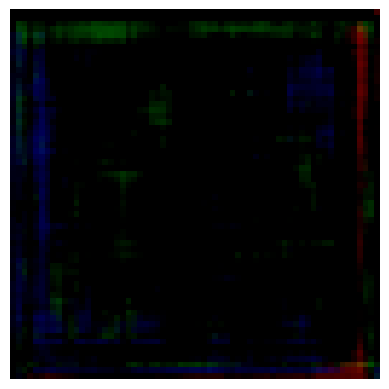

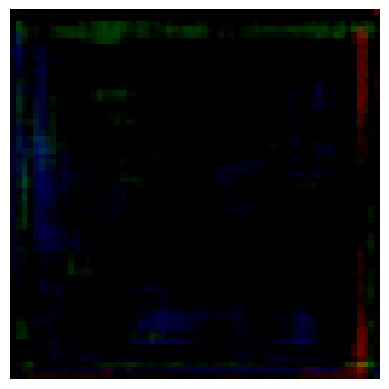

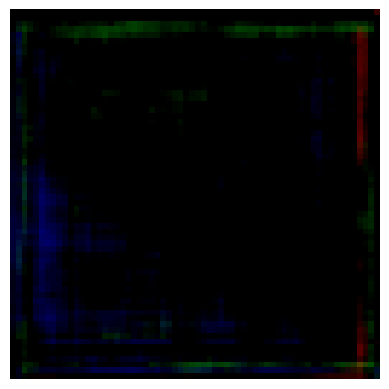

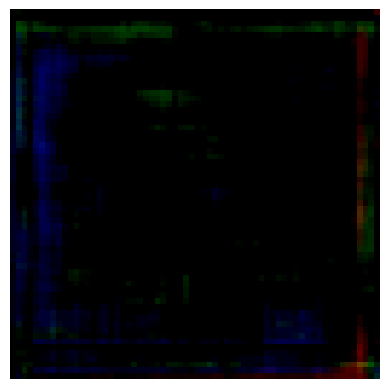

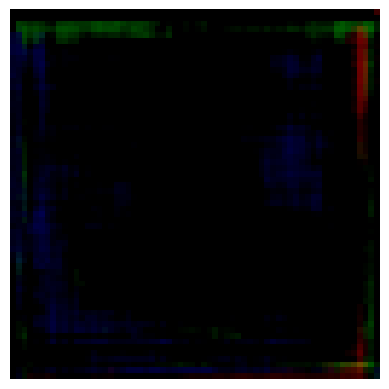

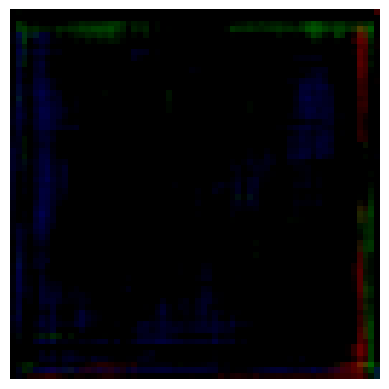

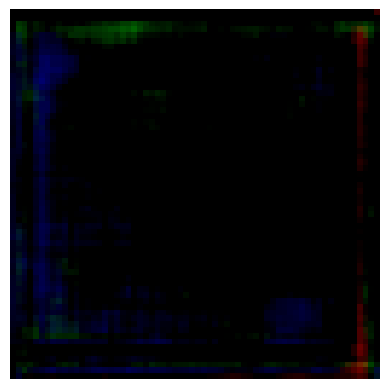

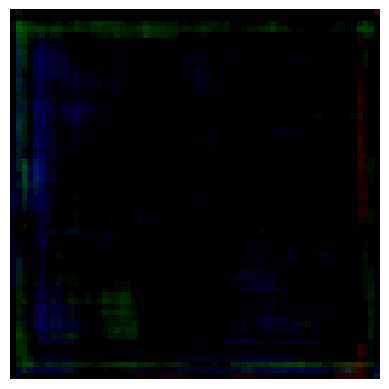

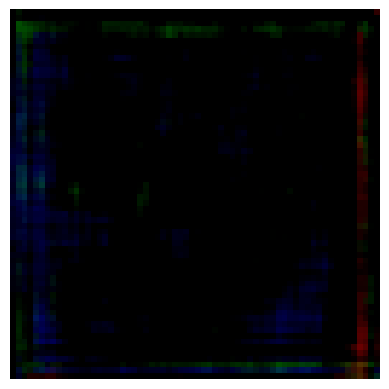

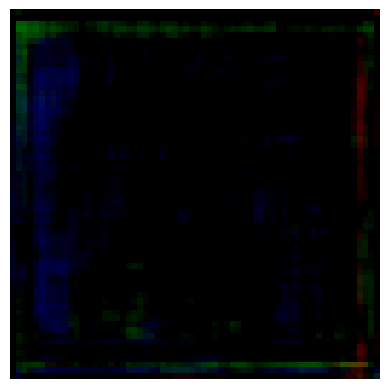

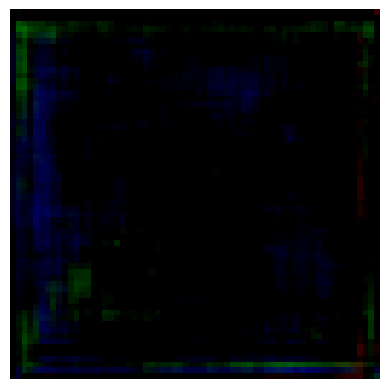

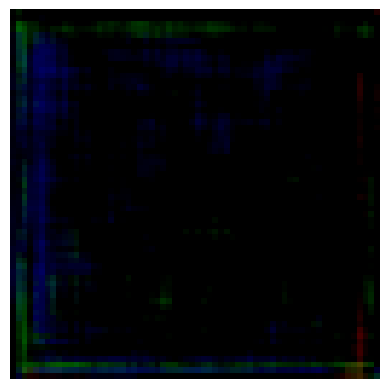

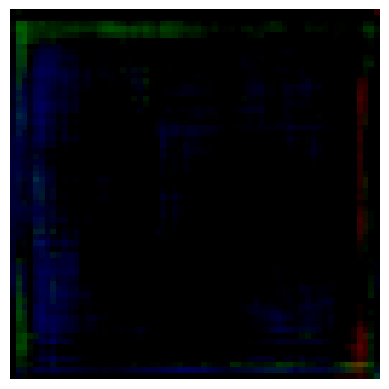

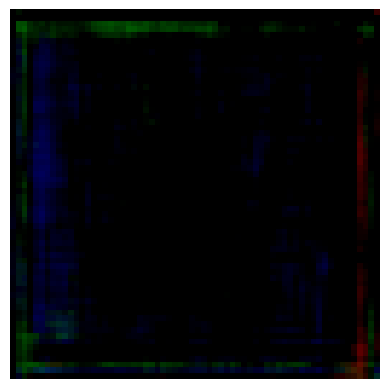

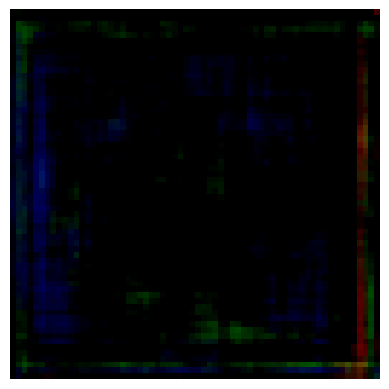

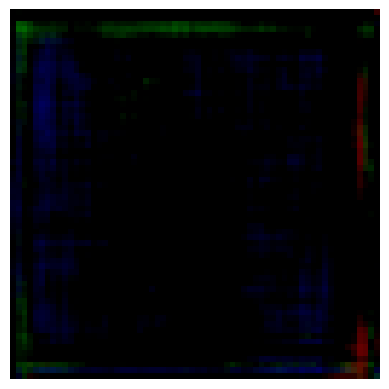

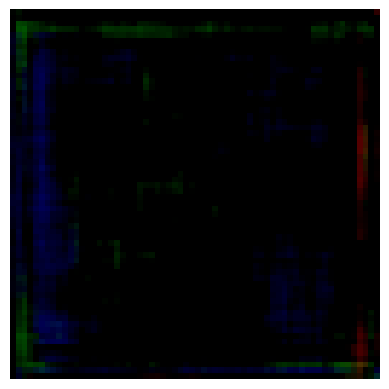

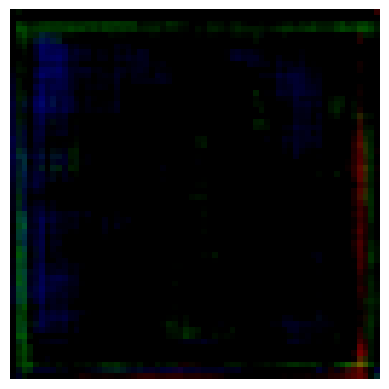

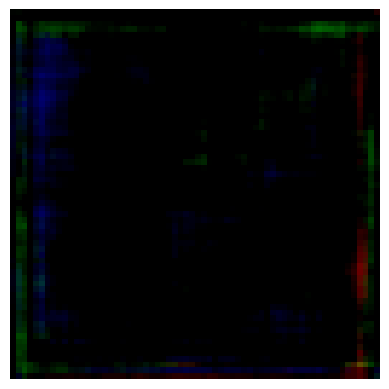

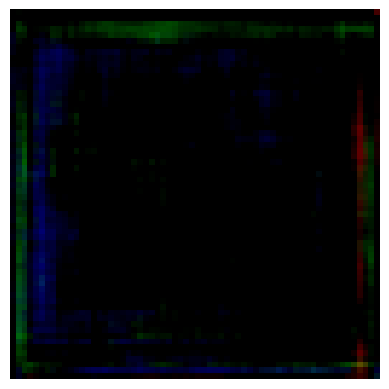

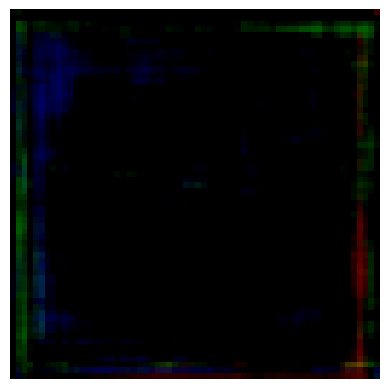

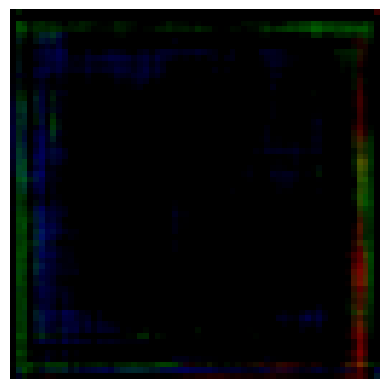

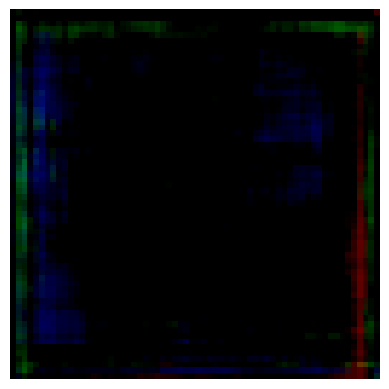

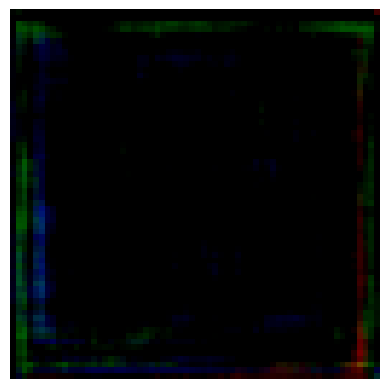

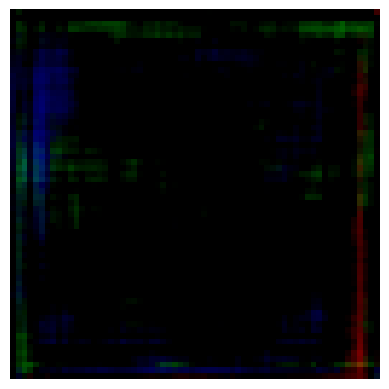

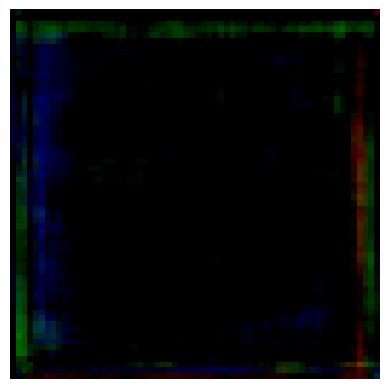

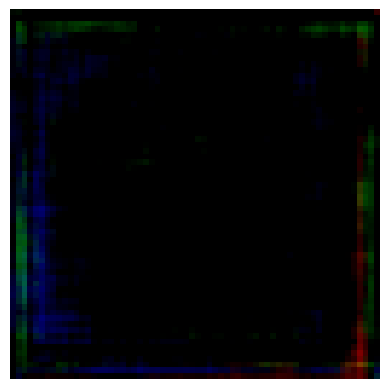

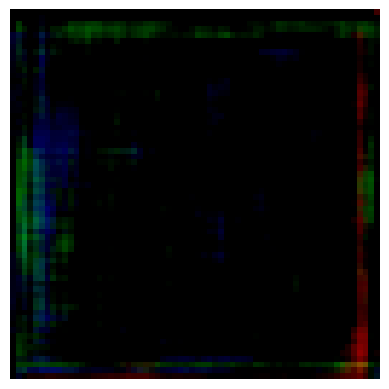

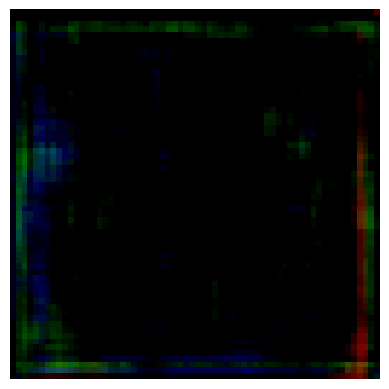

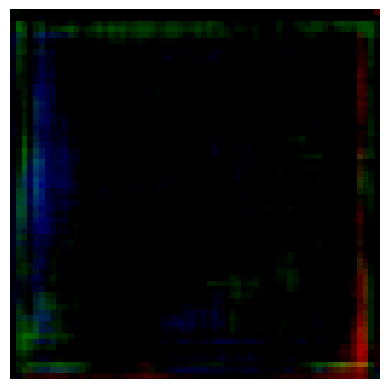

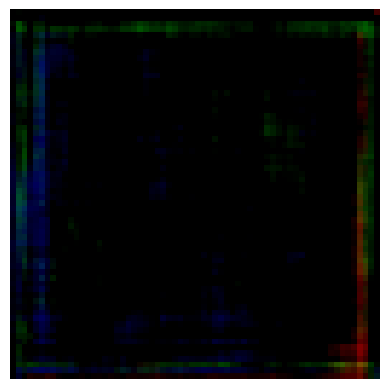

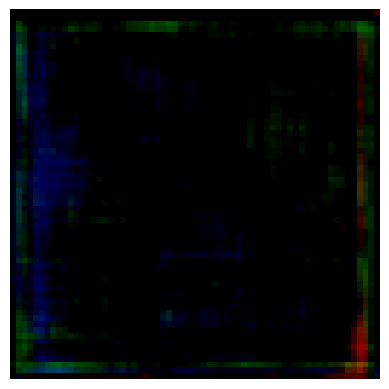

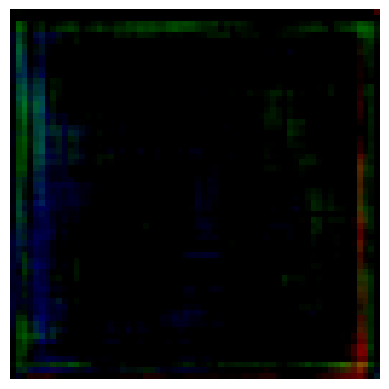

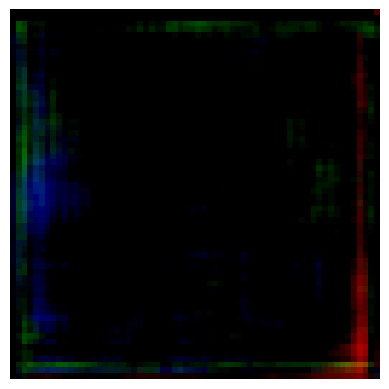

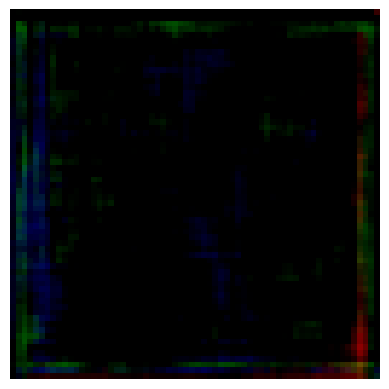

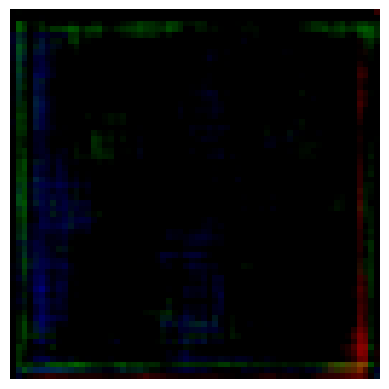

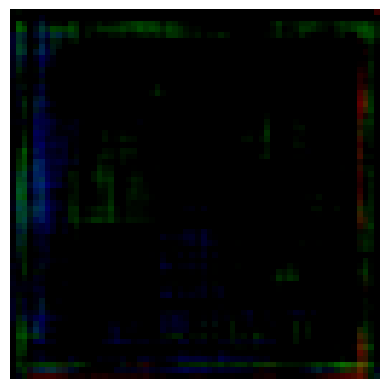

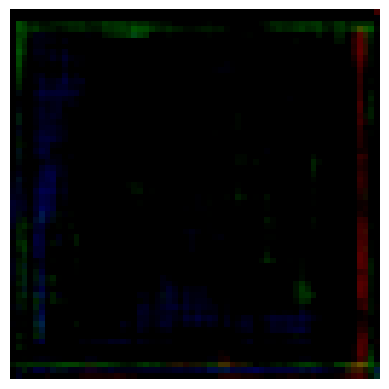

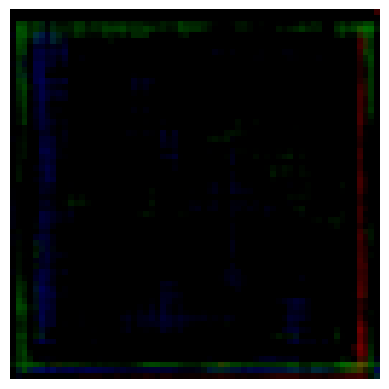

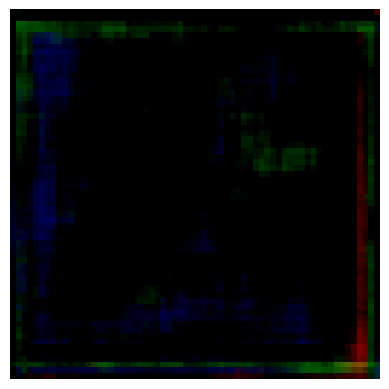

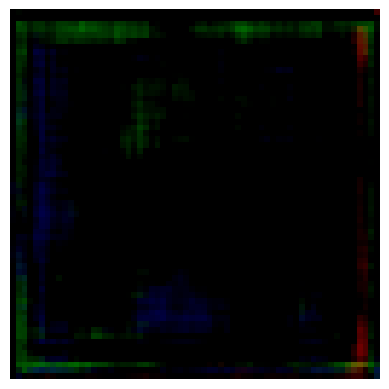

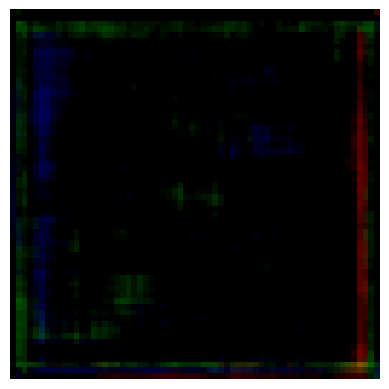

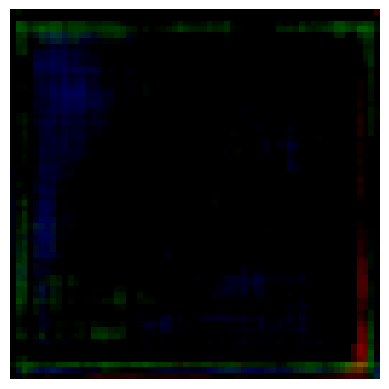

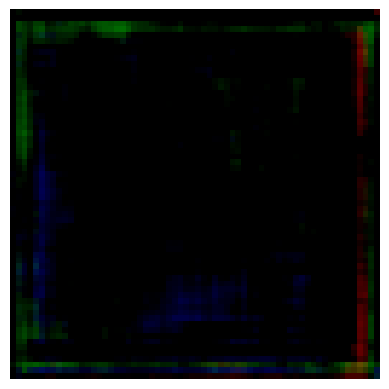

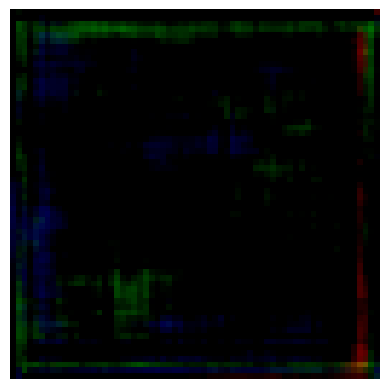

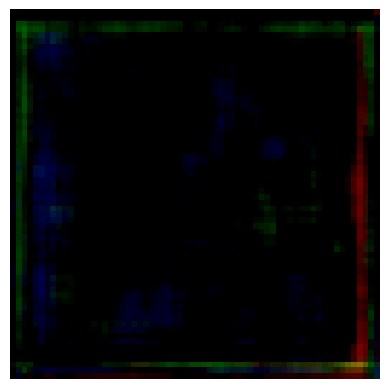

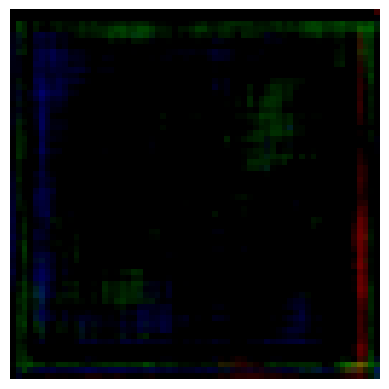

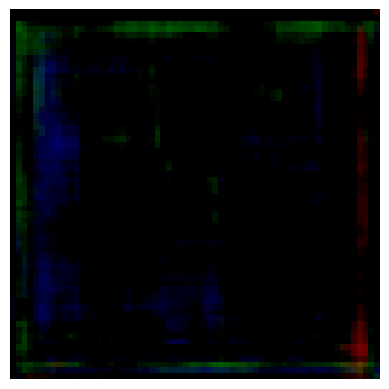

In [ ]:
stage1 = StackGanStage1()
stage1.train_stage1()

## I have to interrupt due to memory limit exceed, but all the genearted image stored in test folder for Stage 1, now I am going to implement Stage 2

#Let's Implement Stage 2 Generator

In [16]:
############################################################
# Stage 2 Generator Network
############################################################

def concat_along_dims(inputs):
	"""Joins the conditioned text with the encoded image along the dimensions.

	Args:
		inputs: consisting of conditioned text and encoded images as [c,x].

	Returns:
		Joint block along the dimensions.
	"""
	c = inputs[0]
	x = inputs[1]

	c = K.expand_dims(c, axis=1)
	c = K.expand_dims(c, axis=1)
	c = K.tile(c, [1, 16, 16, 1])
	return K.concatenate([c, x], axis = 3)

def residual_block(input):
	"""Residual block with plain identity connections.

	Args:
		inputs: input layer or an encoded layer

	Returns:
		Layer with computed identity mapping.
	"""
	x = Conv2D(512, kernel_size=(3,3), padding='same', use_bias=False,
				kernel_initializer='he_uniform')(input)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)
	
	x = Conv2D(512, kernel_size=(3,3), padding='same', use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	
	x = add([x, input])
	x = ReLU()(x)

	return x

def build_stage2_generator():
	"""Build the Stage 2 Generator Network using the conditioning text and images from stage 1.

	Returns:
		Stage 2 Generator Model for StackGAN.
	"""
	input_layer1 = Input(shape=(1024,))
	input_images = Input(shape=(64, 64, 3))

	# Conditioning Augmentation
	ca = Dense(256)(input_layer1)
	mls = LeakyReLU(alpha=0.2)(ca)
	c = Lambda(conditioning_augmentation)(mls)

	# Downsampling block
	x = ZeroPadding2D(padding=(1,1))(input_images)
	x = Conv2D(128, kernel_size=(3,3), strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = ReLU()(x)

	x = ZeroPadding2D(padding=(1,1))(x)
	x = Conv2D(256, kernel_size=(4,4), strides=2, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	x = ZeroPadding2D(padding=(1,1))(x)
	x = Conv2D(512, kernel_size=(4,4), strides=2, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	# Concatenate text conditioning block with the encoded image
	concat = concat_along_dims([c, x])

	# Residual Blocks
	x = ZeroPadding2D(padding=(1,1))(concat)
	x = Conv2D(512, kernel_size=(3,3), use_bias=False, kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	x = residual_block(x)
	x = residual_block(x)
	x = residual_block(x)
	x = residual_block(x)

	# Upsampling Blocks
	x = UpSamplingBlock(x, 512)
	x = UpSamplingBlock(x, 256)
	x = UpSamplingBlock(x, 128)
	x = UpSamplingBlock(x, 64)

	x = Conv2D(3, kernel_size=(3,3), padding='same', use_bias=False, kernel_initializer='he_uniform')(x)
	x = Activation('tanh')(x)
	
	stage2_gen = Model(inputs=[input_layer1, input_images], outputs=[x, mls])
	return stage2_gen

In [17]:
generator_stage2 = build_stage2_generator()
generator_stage2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 66, 66, 3)   0           ['input_9[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 64, 64, 128)  3456        ['zero_padding2d[0][0]']         
                                                                                                  
 re_lu_5 (ReLU)                 (None, 64, 64, 128)  0           ['conv2d_10[0][0]']              
                                                                                            

In [18]:
############################################################
# Stage 2 Discriminator Network
############################################################

def build_stage2_discriminator():
	"""Builds the Stage 2 Discriminator that uses the 256x256 resolution images from the generator
	and the compressed and spatially replicated embeddings.

	Returns:
		Stage 2 Discriminator Model for StackGAN.
	"""
	input_layer1 = Input(shape=(256, 256, 3))

	x = Conv2D(64, kernel_size=(4,4), padding='same', strides=2, use_bias=False,
				kernel_initializer='he_uniform')(input_layer1)
	x = LeakyReLU(alpha=0.2)(x)

	x = ConvBlock(x, 128)
	x = ConvBlock(x, 256)
	x = ConvBlock(x, 512)
	x = ConvBlock(x, 1024)
	x = ConvBlock(x, 2048)
	x = ConvBlock(x, 1024, (1,1), 1)
	x = ConvBlock(x, 512, (1,1), 1, False)

	x1 = ConvBlock(x, 128, (1,1), 1)
	x1 = ConvBlock(x1, 128, (3,3), 1)
	x1 = ConvBlock(x1, 512, (3,3), 1, False)

	x2 = add([x, x1])
	x2 = LeakyReLU(alpha=0.2)(x2)

	# Concatenate compressed and spatially replicated embedding
	input_layer2 = Input(shape=(4, 4, 128))
	concat = concatenate([x2, input_layer2])

	x3 = Conv2D(512, kernel_size=(1,1), strides=1, padding='same', kernel_initializer='he_uniform')(concat)
	x3 = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x3)
	x3 = LeakyReLU(alpha=0.2)(x3)

	# Flatten and add a FC layer
	x3 = Flatten()(x3)
	x3 = Dense(1)(x3)
	x3 = Activation('sigmoid')(x3)

	stage2_dis = Model(inputs=[input_layer1, input_layer2], outputs=[x3])
	return stage2_dis

In [19]:
discriminator_stage2 = build_stage2_discriminator()
discriminator_stage2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 128, 128, 64  3072        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_27[0][0]']              
                                )                                                           

In [20]:
############################################################
# Stage 2 Adversarial Model
############################################################

def stage2_adversarial_network(stage2_disc, stage2_gen, stage1_gen):
	"""Stage 2 Adversarial Network.

	Args:
		stage2_disc: Stage 2 Discriminator Model.
		stage2_gen: Stage 2 Generator Model.
		stage1_gen: Stage 1 Generator Model.

	Returns:
		Stage 2 Adversarial network.
	"""
	conditioned_embedding = Input(shape=(1024, ))
	latent_space = Input(shape=(100, ))
	compressed_replicated = Input(shape=(4, 4, 128))
    
	#the discriminator is trained separately and stage1_gen already trained, and this is the reason why we freeze its layers by setting the property trainable=false
	input_images, ca = stage1_gen([conditioned_embedding, latent_space])
	stage2_disc.trainable = False
	stage1_gen.trainable = False

	images, ca2 = stage2_gen([conditioned_embedding, input_images])
	probability = stage2_disc([images, compressed_replicated])

	return Model(inputs=[conditioned_embedding, latent_space, compressed_replicated],
		outputs=[probability, ca2])
adversarial_stage2 = stage2_adversarial_network(discriminator_stage2, generator_stage2, generator)
adversarial_stage2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 model (Functional)             [(None, 64, 64, 3),  10270400    ['input_12[0][0]',               
                                 (None, 256)]                     'input_13[0][0]']               
                                                                                                  
 model_3 (Functional)           [(None, 256, 256, 3  28645440    ['input_12[0][0]',         

In [21]:
class StackGanStage2(object):
	"""StackGAN Stage 2 class.

	Args:
		epochs: Number of epochs
		z_dim: Latent space dimensions
		batch_size: Batch Size
		enable_function: If True, training function is decorated with tf.function
		stage2_generator_lr: Learning rate for stage 2 generator
		stage2_discriminator_lr: Learning rate for stage 2 discriminator
	"""
	def __init__(self, epochs=100, z_dim=100, batch_size=64, enable_function=True, stage2_generator_lr=0.0002, stage2_discriminator_lr=0.0002):
		self.epochs = epochs
		self.z_dim = z_dim
		self.enable_function = enable_function
		self.stage1_generator_lr = stage2_generator_lr
		self.stage1_discriminator_lr = stage2_discriminator_lr
		self.low_image_size = 64
		self.high_image_size = 256
		self.conditioning_dim = 128
		self.batch_size = batch_size
		self.stage2_generator_optimizer = Adam(lr=stage2_generator_lr, beta_1=0.5, beta_2=0.999)
		self.stage2_discriminator_optimizer = Adam(lr=stage2_discriminator_lr, beta_1=0.5, beta_2=0.999)
		self.stage1_generator = build_stage1_generator()
		self.stage1_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)
		self.stage1_generator.load_weights('/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage1_gen.h5')
		self.stage2_generator = build_stage2_generator()
		self.stage2_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)

		self.stage2_discriminator = build_stage2_discriminator()
		self.stage2_discriminator.compile(loss='binary_crossentropy', optimizer=self.stage2_discriminator_optimizer)

		self.ca_network = build_ca_network()
		self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')

		self.embedding_compressor = build_embedding_compressor()
		self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')

		self.stage2_adversarial = stage2_adversarial_network(self.stage2_discriminator, self.stage2_generator, self.stage1_generator)
		self.stage2_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], loss_weights=[1, 2.0], optimizer=self.stage2_generator_optimizer)	

		self.checkpoint2 = tf.train.Checkpoint(
        	generator_optimizer=self.stage2_generator_optimizer,
        	discriminator_optimizer=self.stage2_discriminator_optimizer,
        	generator=self.stage2_generator,
        	discriminator=self.stage2_discriminator,
        	generator1=self.stage1_generator)

	def visualize_stage2(self):
		"""Running Tensorboard visualizations.
		"""
		tb = TensorBoard(log_dir="logs/".format(time.time()))
		tb.set_model(self.stage2_generator)
		tb.set_model(self.stage2_discriminator)

	def train_stage2(self):
		"""Trains Stage 2 StackGAN.
		"""
		x_high_train, y_high_train, high_train_embeds = load_data(filename_path=self.filename_path_train, class_id_path=self.class_id_path_train,
      dataset_path=self.dataset_path, embeddings_path=self.embeddings_path_train, size=(256, 256))

		x_high_test, y_high_test, high_test_embeds = load_data(filename_path=self.filename_path_test, class_id_path=self.class_id_path_test, 
      dataset_path=self.dataset_path, embeddings_path=self.embeddings_path_test, size=(256, 256))

		x_low_train, y_low_train, low_train_embeds = load_data(filename_path=self.filename_path_train, class_id_path=self.class_id_path_train,
      dataset_path=self.dataset_path, embeddings_path=self.embeddings_path_train, size=(64, 64))

		x_low_test, y_low_test, low_test_embeds = load_data(filename_path=self.filename_path_test, class_id_path=self.class_id_path_test, 
      dataset_path=self.dataset_path, embeddings_path=self.embeddings_path_test, size=(64, 64))

		real = np.ones((self.batch_size, 1), dtype='float') * 0.9
		fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

		for epoch in range(self.epochs):
			print(f'Epoch: {epoch}')

			gen_loss = []
			disc_loss = []

			num_batches = int(x_high_train.shape[0] / self.batch_size)

			for i in range(num_batches):

				latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				embedding_text = high_train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
				compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
				compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, self.conditioning_dim))
				compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

				image_batch = x_high_train[i * self.batch_size:(i+1) * self.batch_size]
				image_batch = (image_batch - 127.5) / 127.5
				
				low_res_fakes, _ = self.stage1_generator.predict([embedding_text, latent_space], verbose=3)
				high_res_fakes, _ = self.stage2_generator.predict([embedding_text, low_res_fakes], verbose=3)

				discriminator_loss = self.stage2_discriminator.train_on_batch([image_batch, compressed_embedding],
					np.reshape(real, (self.batch_size, 1)))

				discriminator_loss_gen = self.stage2_discriminator.train_on_batch([high_res_fakes, compressed_embedding],
					np.reshape(fake, (self.batch_size, 1)))

				discriminator_loss_fake = self.stage2_discriminator.train_on_batch([image_batch[:(self.batch_size-1)], compressed_embedding[1:]],
					np.reshape(fake[1:], (self.batch_size - 1, 1)))

				d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_fake))
				disc_loss.append(d_loss)

				print(f'Discriminator Loss: {d_loss}')

				g_loss = self.stage2_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
					[K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])
				gen_loss.append(g_loss)

				print(f'Generator Loss: {g_loss}')

				if epoch % 5 == 0:
					latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
					embedding_batch = high_test_embeds[0 : self.batch_size]

					low_fake_images, _ = self.stage1_generator.predict([embedding_batch, latent_space], verbose=3)
					high_fake_images, _ = self.stage2_generator.predict([embedding_batch, low_fake_images], verbose=3)

					for i, image in enumerate(high_fake_images[:10]):
					    save_image(image, f'/content/drive/MyDrive/Text2Img_DC_GAN/results_stage2/gen_{epoch}_{i}.png')

				if epoch % 10 == 0:
					self.stage2_generator.save_weights('/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage2_gen.h5')
					self.stage2_discriminator.save_weights("/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage2_disc.h5")
					self.ca_network.save_weights('/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage2_ca.h5')
					self.embedding_compressor.save_weights('/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage2_embco.h5')
					self.stage2_adversarial.save_weights('/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage2_adv.h5')

		self.stage2_generator.save_weights('/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage2_gen.h5')
		self.stage2_discriminator.save_weights("/content/drive/MyDrive/Text2Img_DC_GAN/weights/stage2_disc.h5")

In [ ]:
stage2 = StackGanStage2()
stage2.train_stage2()

#After this stage we get the Stage 2 generated Image. I can't run the above code because I have some memory limit issue in my device, This need a high Computational Power device.